# Set Environment

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
# plt.style.use('ggplot')
plt.style.use('fivethirtyeight')
%matplotlib inline
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
import os
from pylab import rcParams

from numpy.random import normal, seed
from scipy.stats import norm
# from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import math
from sklearn.metrics import mean_squared_error

from plotly import tools

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'

def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax

print("Setup Complete")

Setup Complete


# Data Exploration

## Dataset

In [2]:
df_stock = pd.read_csv('kaggle_stock_data.csv')
df_stock = df_stock.drop(df_stock.columns[0],axis=1)
df_stock = df_stock.drop_duplicates()
df_stock['Instrument'].value_counts()

Instrument
NMIG.D          1207
REIT.LU         1207
ETEG.D          1207
SSSG.D          1207
AIR.PA          1207
                ... 
EIC.S             99
3D6.DE            84
DISG.SG^F23       68
BC.S^D19          61
GSKGn.DE^D11       1
Name: count, Length: 408, dtype: int64

In [3]:
df_stock = df_stock[df_stock['Instrument']=='AIR.PA'].drop(df_stock.columns[[0]],axis=1)

# 将 "Date" 列解析为日期时间格式，以确保日期显示为 "年-月-日" 格式
df_stock['Date'] = pd.to_datetime(df_stock['Date'])

# 将 "Date" 列设置为索引
df_stock.set_index('Date', inplace=True)

In [4]:
df_stock

Price High  Price Close  Price Open     Volume
Date                                                                     
2019-01-02 00:00:00+00:00       84.45        84.17       83.58  1483033.0
2019-01-03 00:00:00+00:00       83.75        81.21       83.33  1964509.0
2019-01-04 00:00:00+00:00       85.52        85.12       82.16  2006859.0
2019-01-07 00:00:00+00:00       86.95        83.56       85.96  1428948.0
2019-01-08 00:00:00+00:00       88.61        86.65       83.83  2533915.0
...                               ...          ...         ...        ...
2023-09-07 00:00:00+00:00      137.20       136.42      133.80   869871.0
2023-09-08 00:00:00+00:00      136.62       135.44      136.48   839474.0
2023-09-11 00:00:00+00:00      136.00       133.66      135.98  1391017.0
2023-09-12 00:00:00+00:00      133.84       130.48      133.72  1333446.0
2023-09-13 00:00:00+00:00      131.12       130.52      130.44   842987.0

[1207 rows x 4 columns]

In [5]:
df_stock.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1207 entries, 2019-01-02 00:00:00+00:00 to 2023-09-13 00:00:00+00:00
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Price High   1207 non-null   float64
 1   Price Close  1207 non-null   float64
 2   Price Open   1207 non-null   float64
 3   Volume       1207 non-null   float64
dtypes: float64(4)
memory usage: 47.1 KB


In [6]:
df_stock.isnull().sum()

Price High     0
Price Close    0
Price Open     0
Volume         0
dtype: int64

## EDA

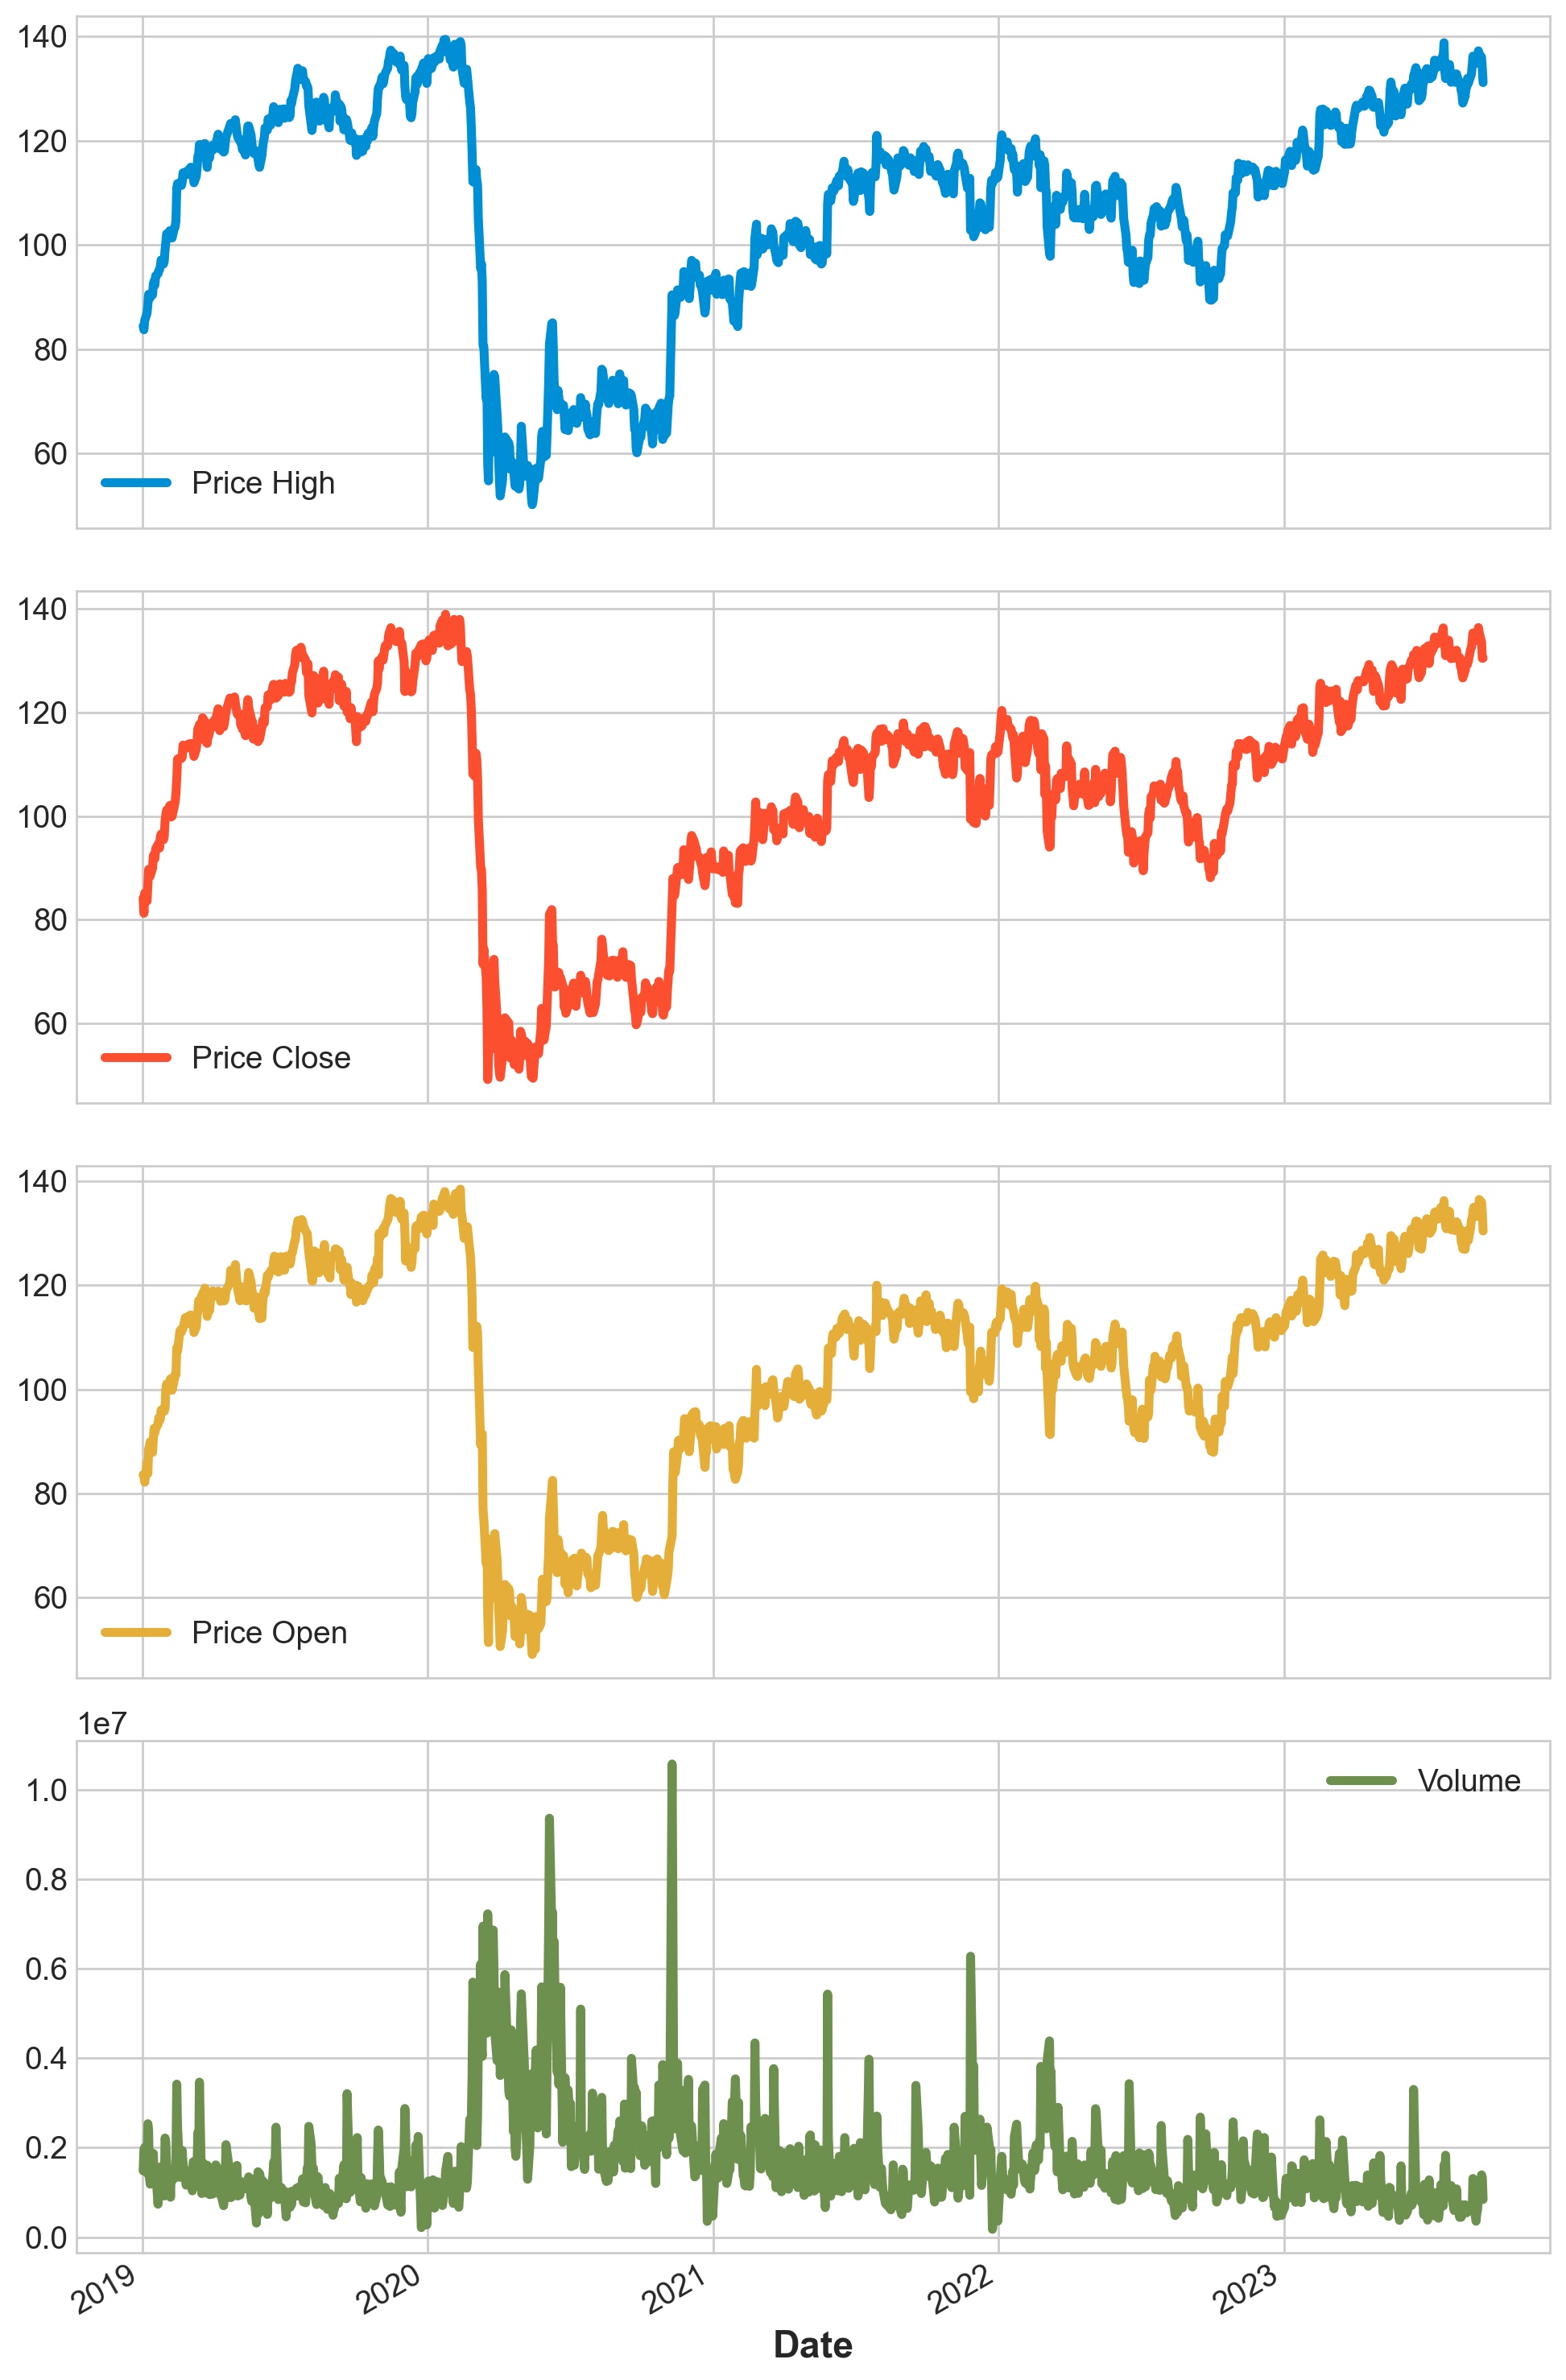

In [7]:
df_stock.plot(subplots=True, figsize=(10,15))
plt.show()

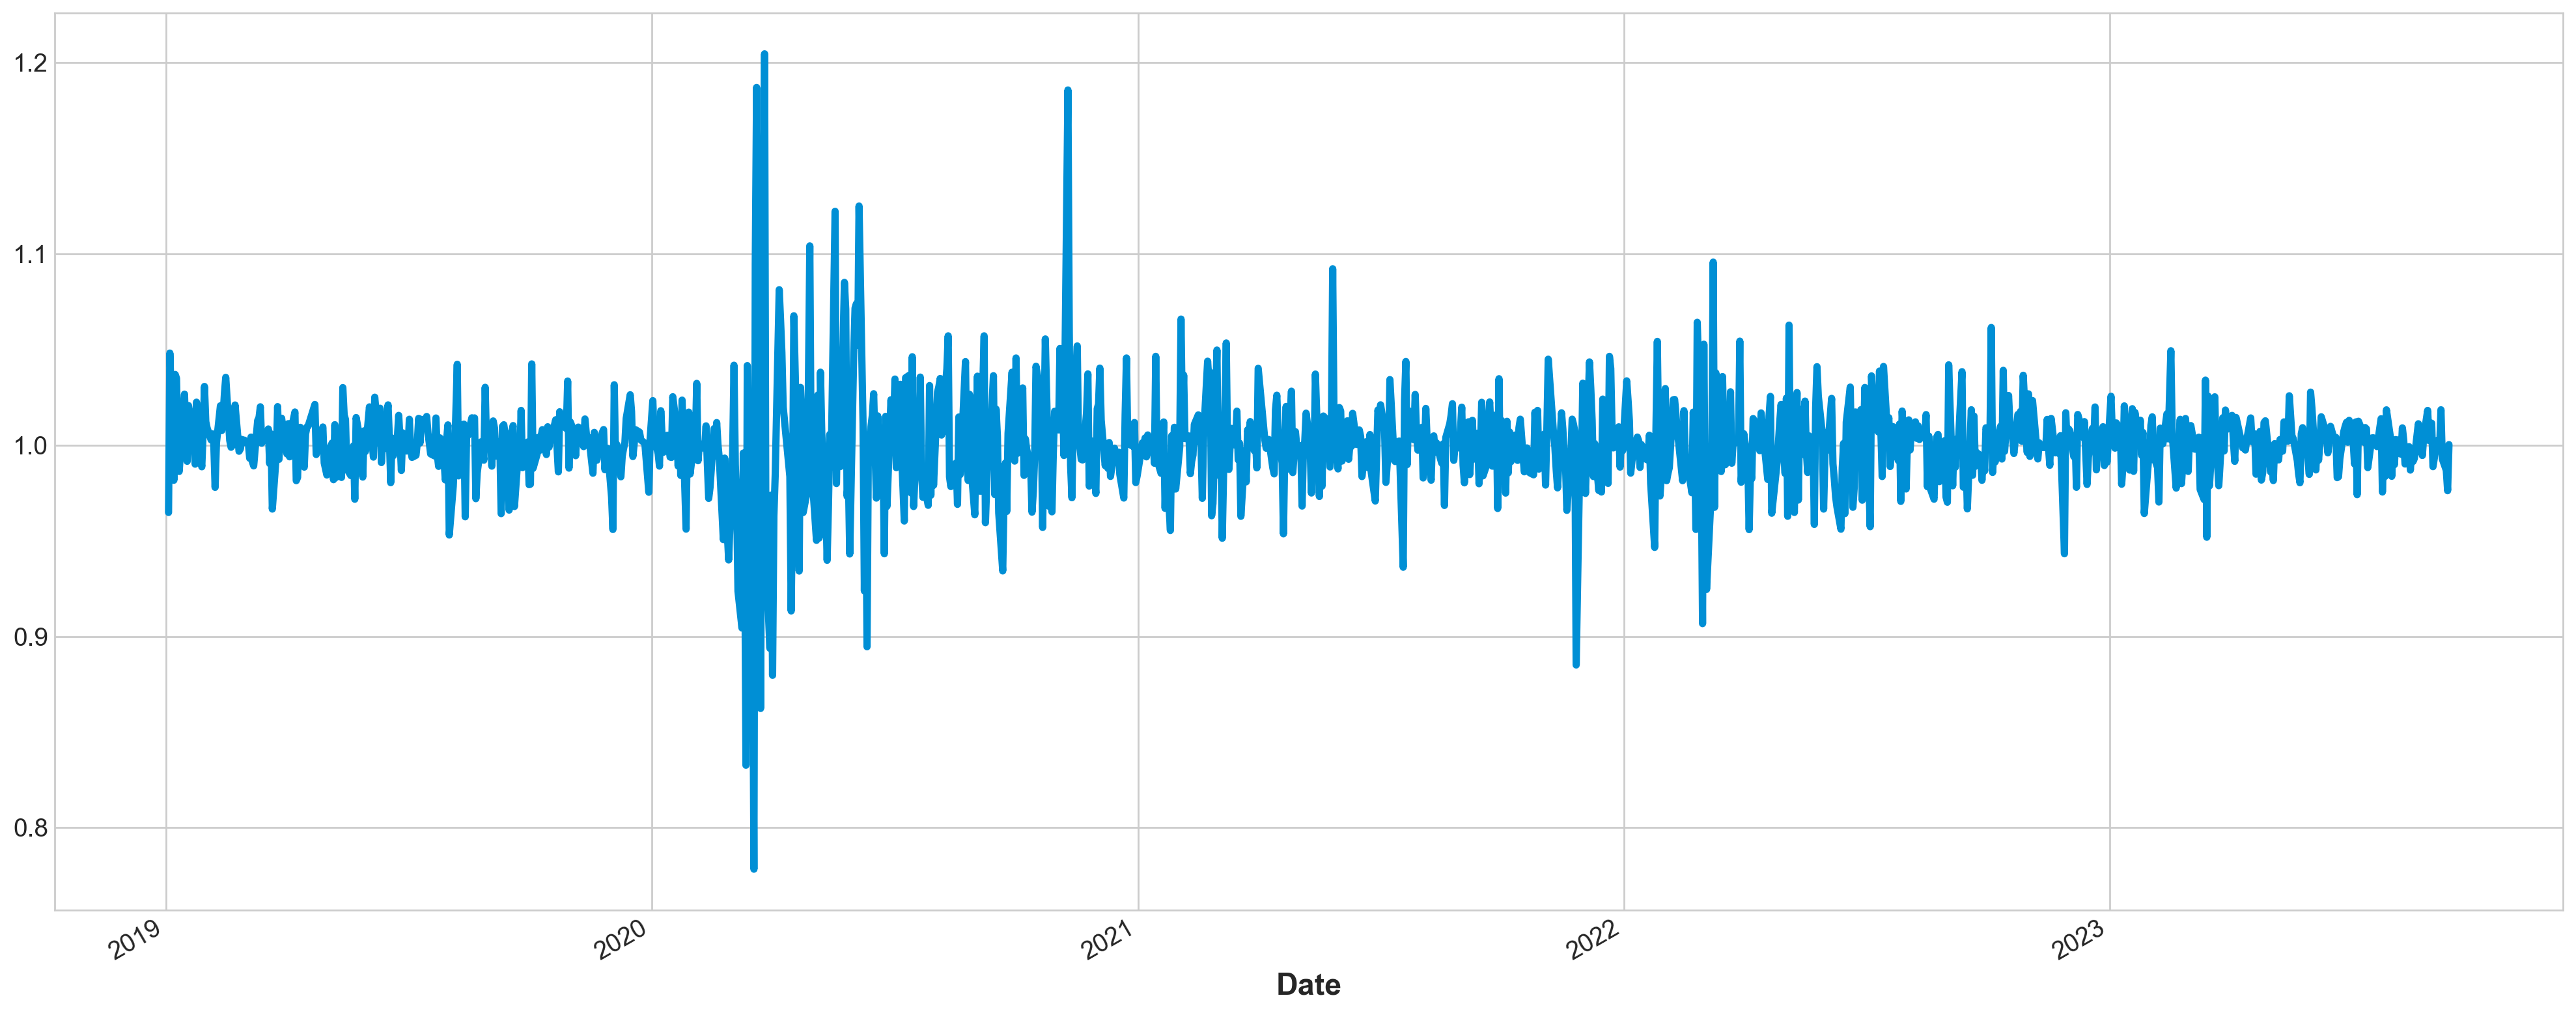

In [8]:
df_stock['Change'] = df_stock['Price Close'].div(df_stock['Price Close'].shift())
df_stock['Change'].plot(figsize=(20,8))
plt.show()

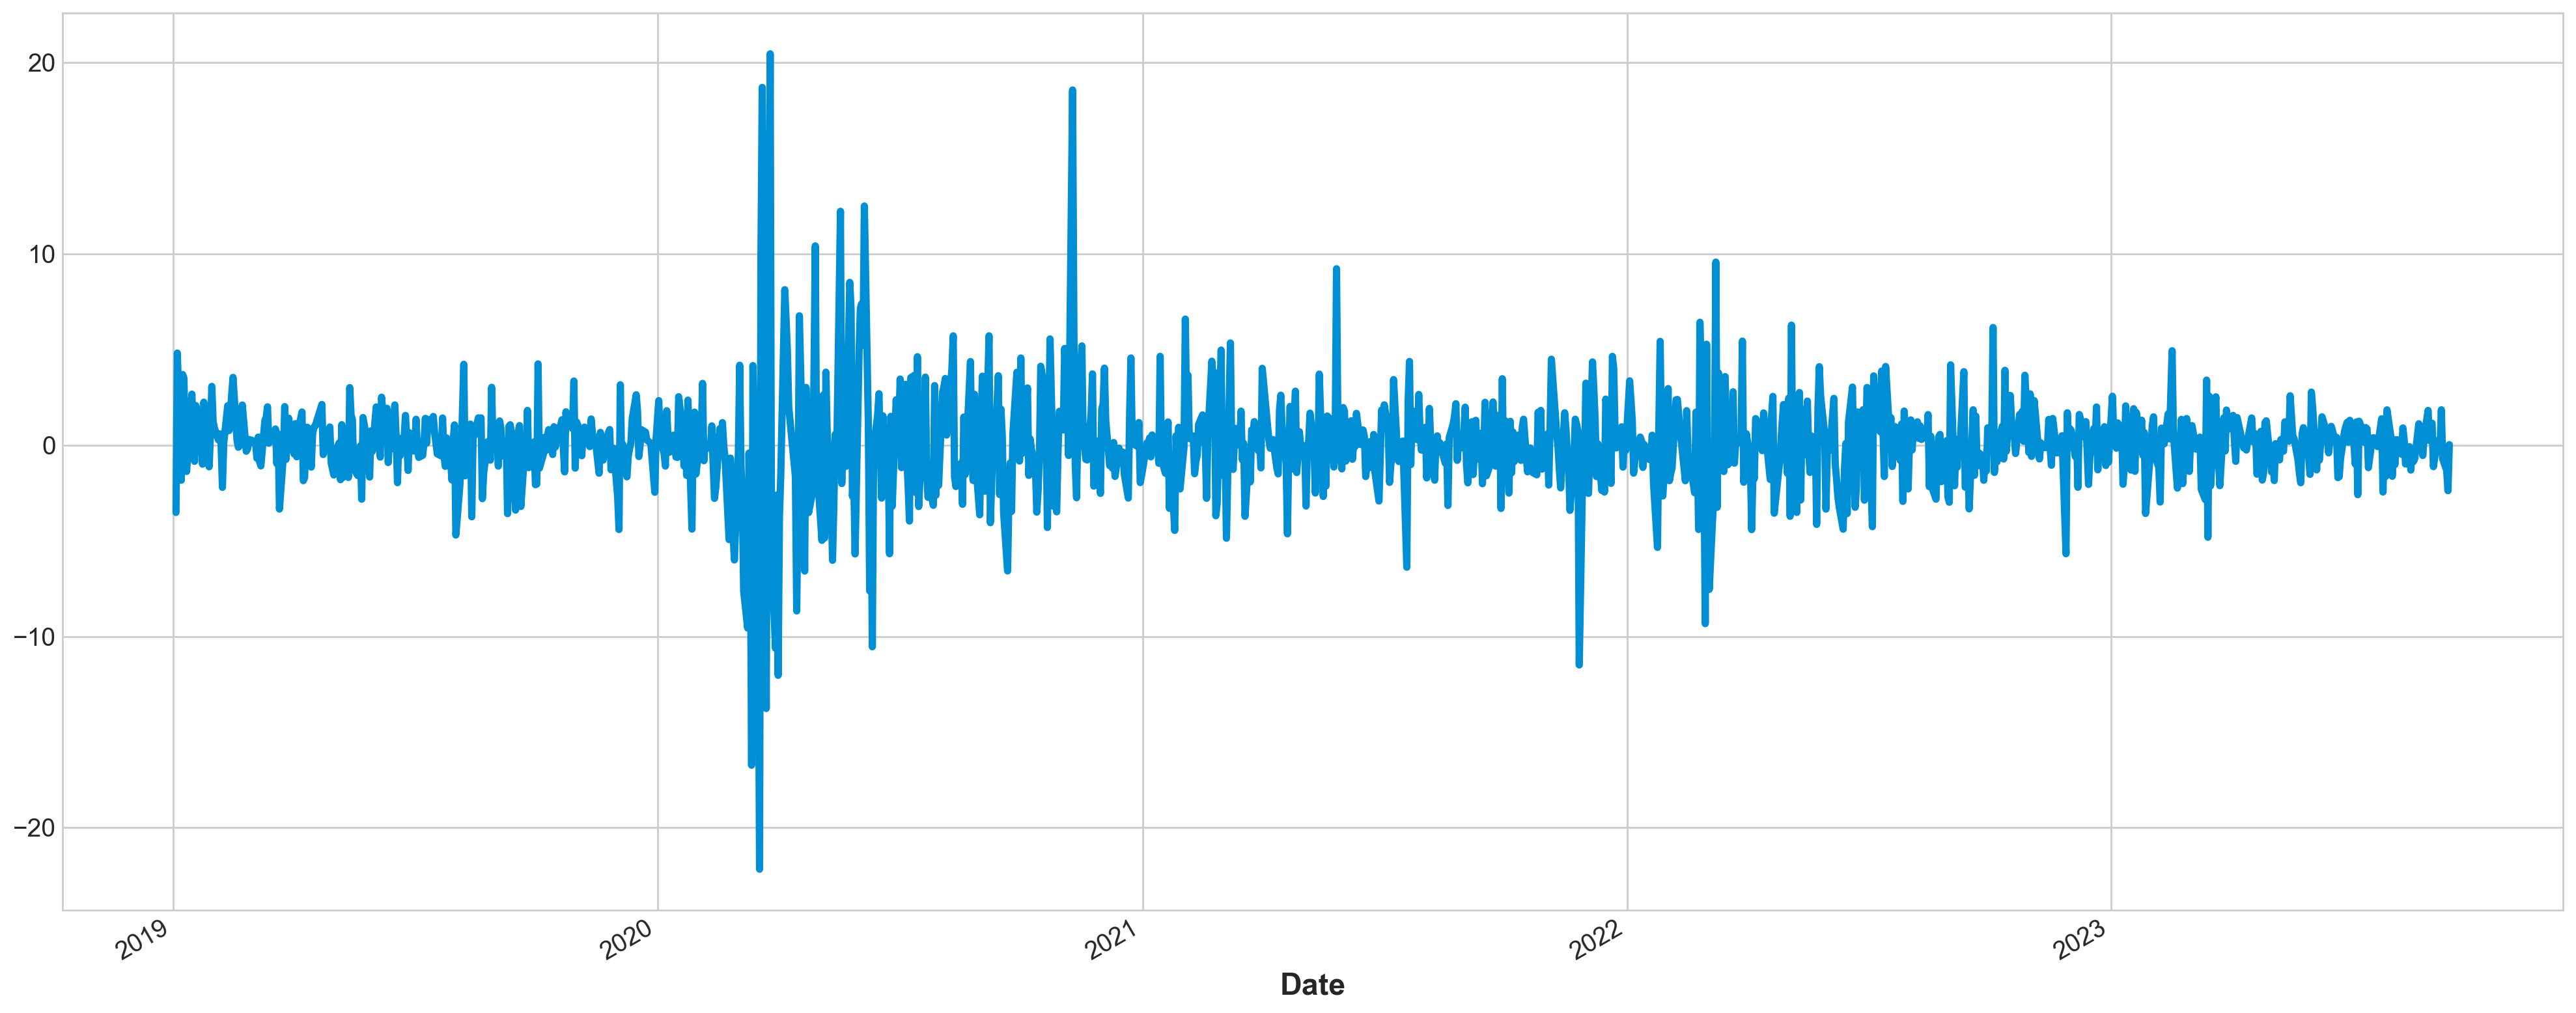

In [9]:
df_stock['Return'] = df_stock['Change'].sub(1).mul(100)
df_stock['Return'].plot(figsize=(20,8))
plt.show()

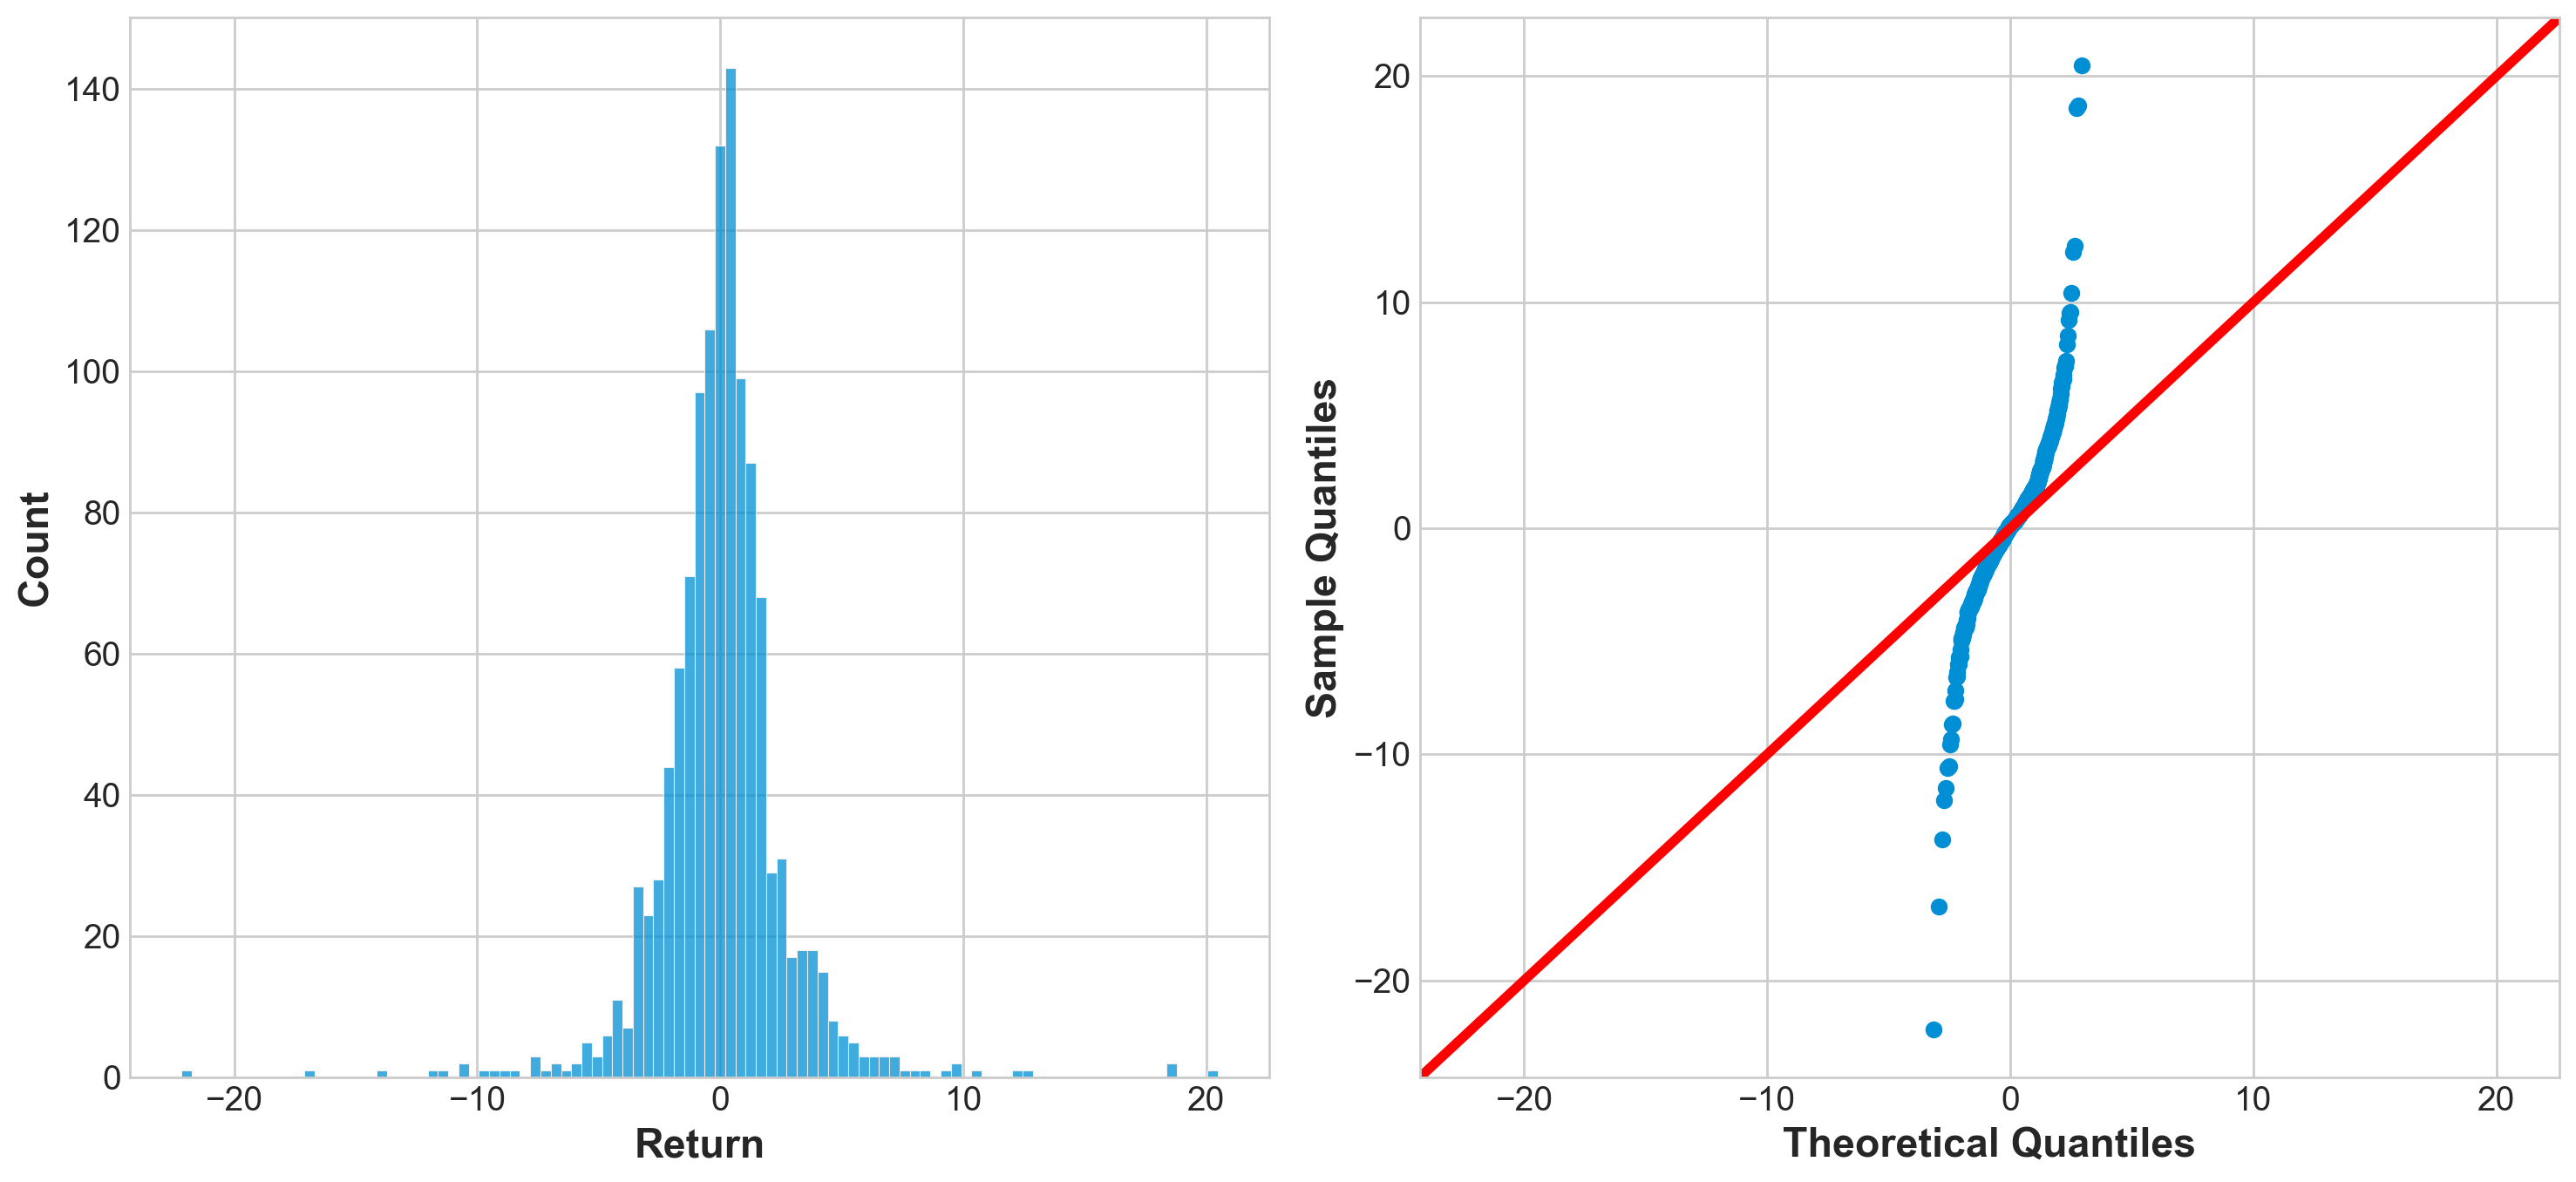

In [10]:
fig,axss = plt.subplots(1, 2, figsize=[15,7])
sns.histplot(x='Return', data=df_stock, ax=axss[0])
sm.qqplot(df_stock['Return'], line='45', ax=axss[1])

# fig = sm.qqplot(df_stock['Return'], line='45')
plt.show()

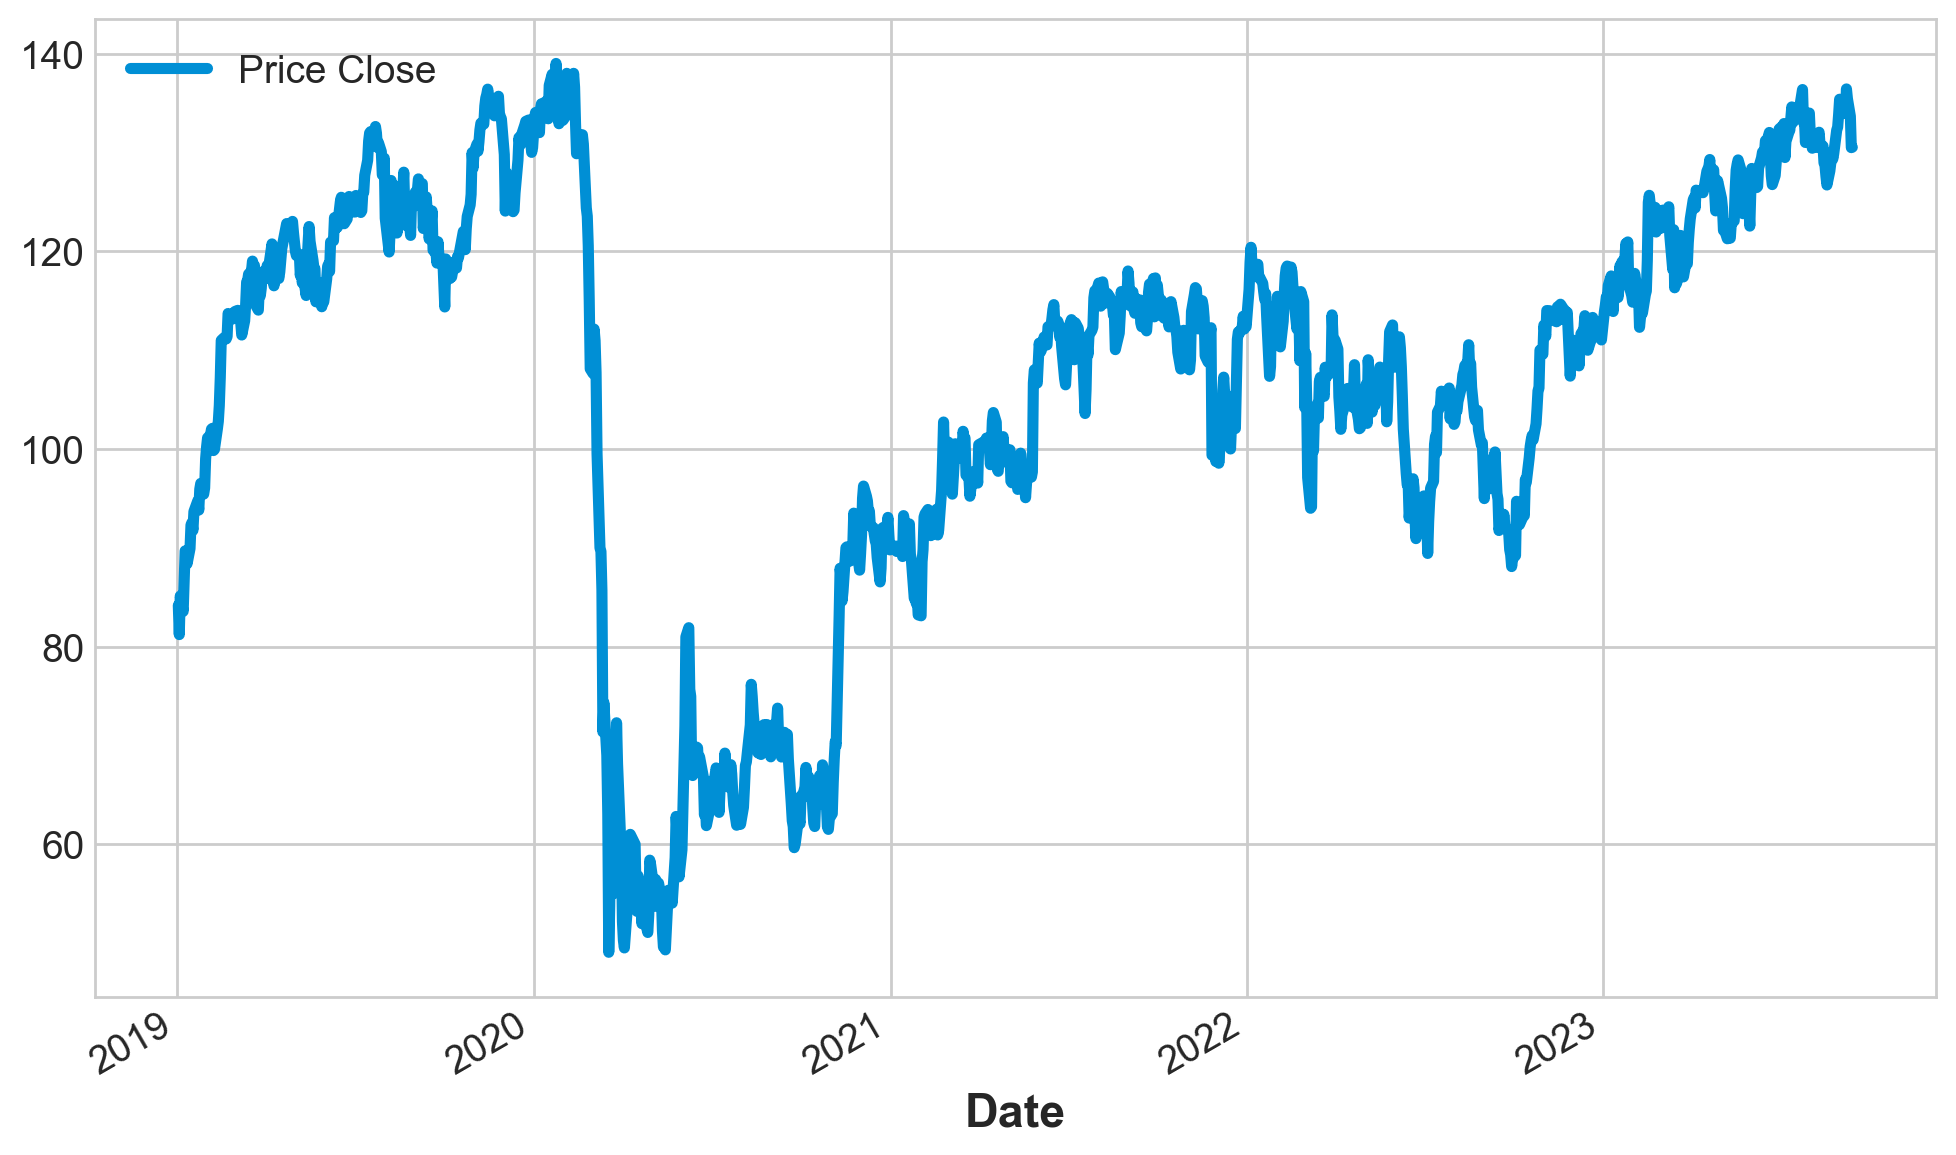

In [11]:
plt.figure(figsize=(10,6))
df_stock['Price Close'].plot()
# df_stock['Price High'].plot()
plt.legend(loc='best')
plt.show()

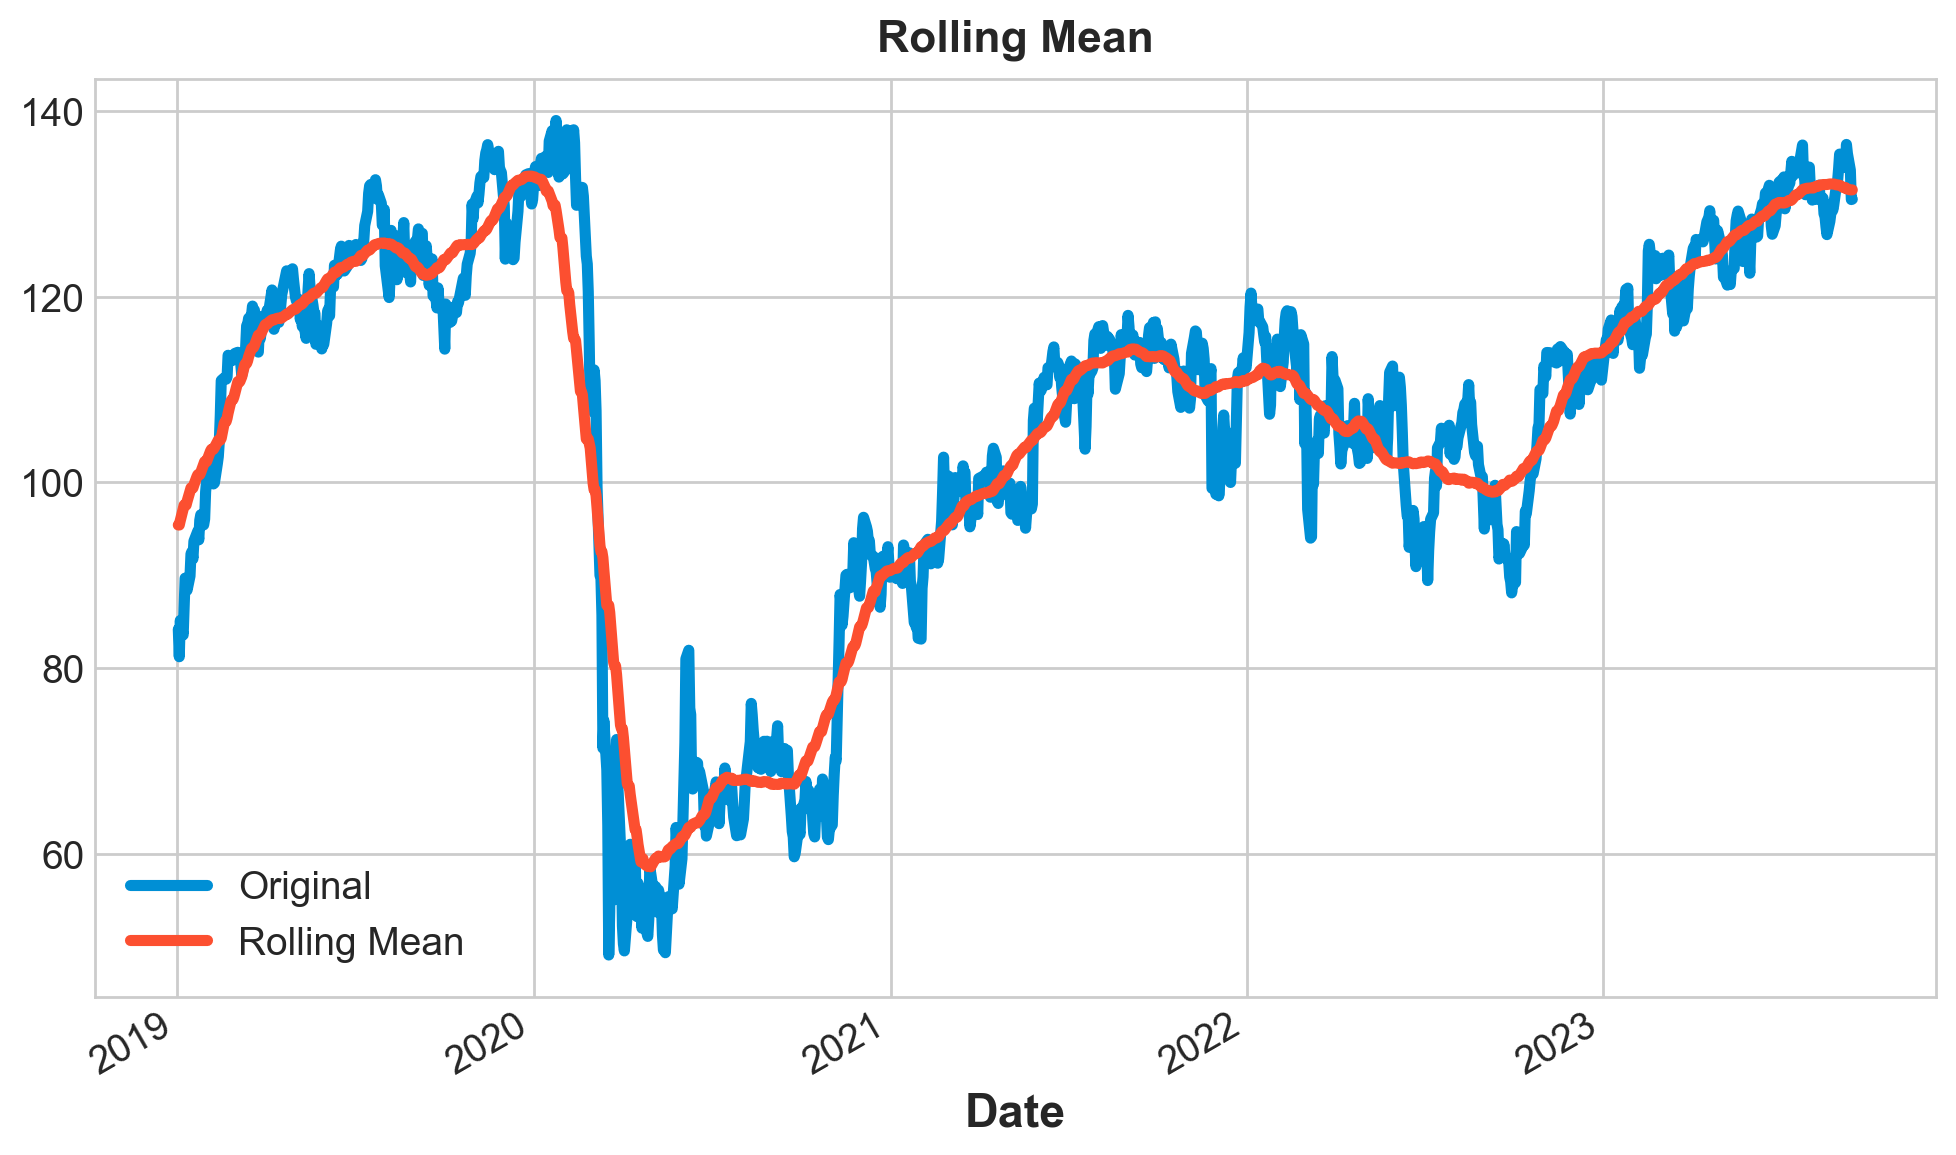

In [12]:
y = df_stock['Price Close'].copy()
plt.figure(figsize=(10,6))
rolling_mean = y.rolling(window='90D',center=True).mean()
y.plot()
rolling_mean.plot()

plt.legend(['Original','Rolling Mean'])
plt.title('Rolling Mean')
plt.show()

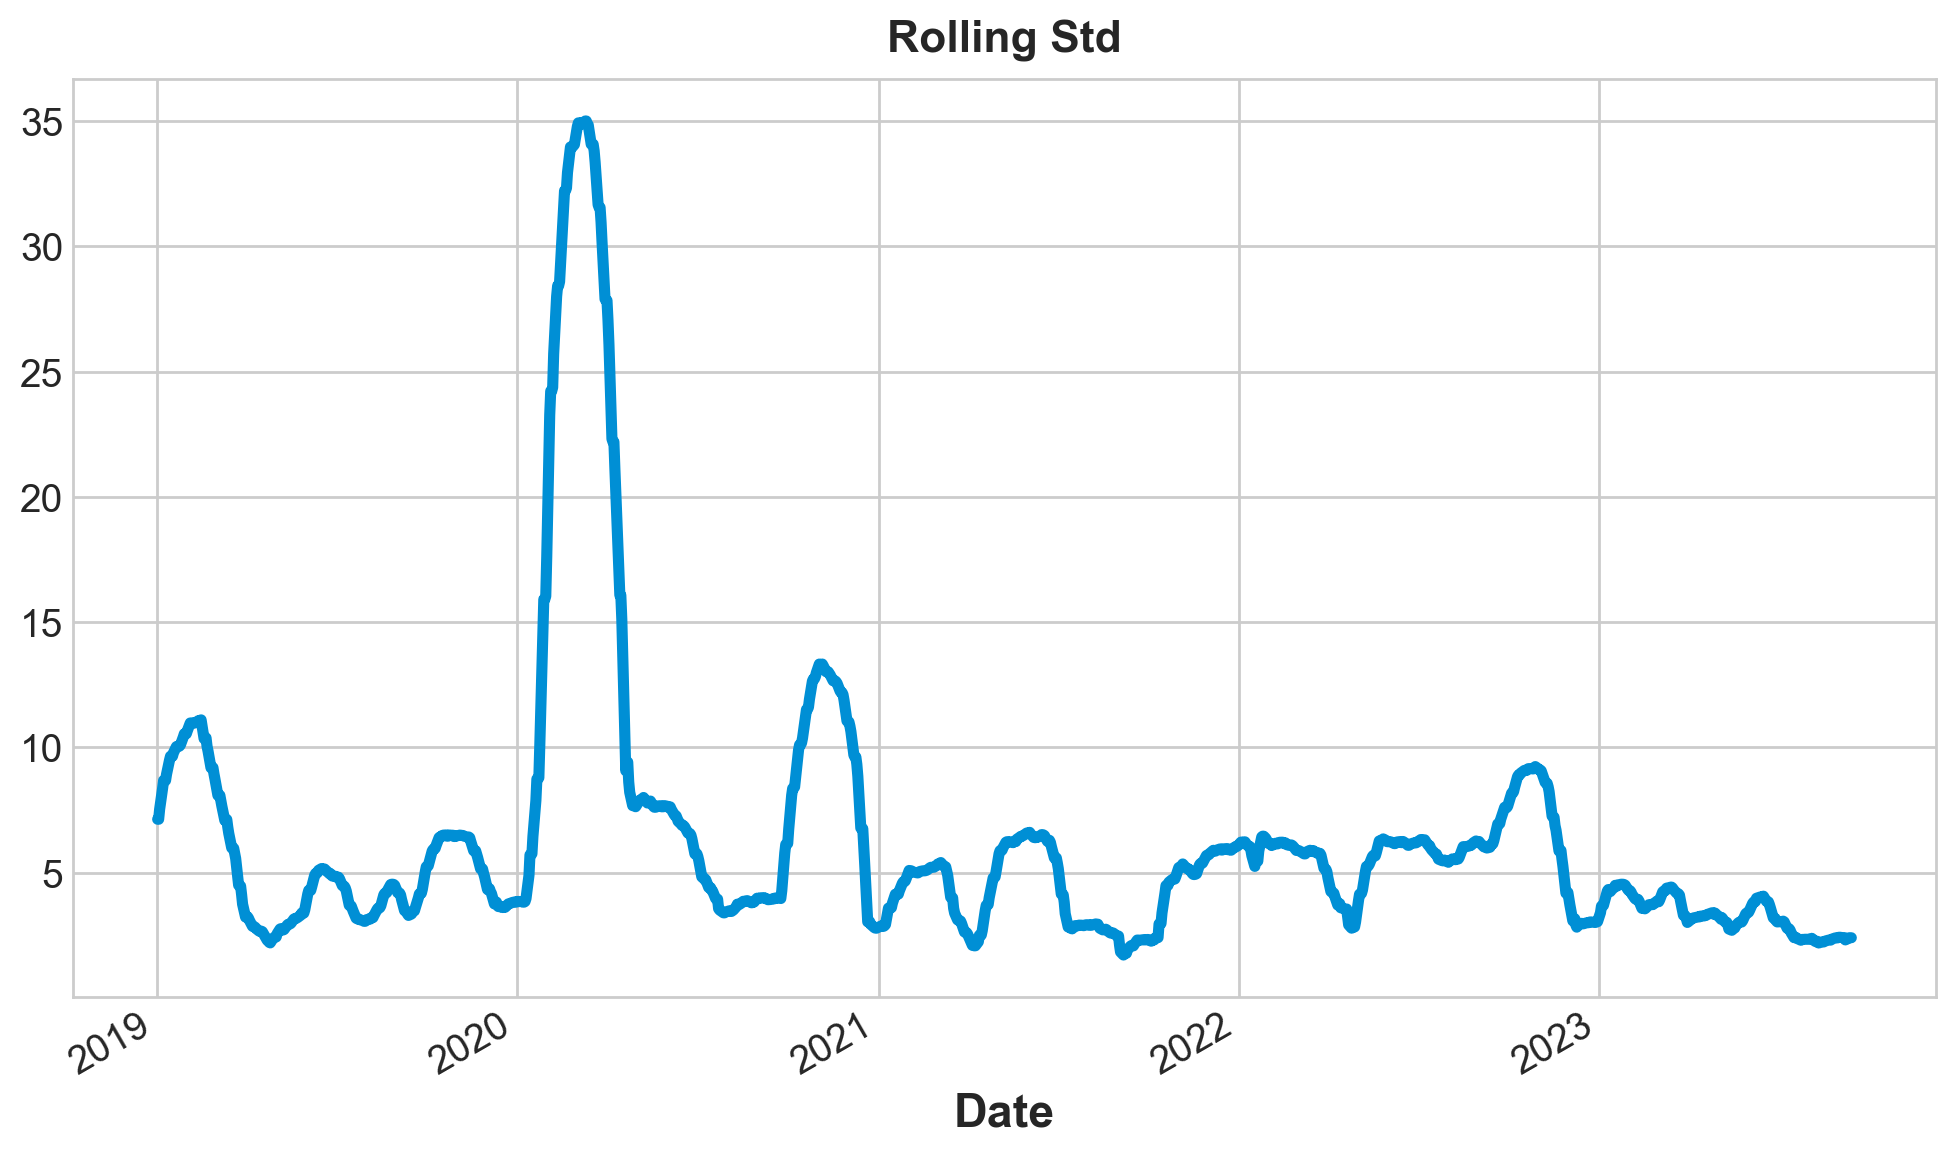

In [13]:
plt.figure(figsize=(10,6))
rolling_std = y.rolling(window='90D',center=True).std()
rolling_std.plot()
plt.title('Rolling Std')
plt.show()

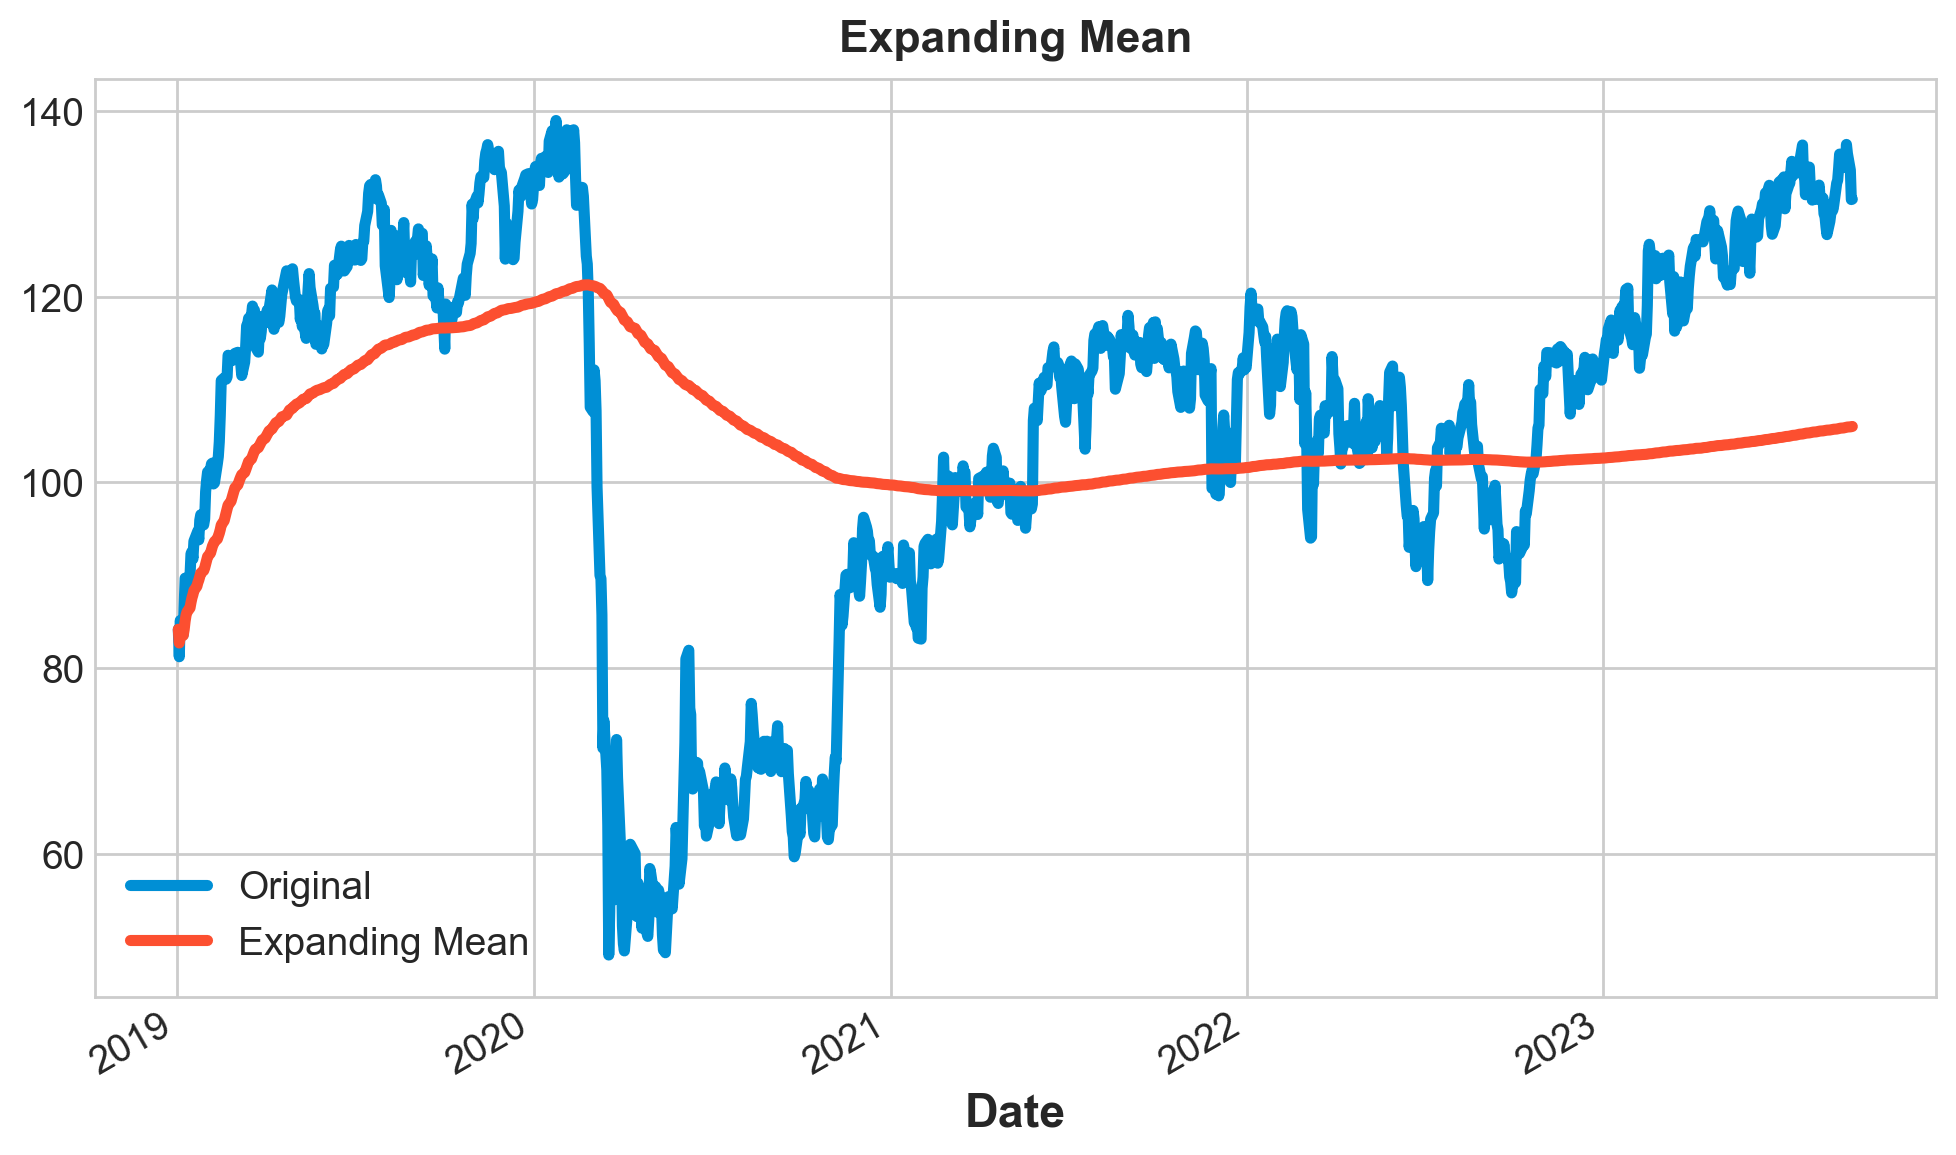

In [14]:
plt.figure(figsize=(10,6))
expanding_mean = y.expanding().mean()
y.plot()
expanding_mean.plot()
plt.title('Expanding Mean')
plt.legend(['Original','Expanding Mean'])
plt.show()

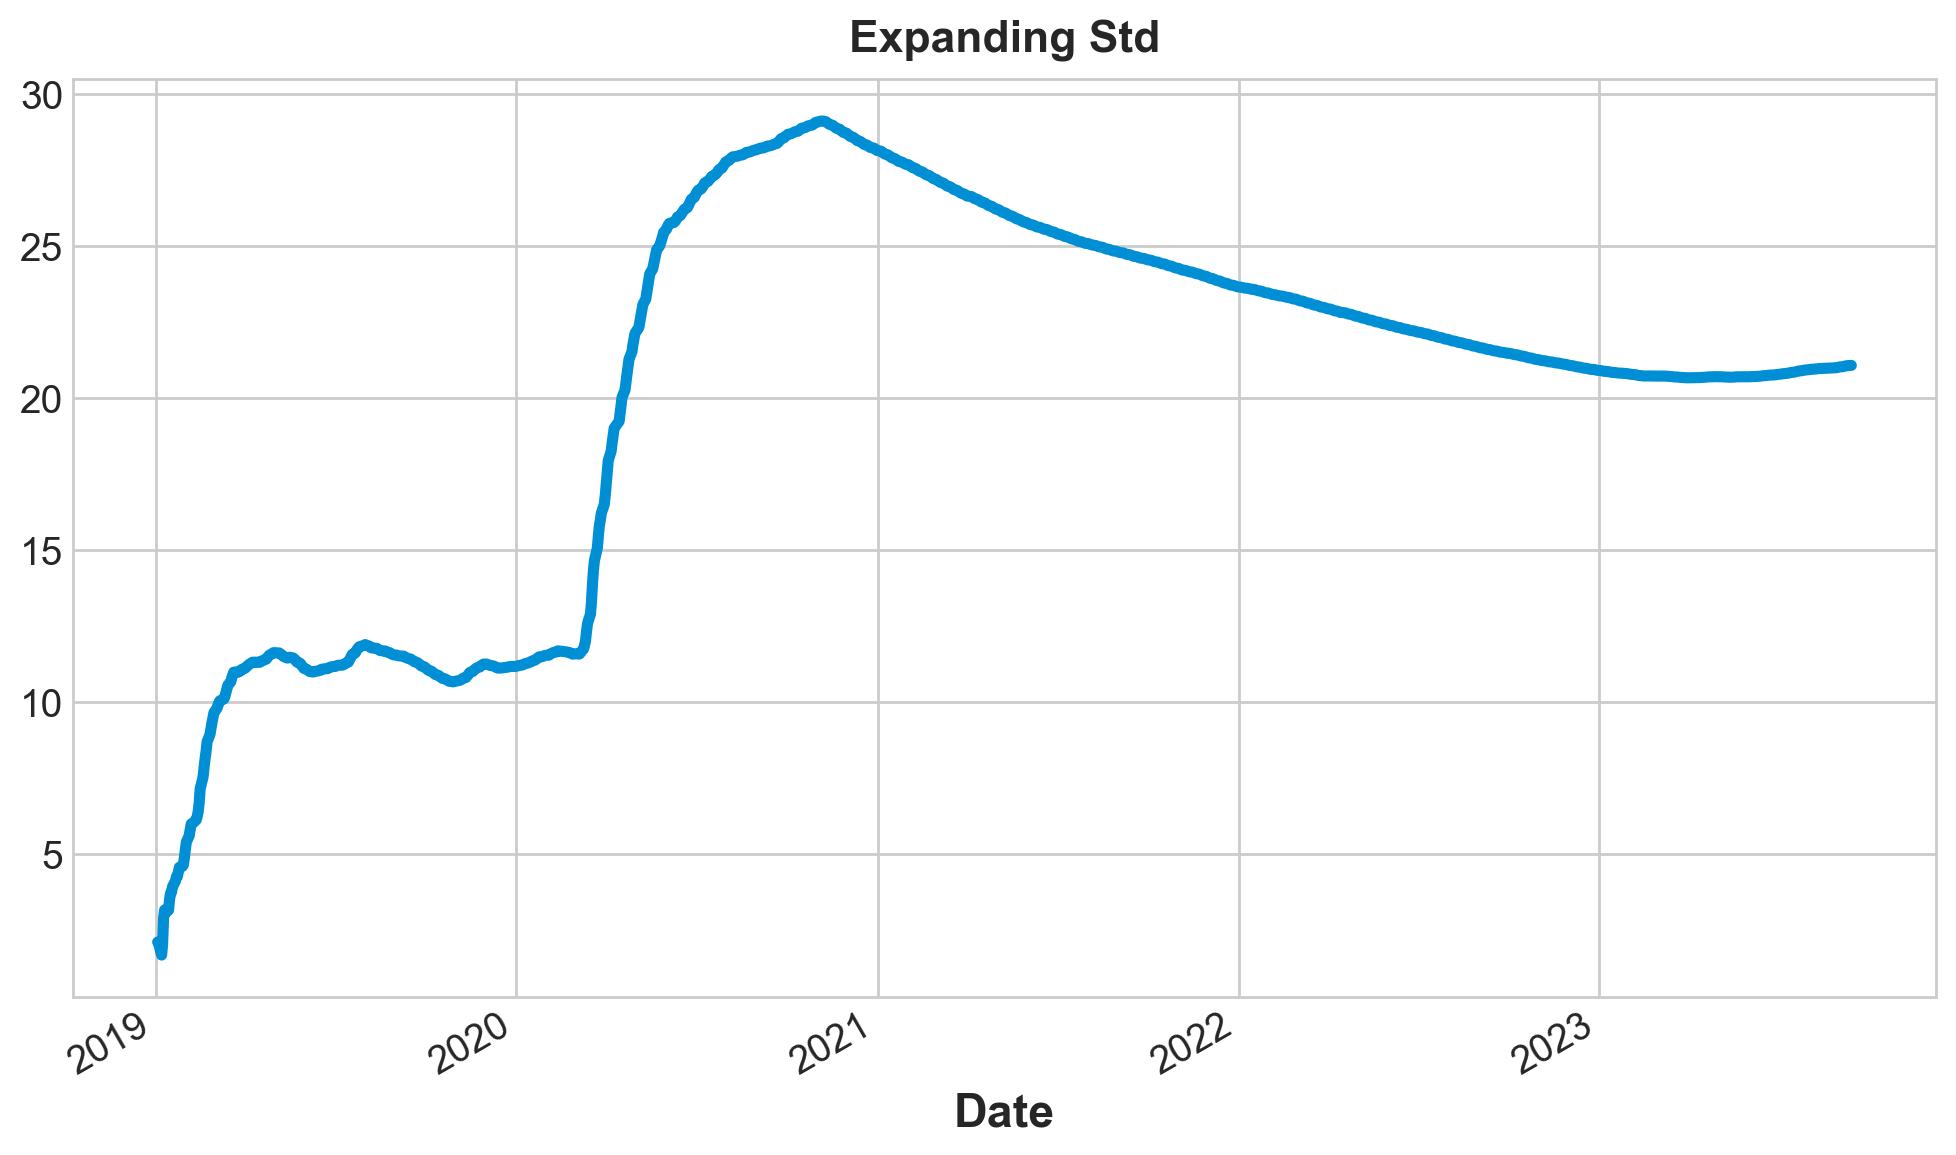

In [15]:
plt.figure(figsize=(10,6))
expanding_std = y.expanding().std()
expanding_std.plot()
plt.title('Expanding Std')
plt.show()

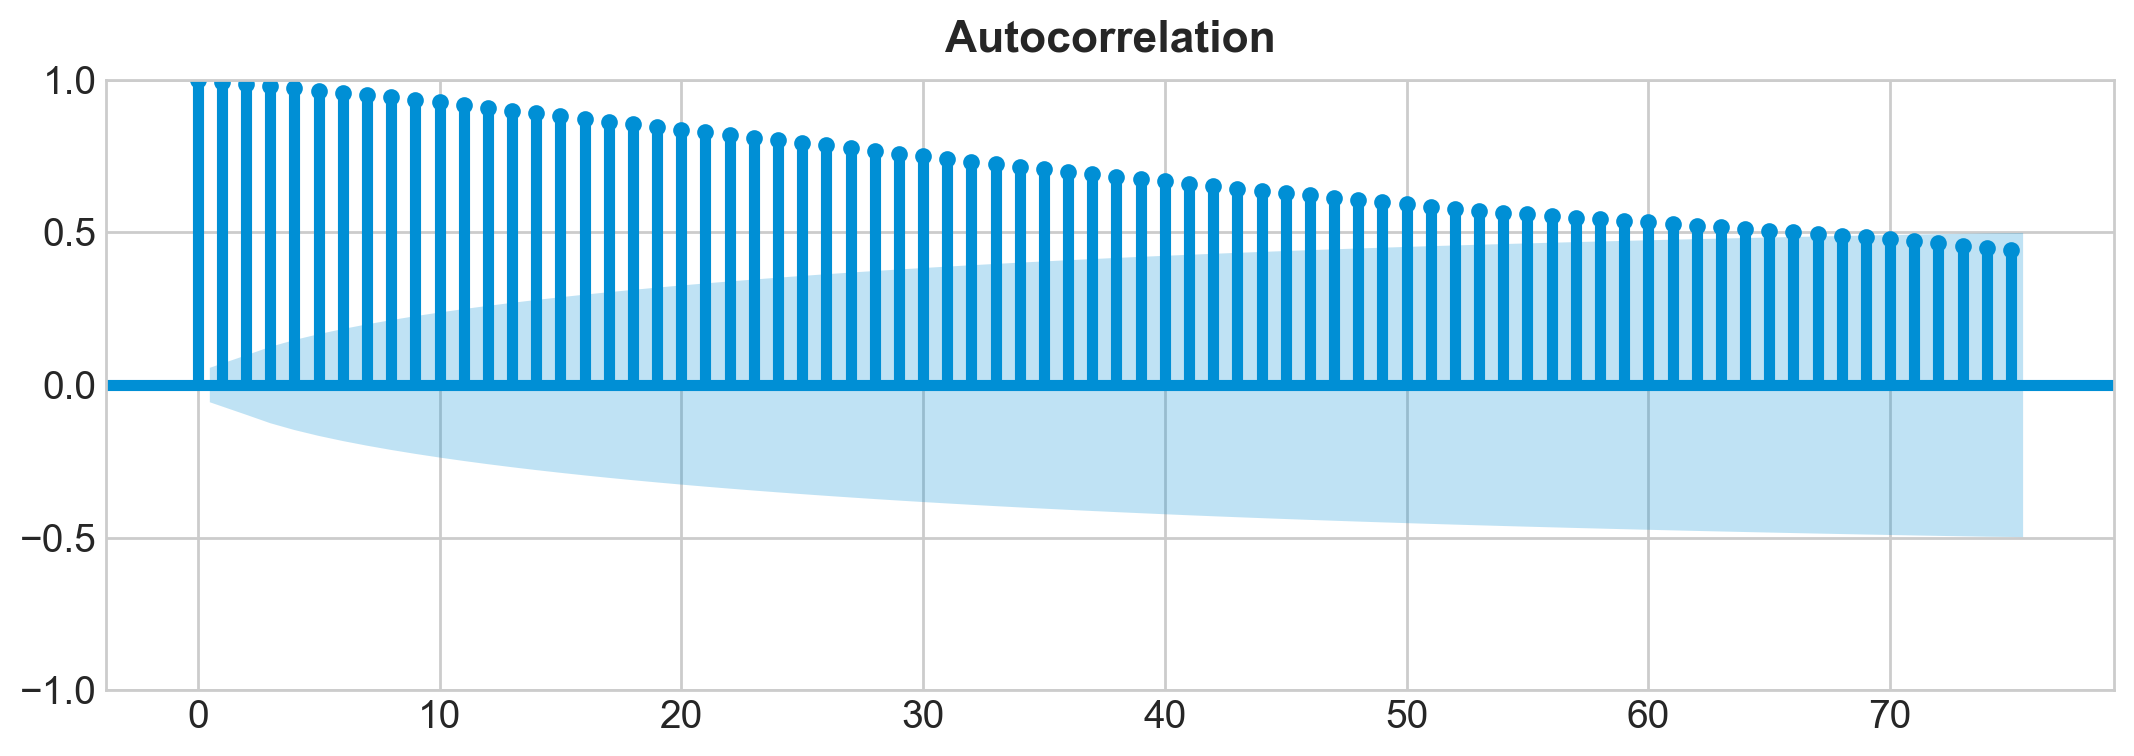

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# plt.figure(figsize=(10,6))
plot_acf(y,lags=75)
plt.show()

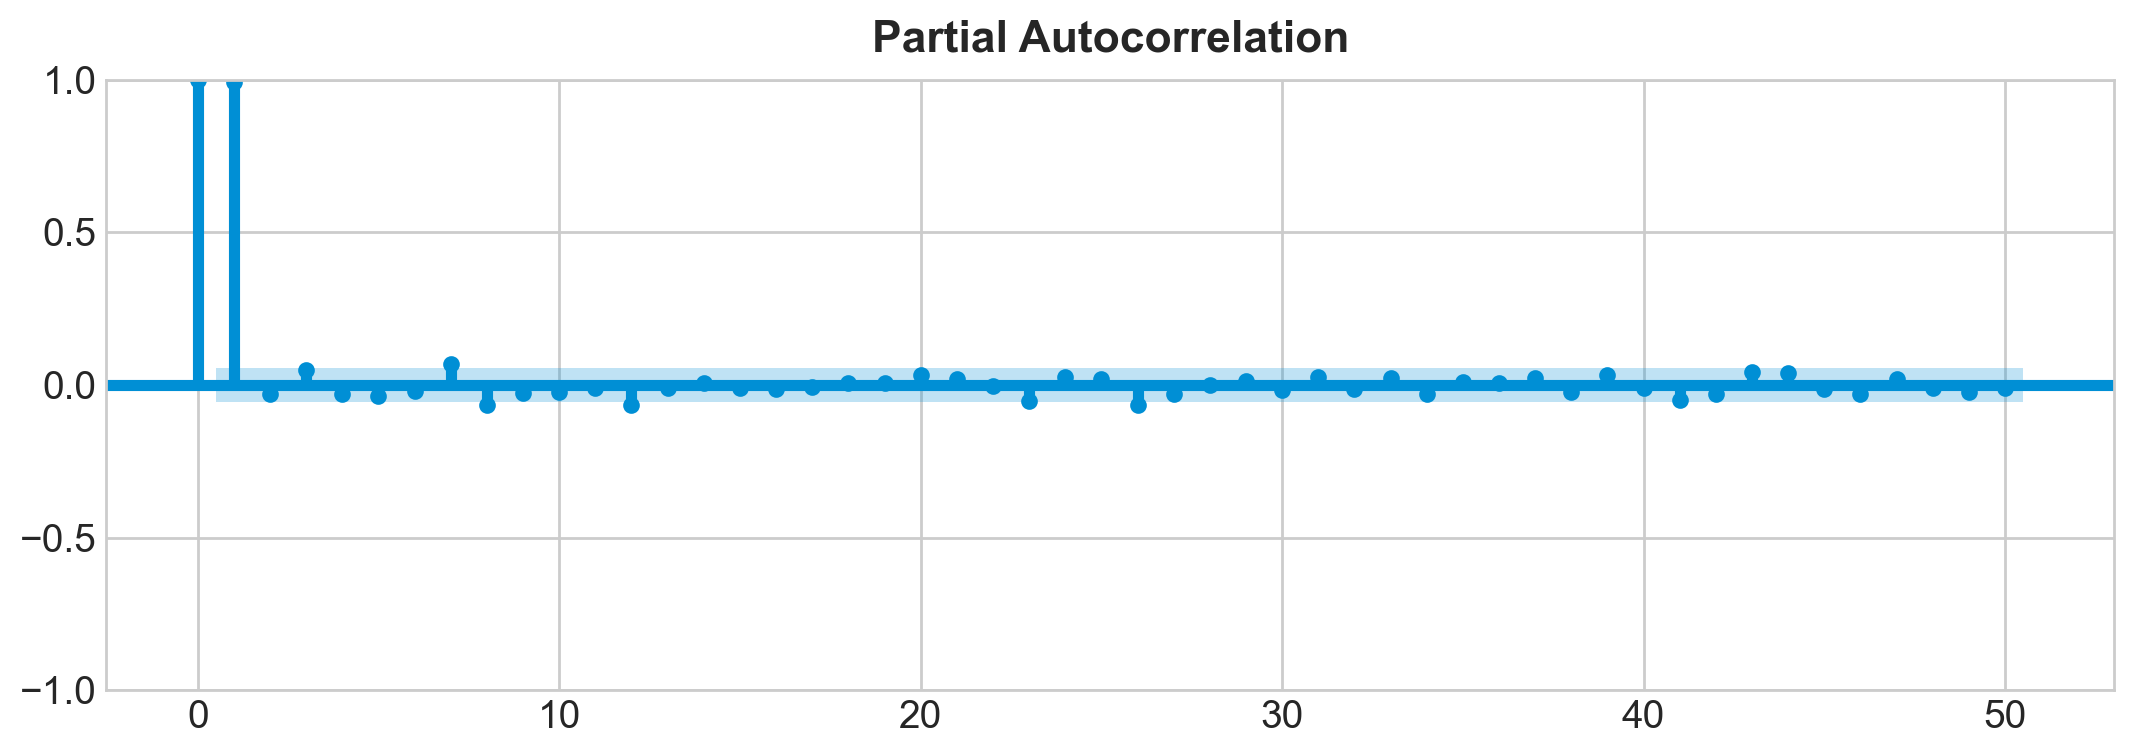

In [17]:
plot_pacf(y,lags=50)
plt.show()

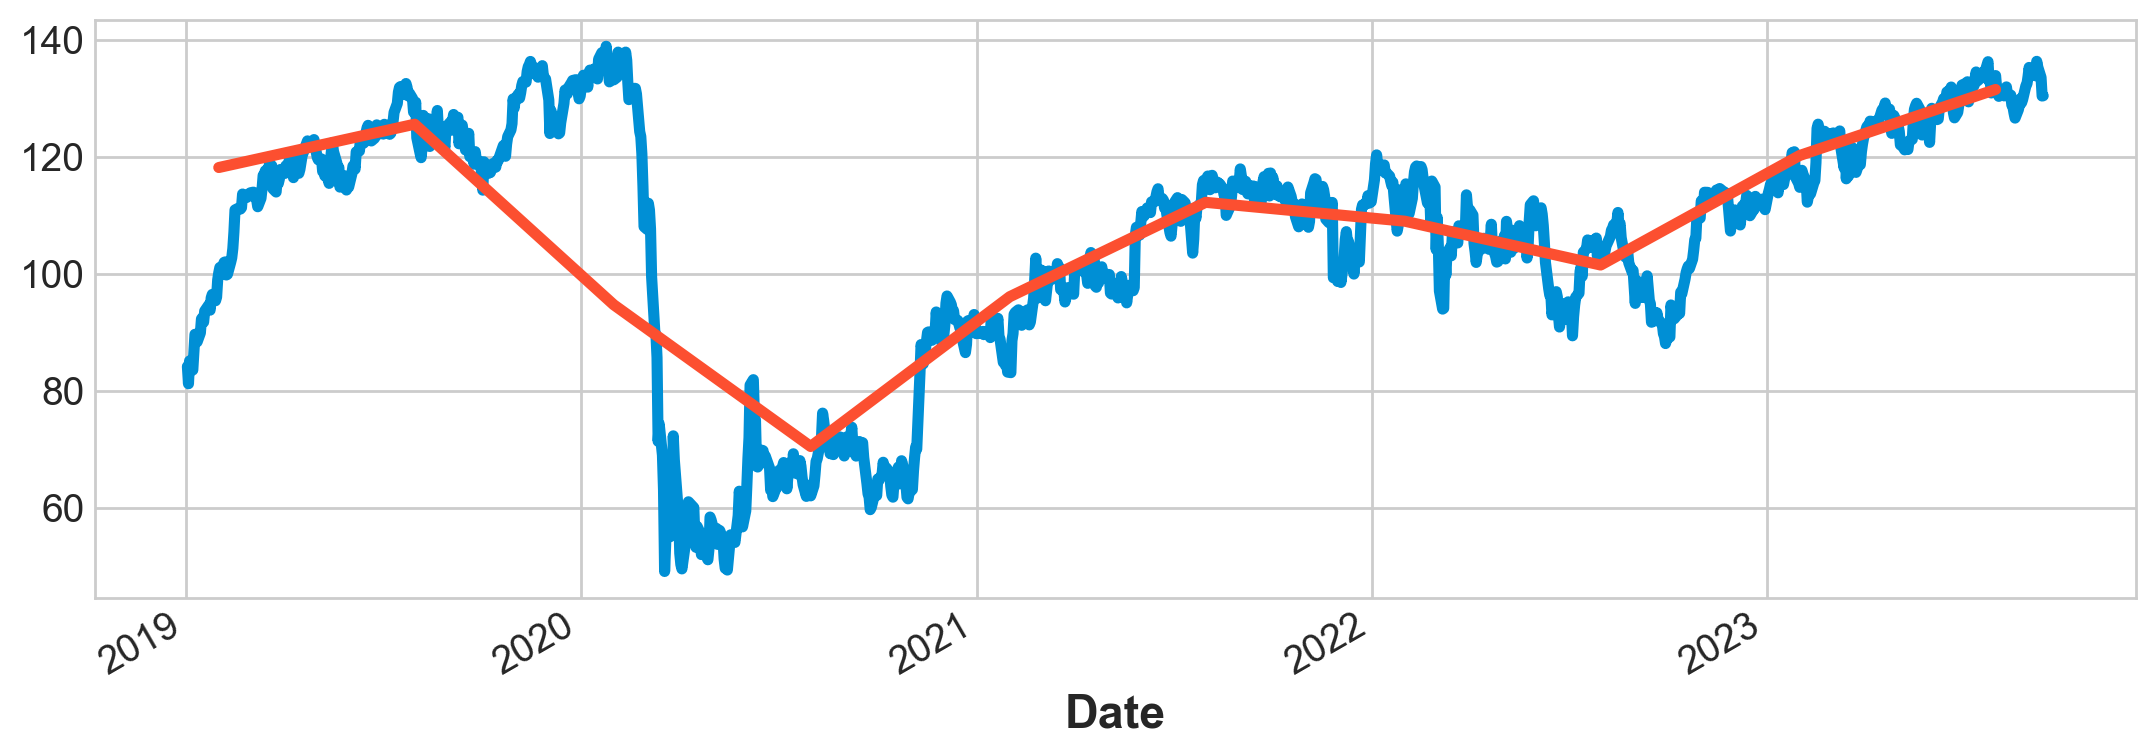

In [18]:
df_stock['Price Close'].plot()
df_stock['Price Close'].shift(-90).resample('6M').mean().plot()
plt.show()

# Data Cleaning and Feature Analysis

## Data Description

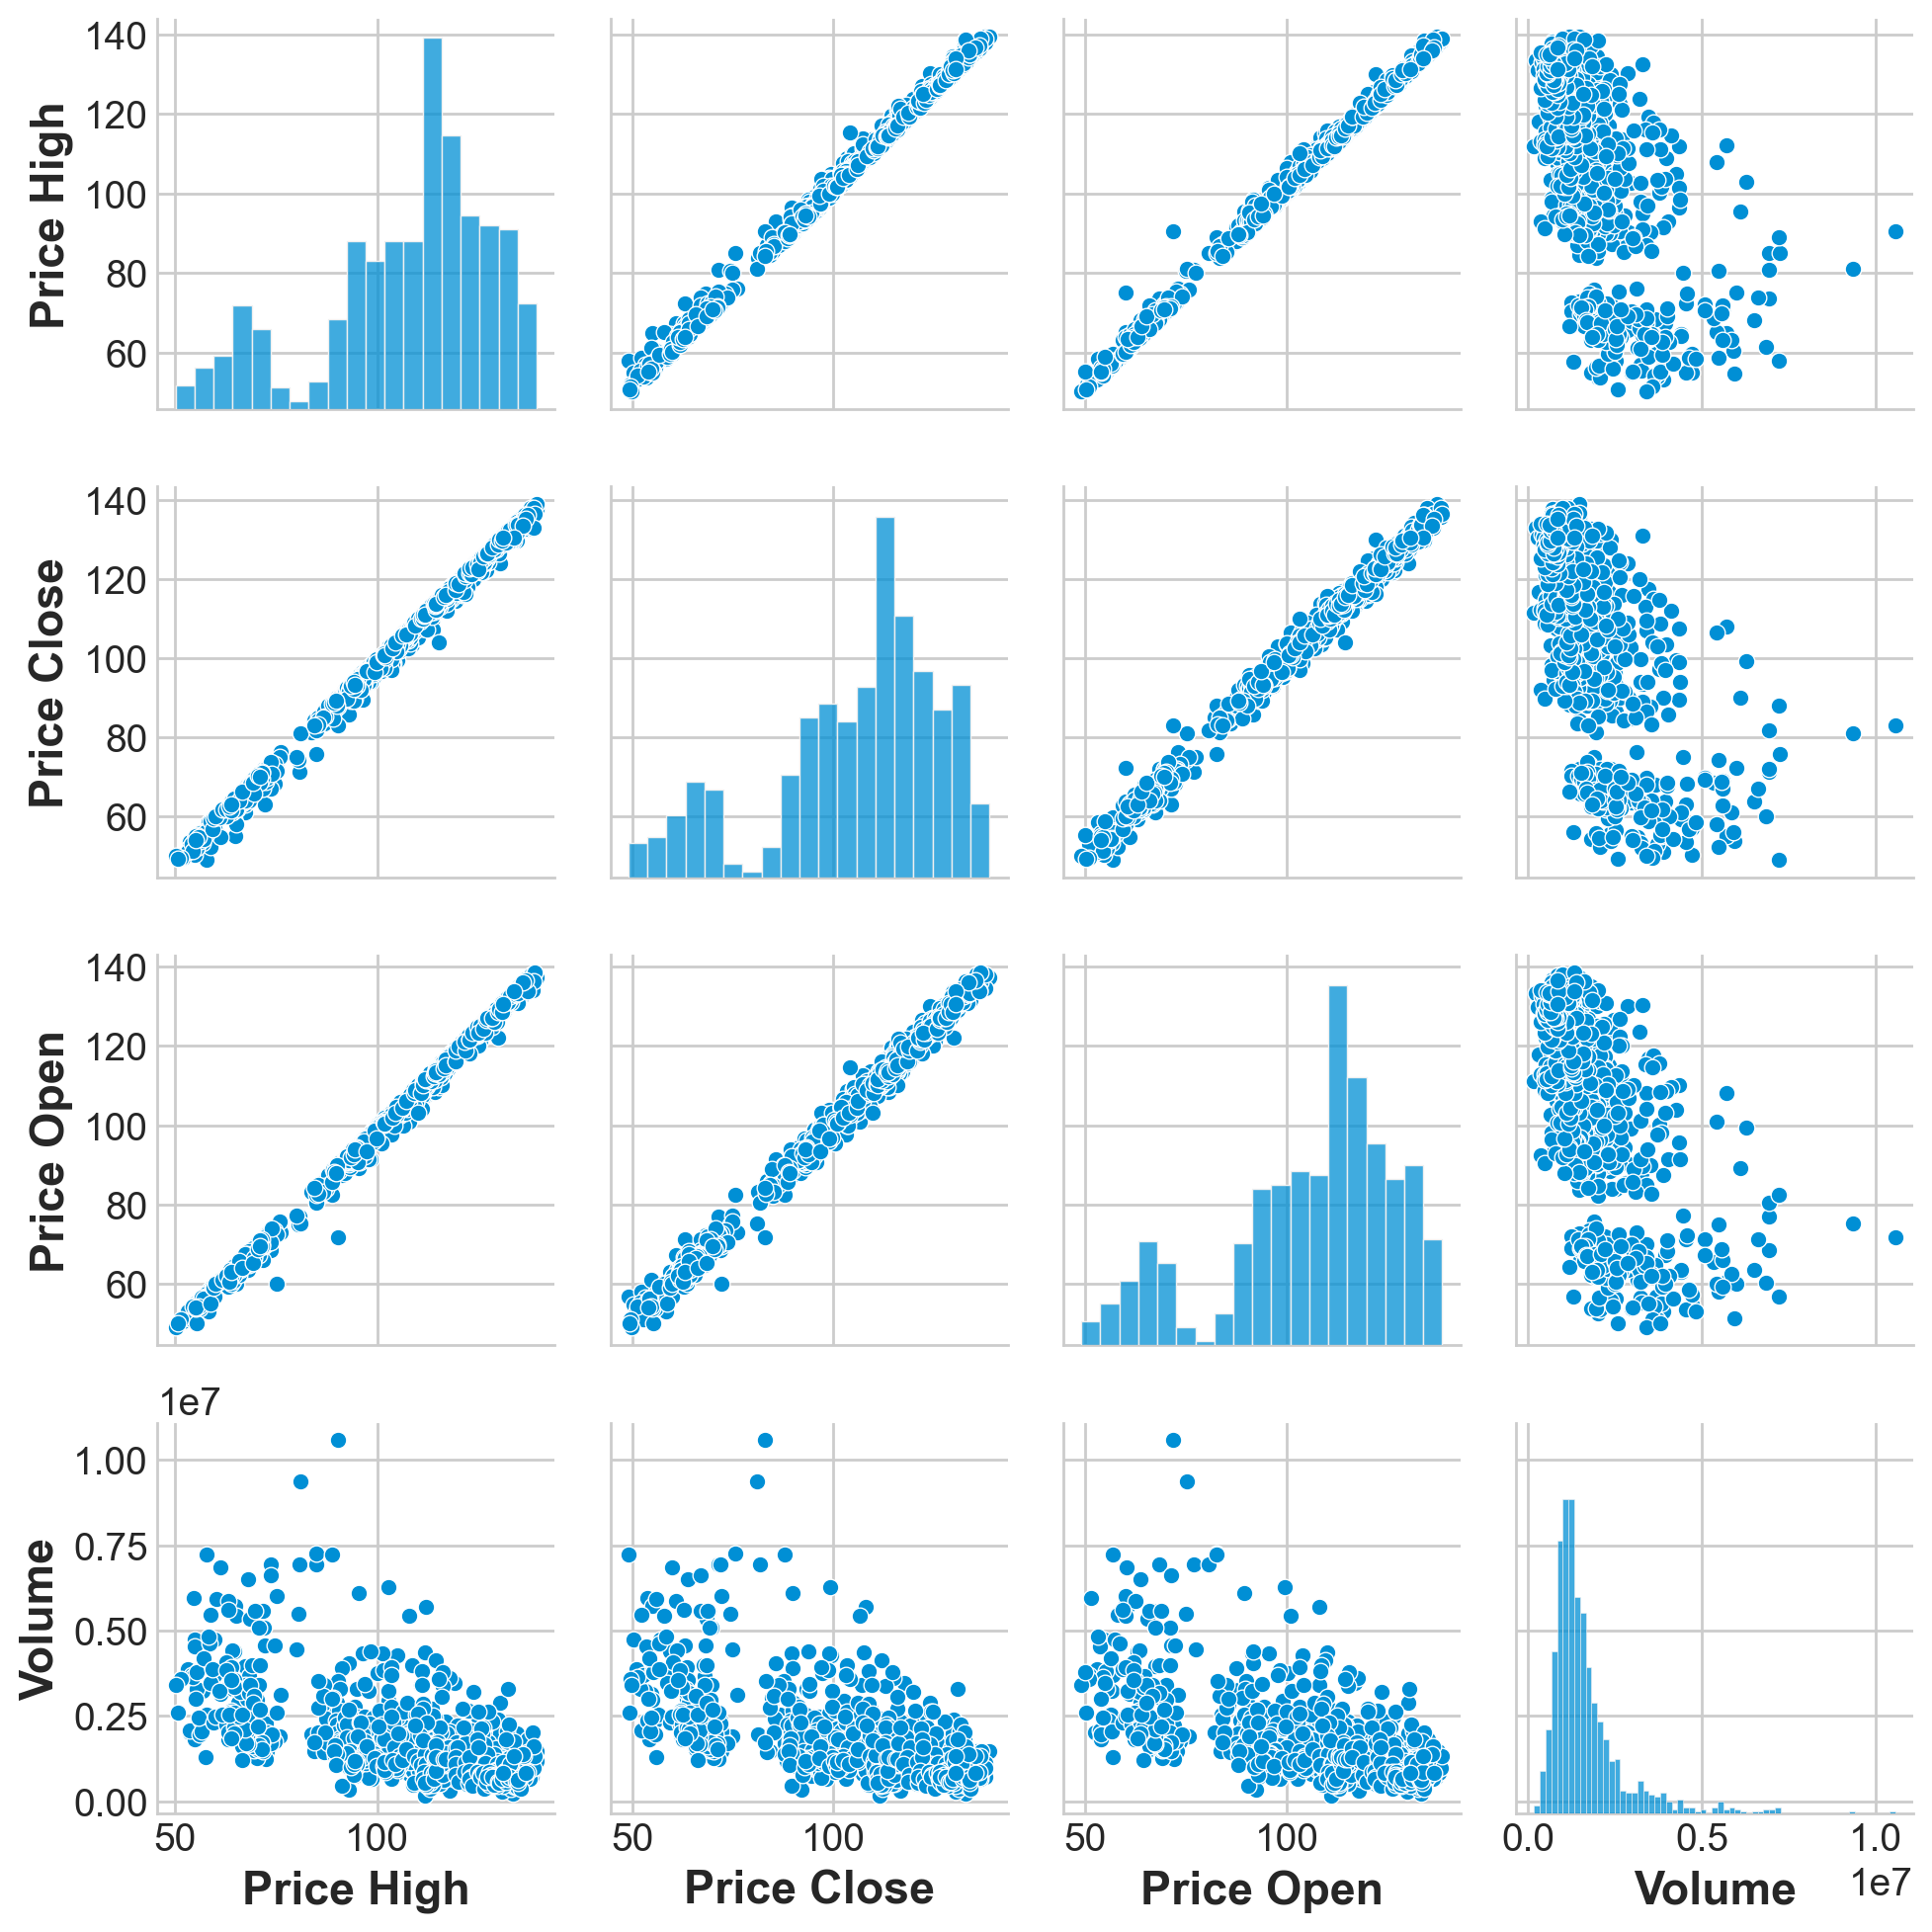

In [19]:
df_stock1 = df_stock.copy()
df_stock = df_stock.loc[:,:'Volume']
sns.pairplot(data=df_stock)
plt.show()

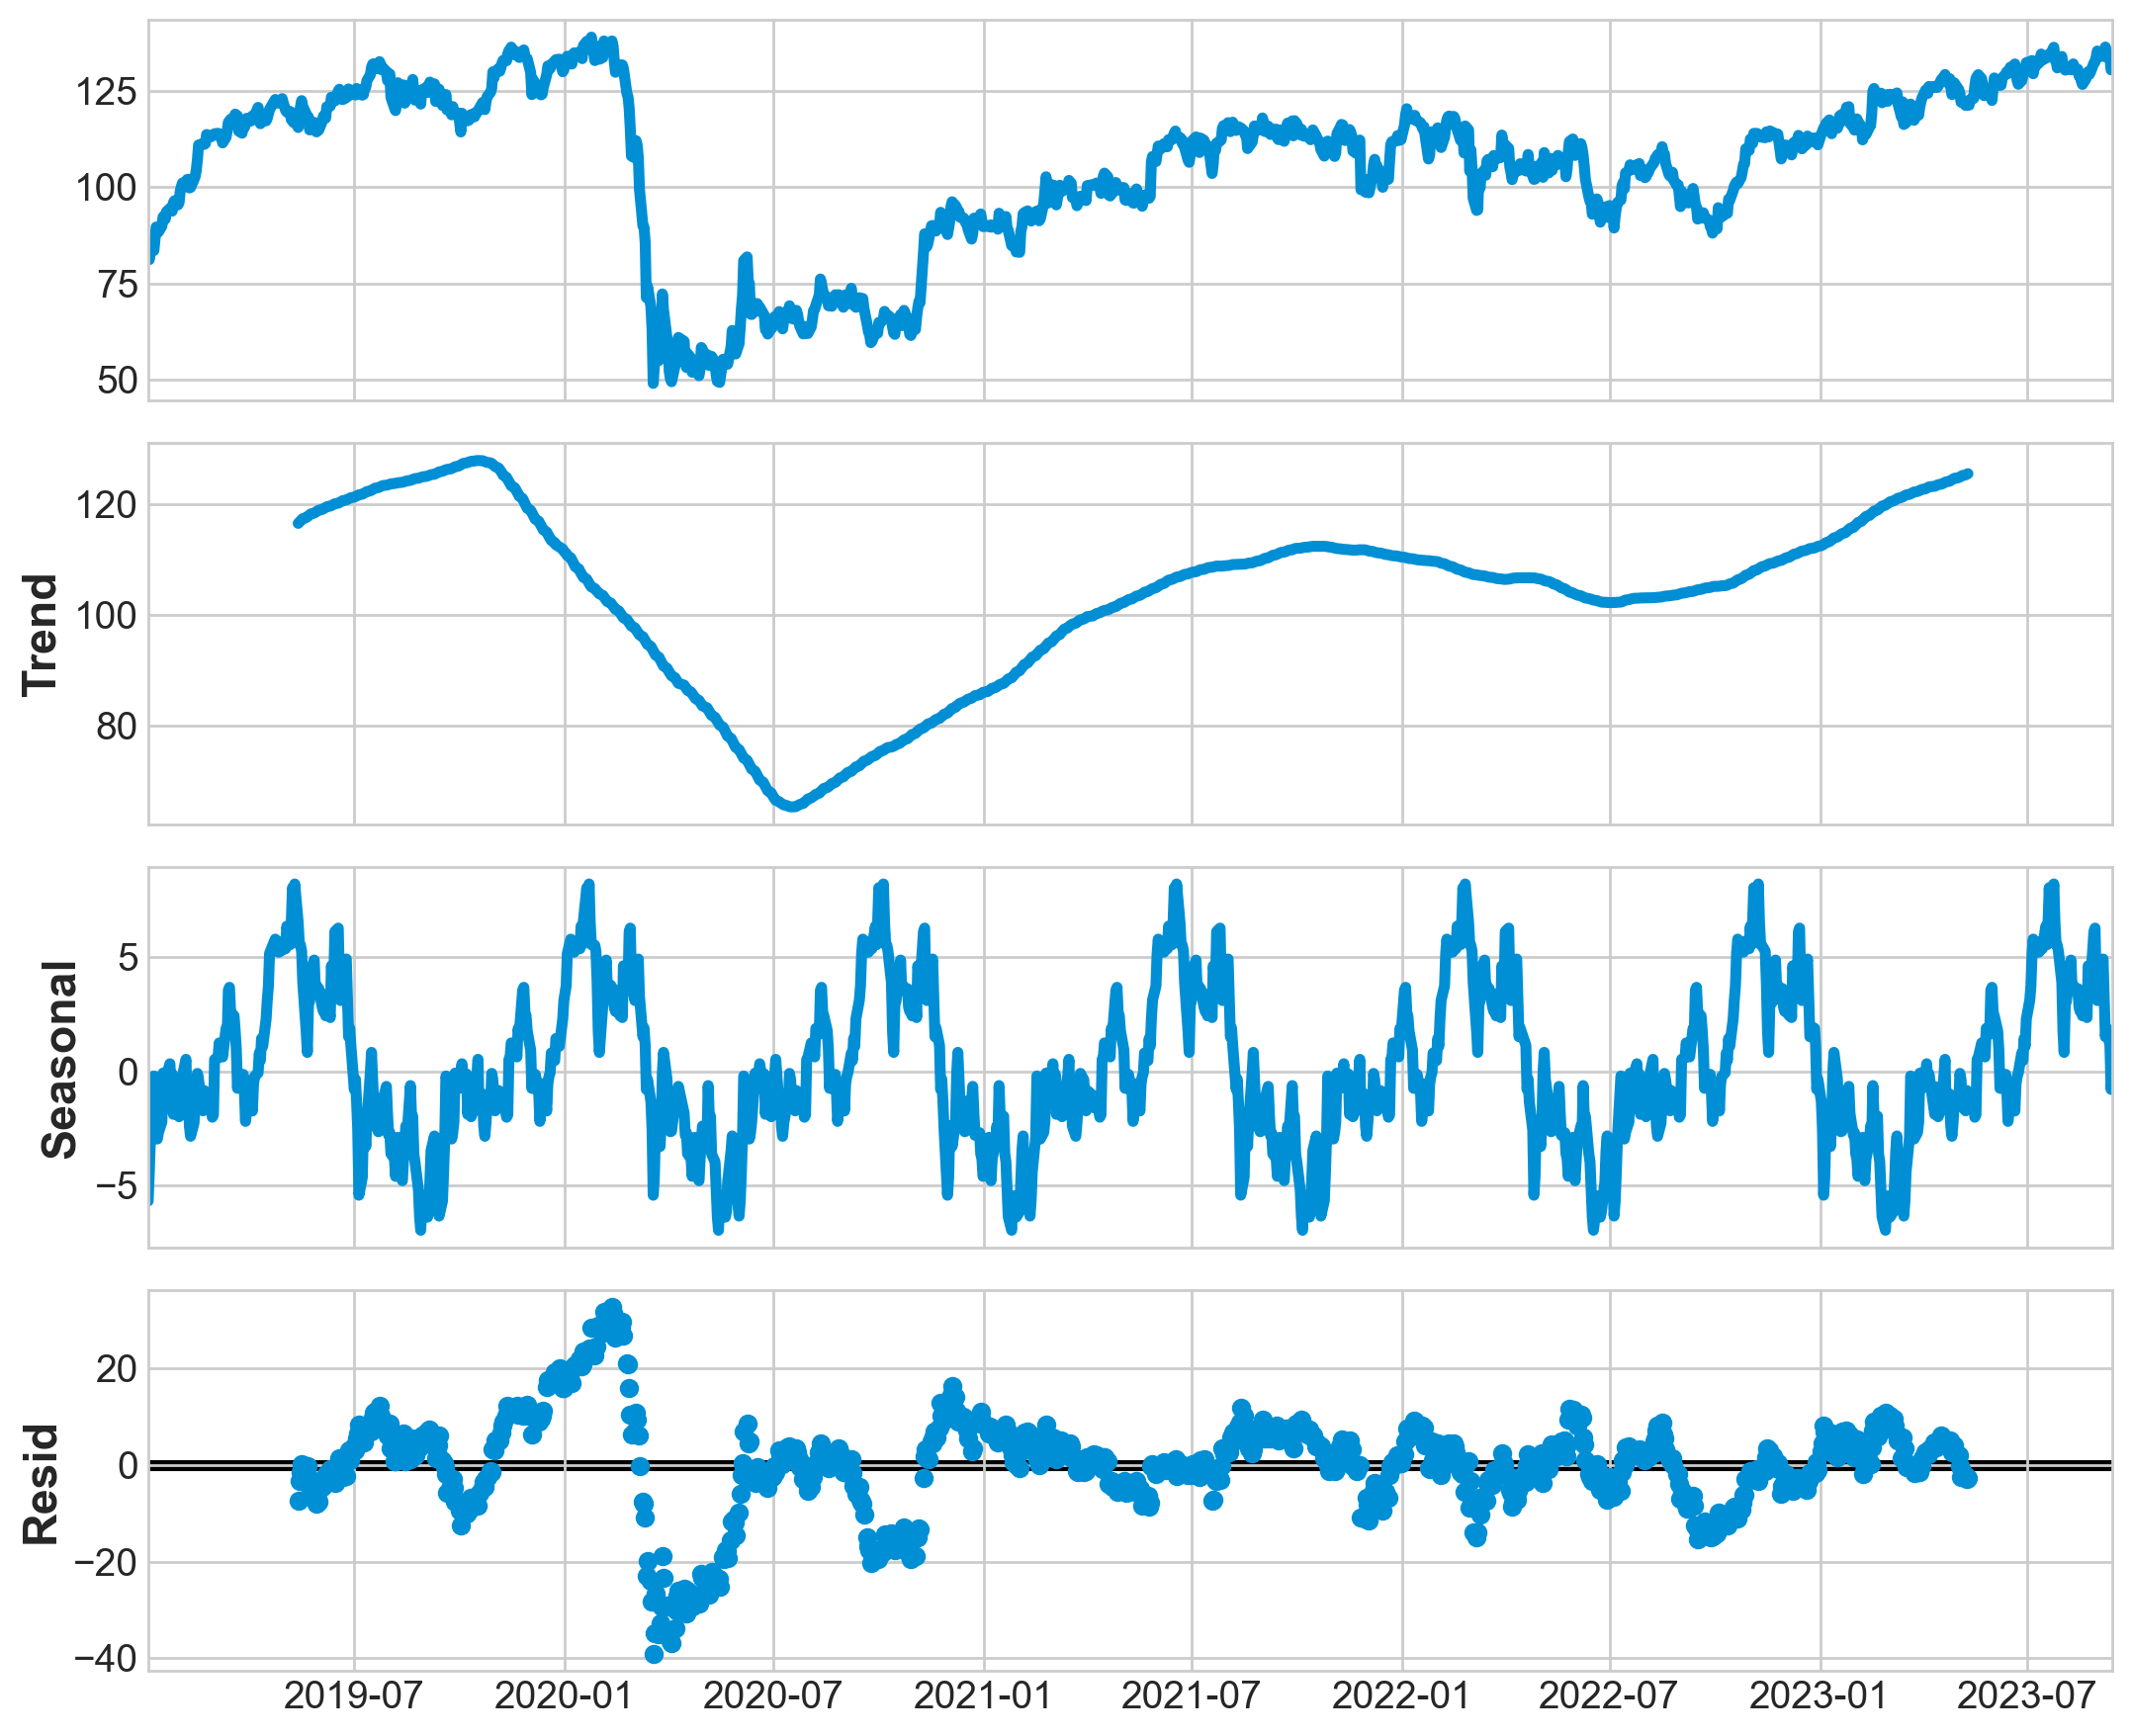

In [20]:
# decomposition
rcParams['figure.figsize'] = 11, 9
df_stock_sim1 = sm.tsa.seasonal_decompose(df_stock[['Price Close']],
                                          period=180,
                                          model='additive')
df_stock_sim2 = df_stock[['Price Close']]
figure = df_stock_sim1.plot()
plt.show()

In [21]:
sim1=df_stock_sim1.resid.dropna()
sim2 = df_stock_sim2.dropna()

# Model

## ARIMA

[]

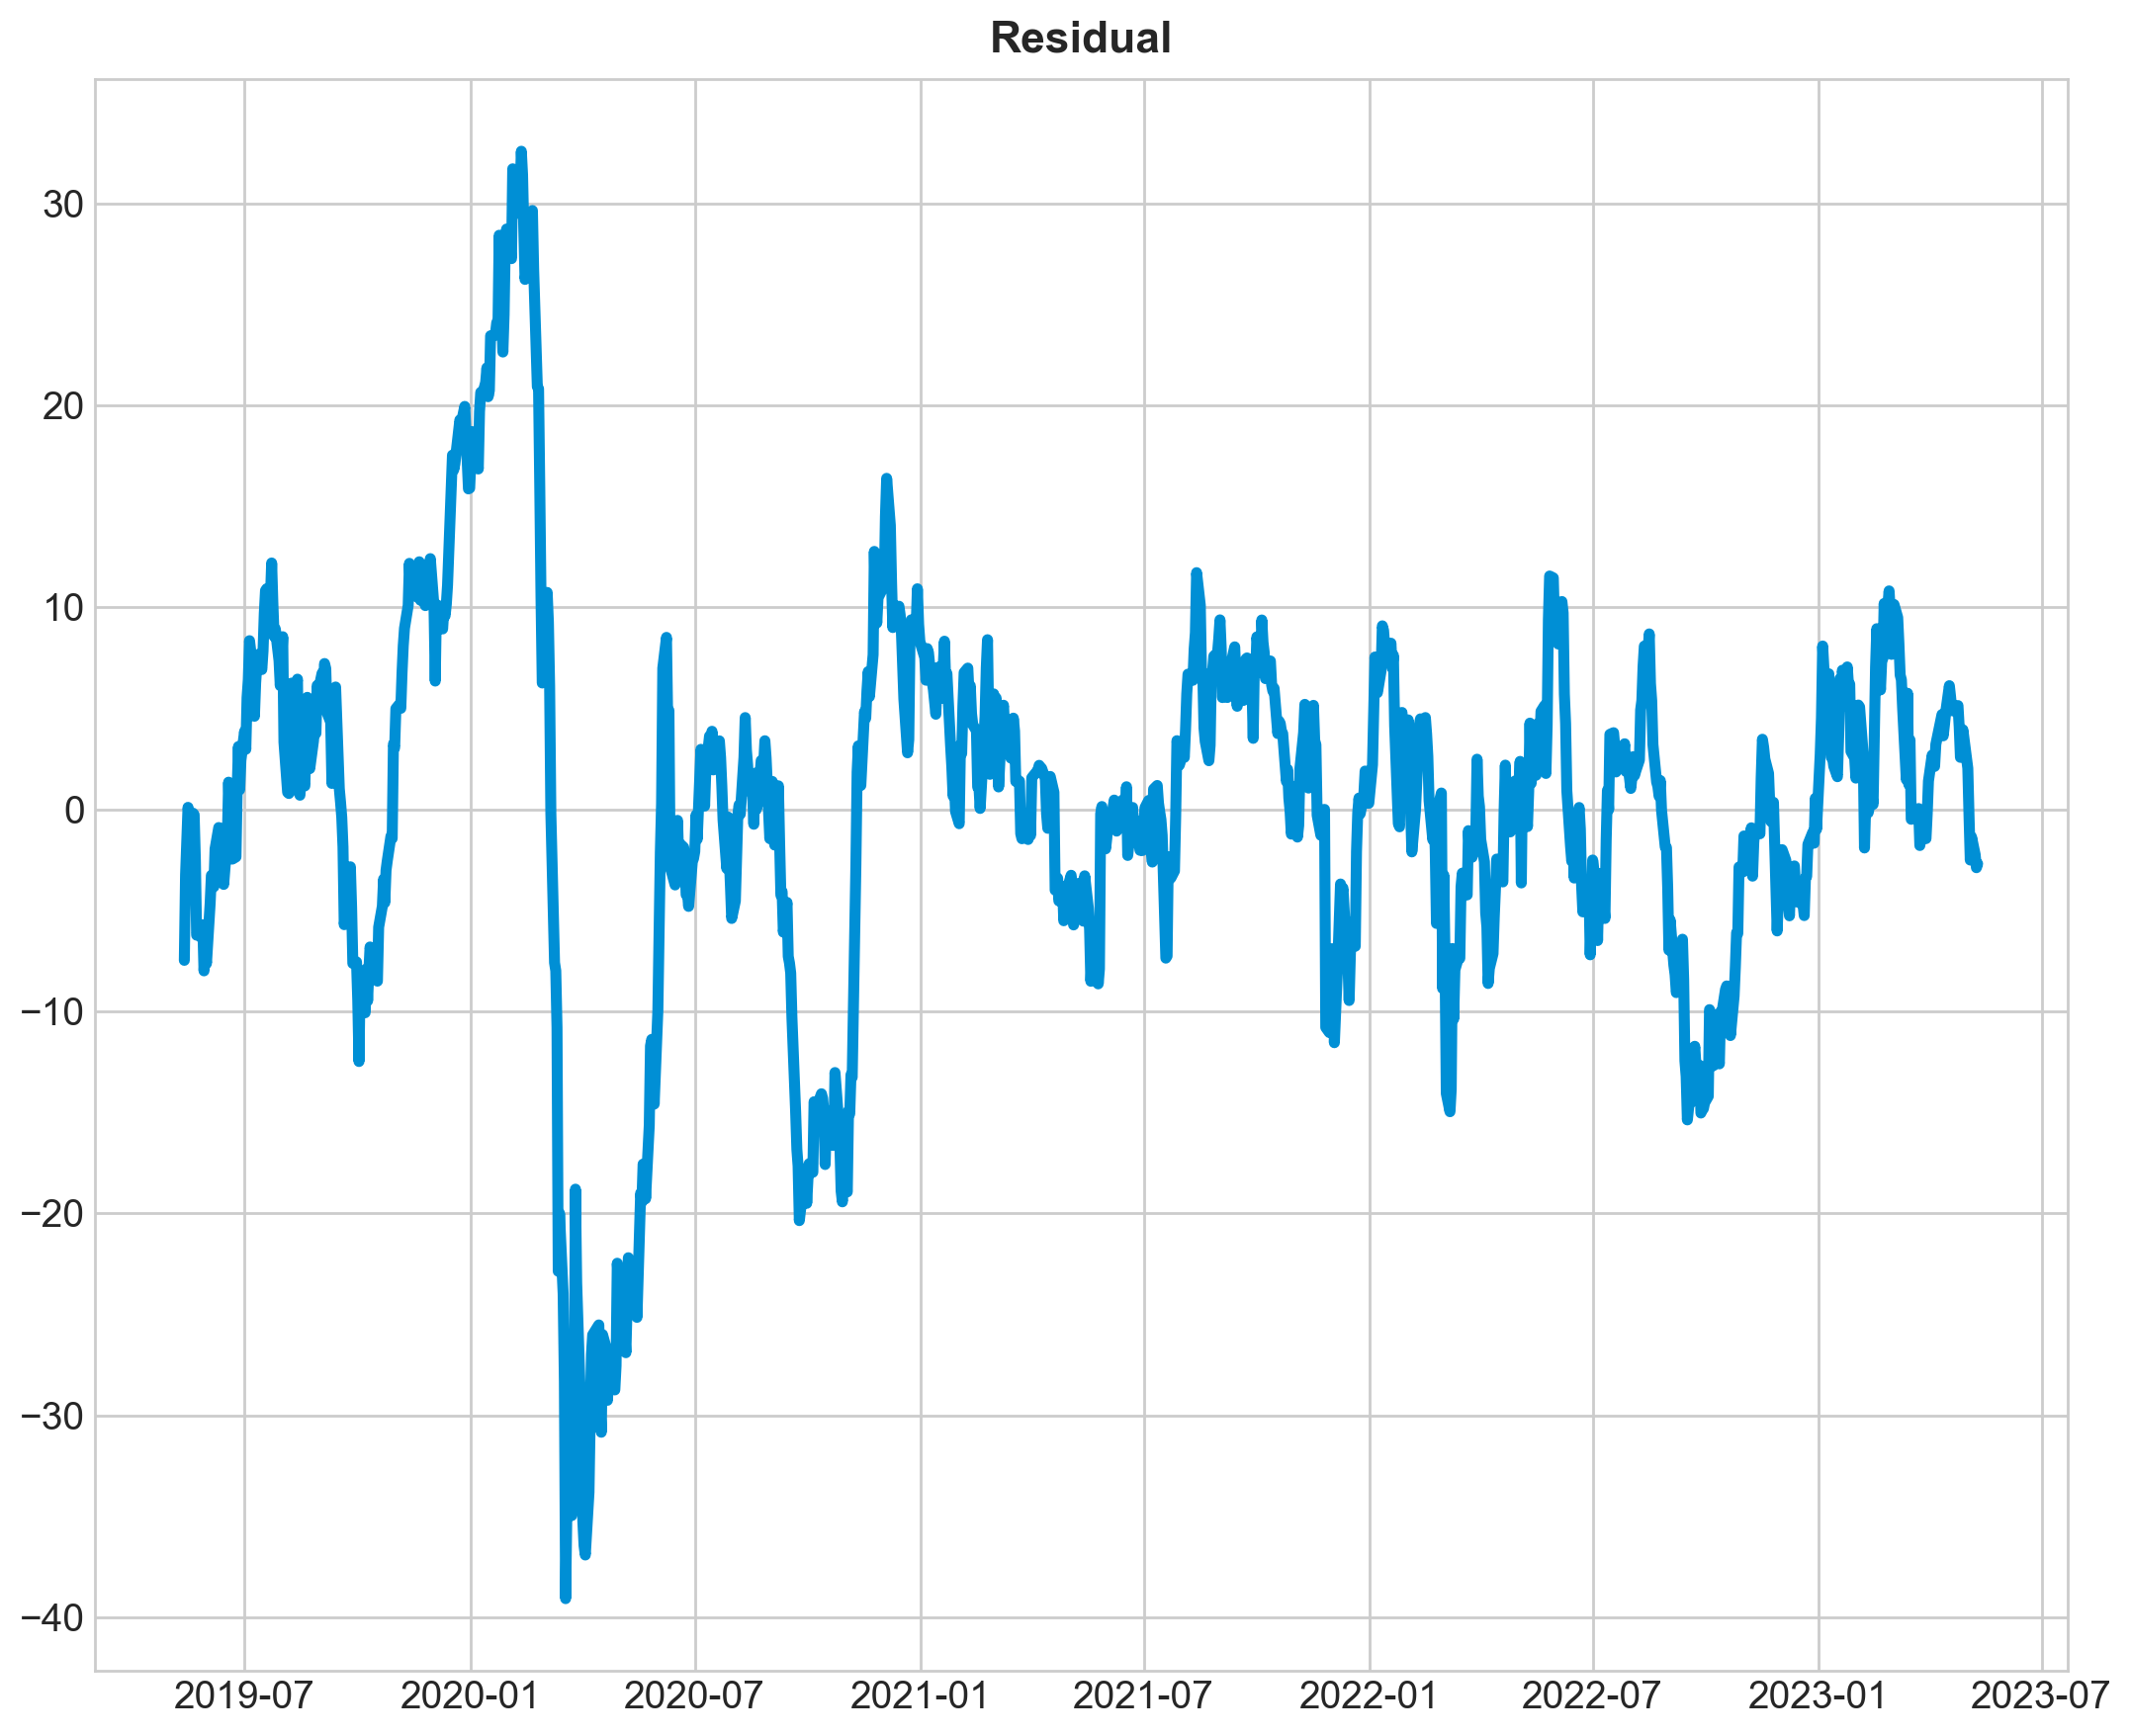

In [22]:
plt.plot(sim1)
plt.title('Residual')
plt.plot()

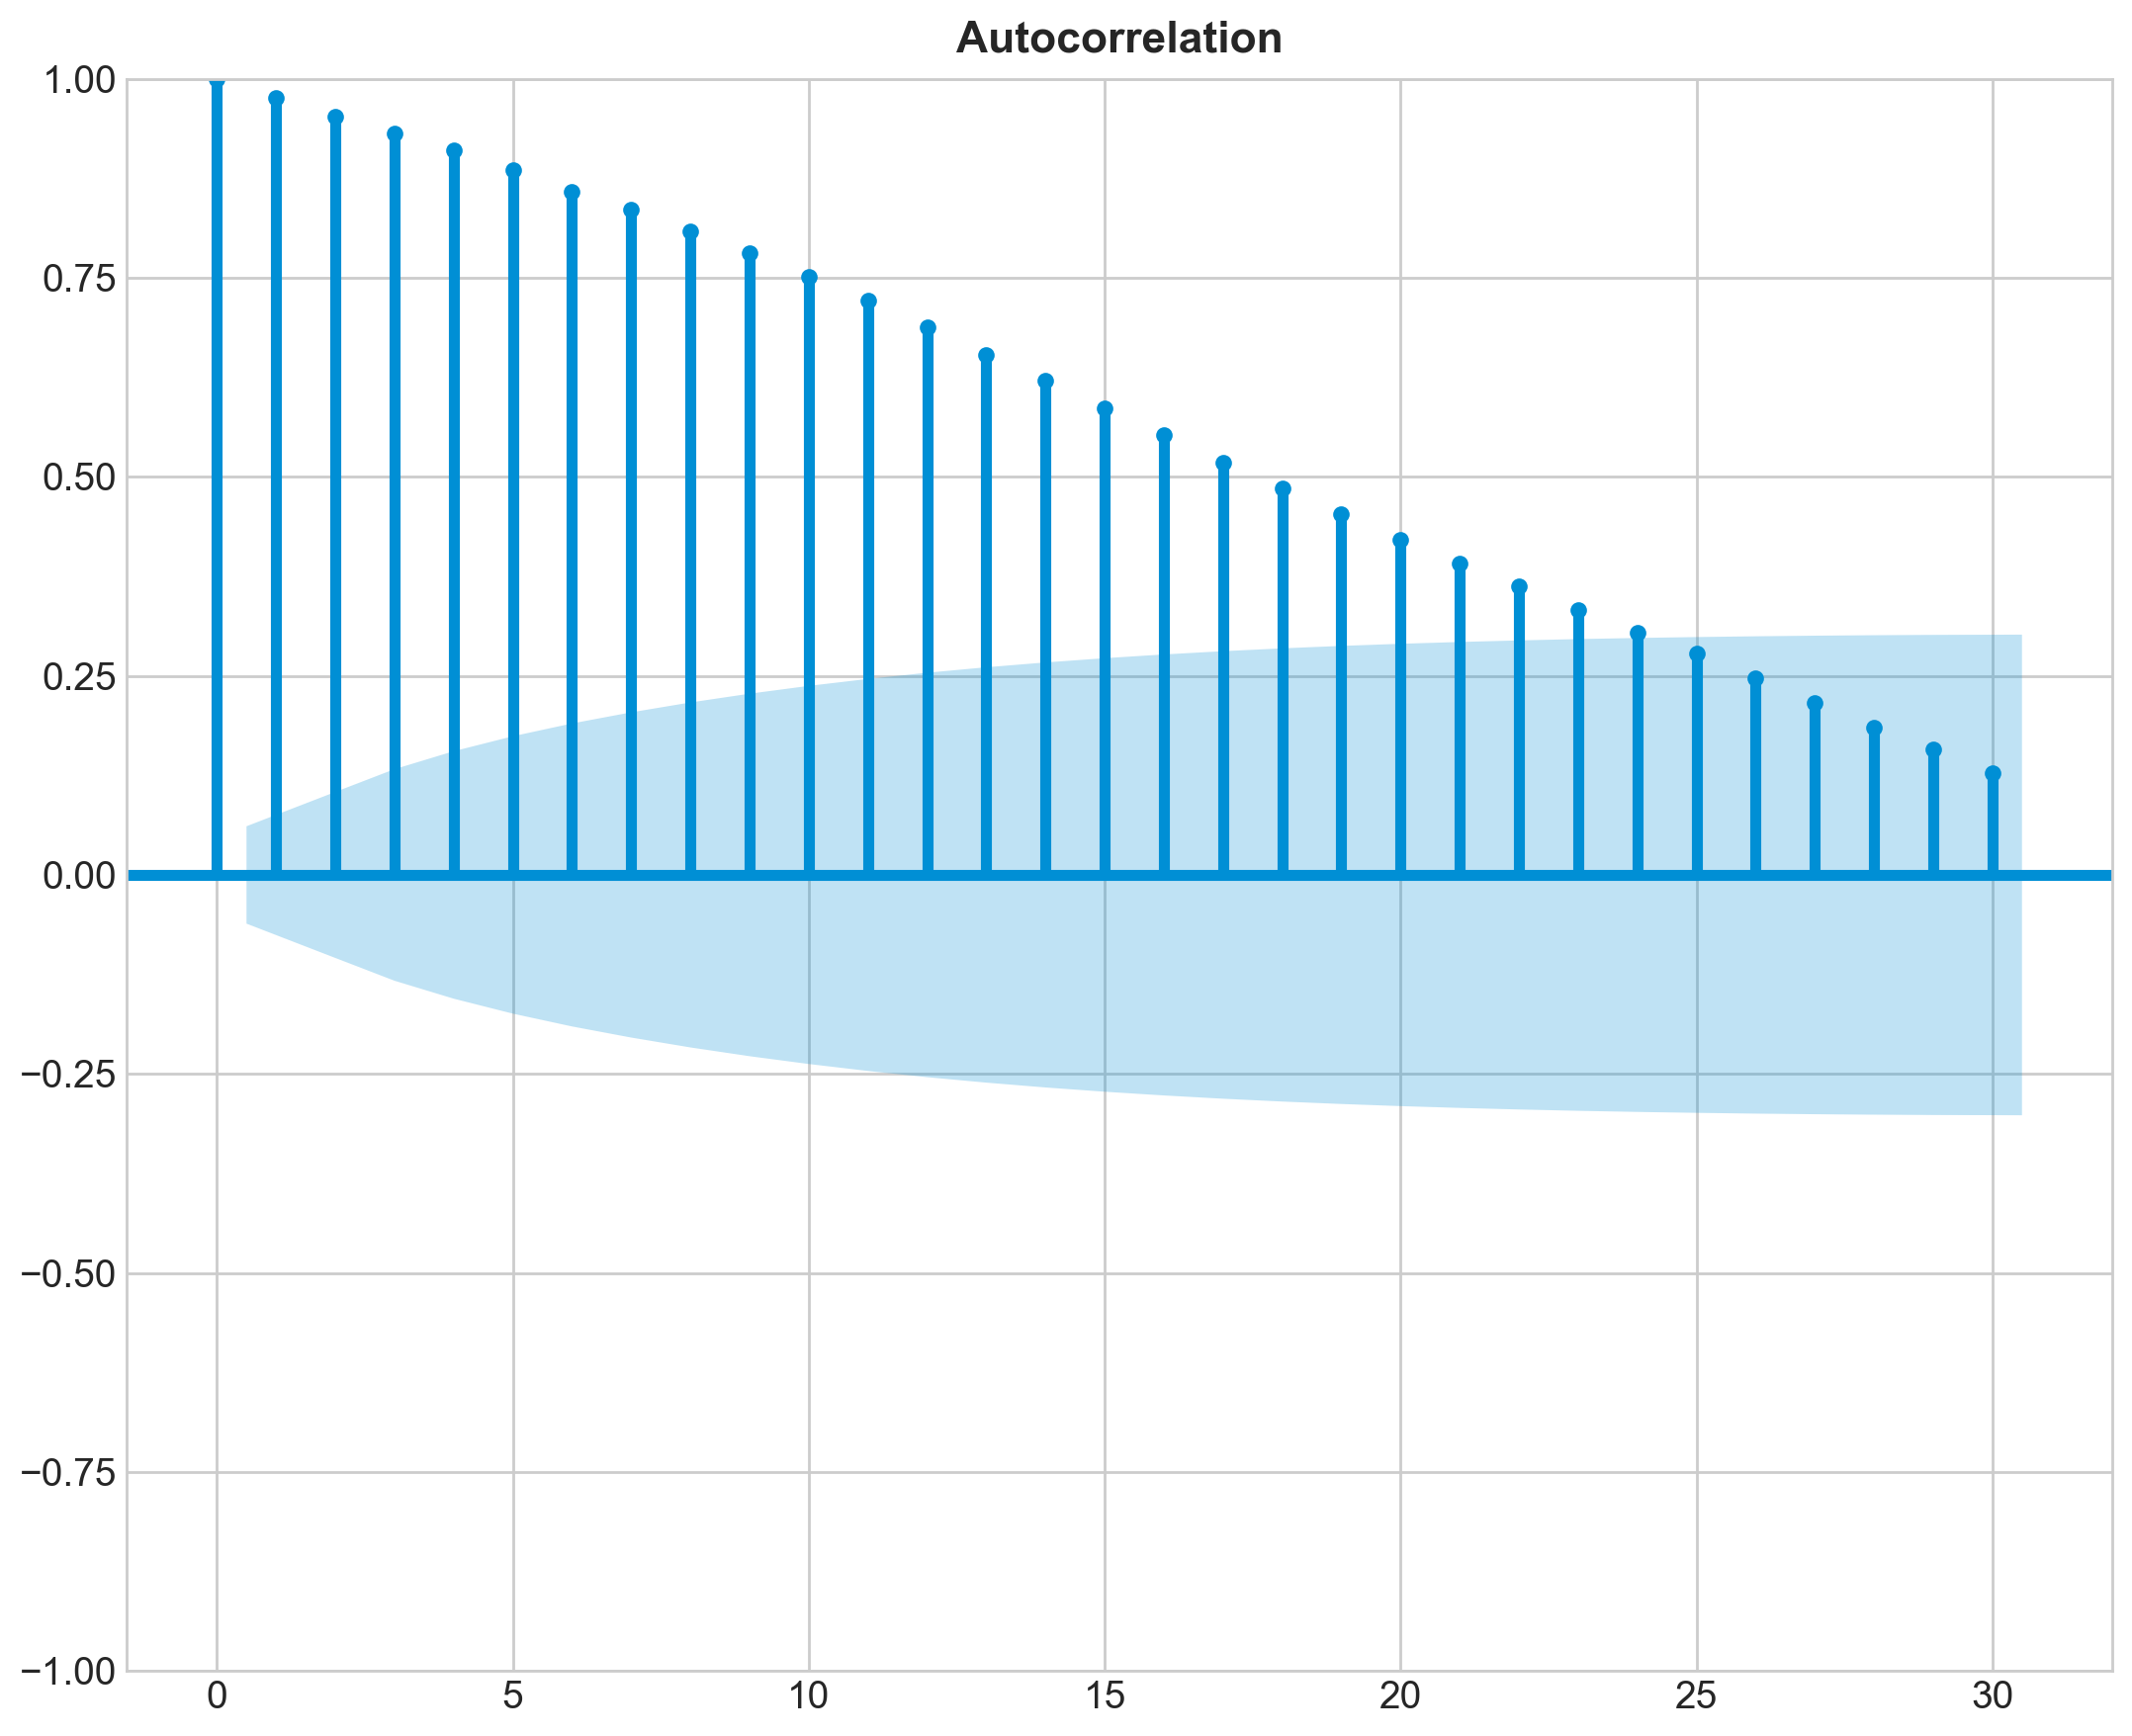

In [23]:
plot_acf(sim1, lags=30)
plt.show()

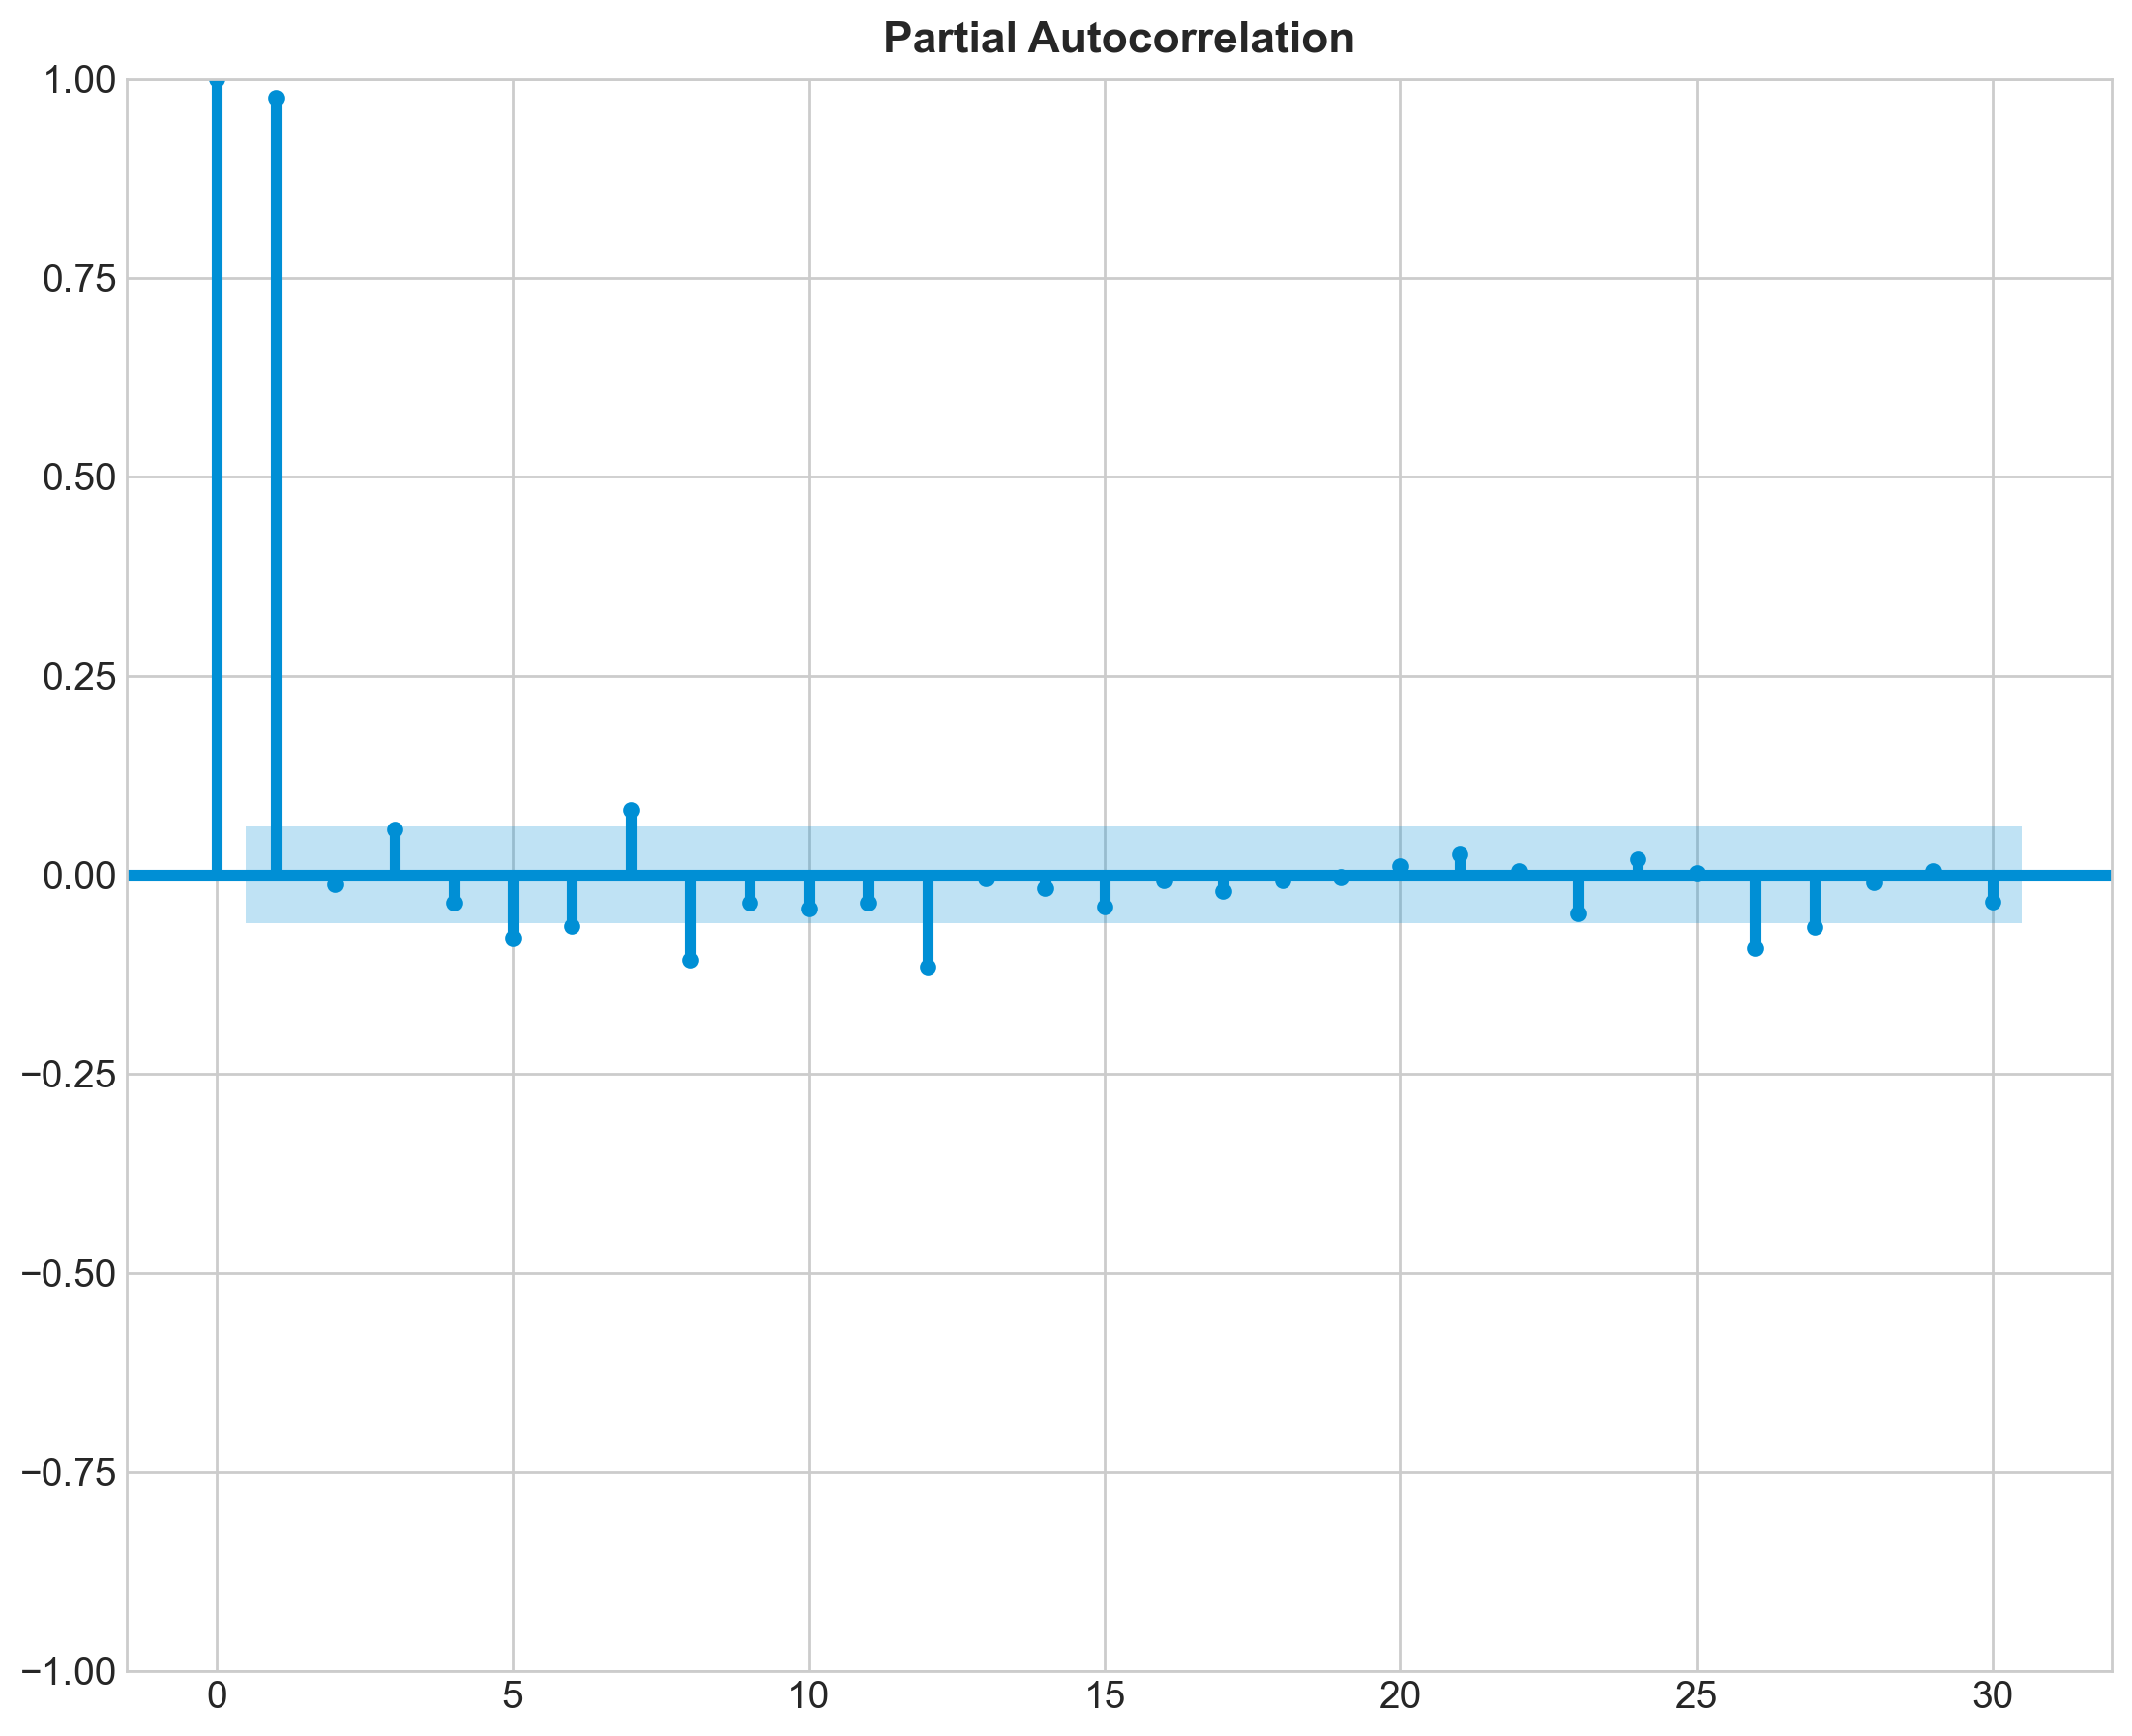

In [24]:
plot_pacf(sim1, lags=30)
plt.show()

In [25]:
model = sm.tsa.statespace.SARIMAX(sim1,
                                order=(1, 0, 0))

results = model.fit()

In [26]:
pred = results.get_prediction(start=0,dynamic=False)

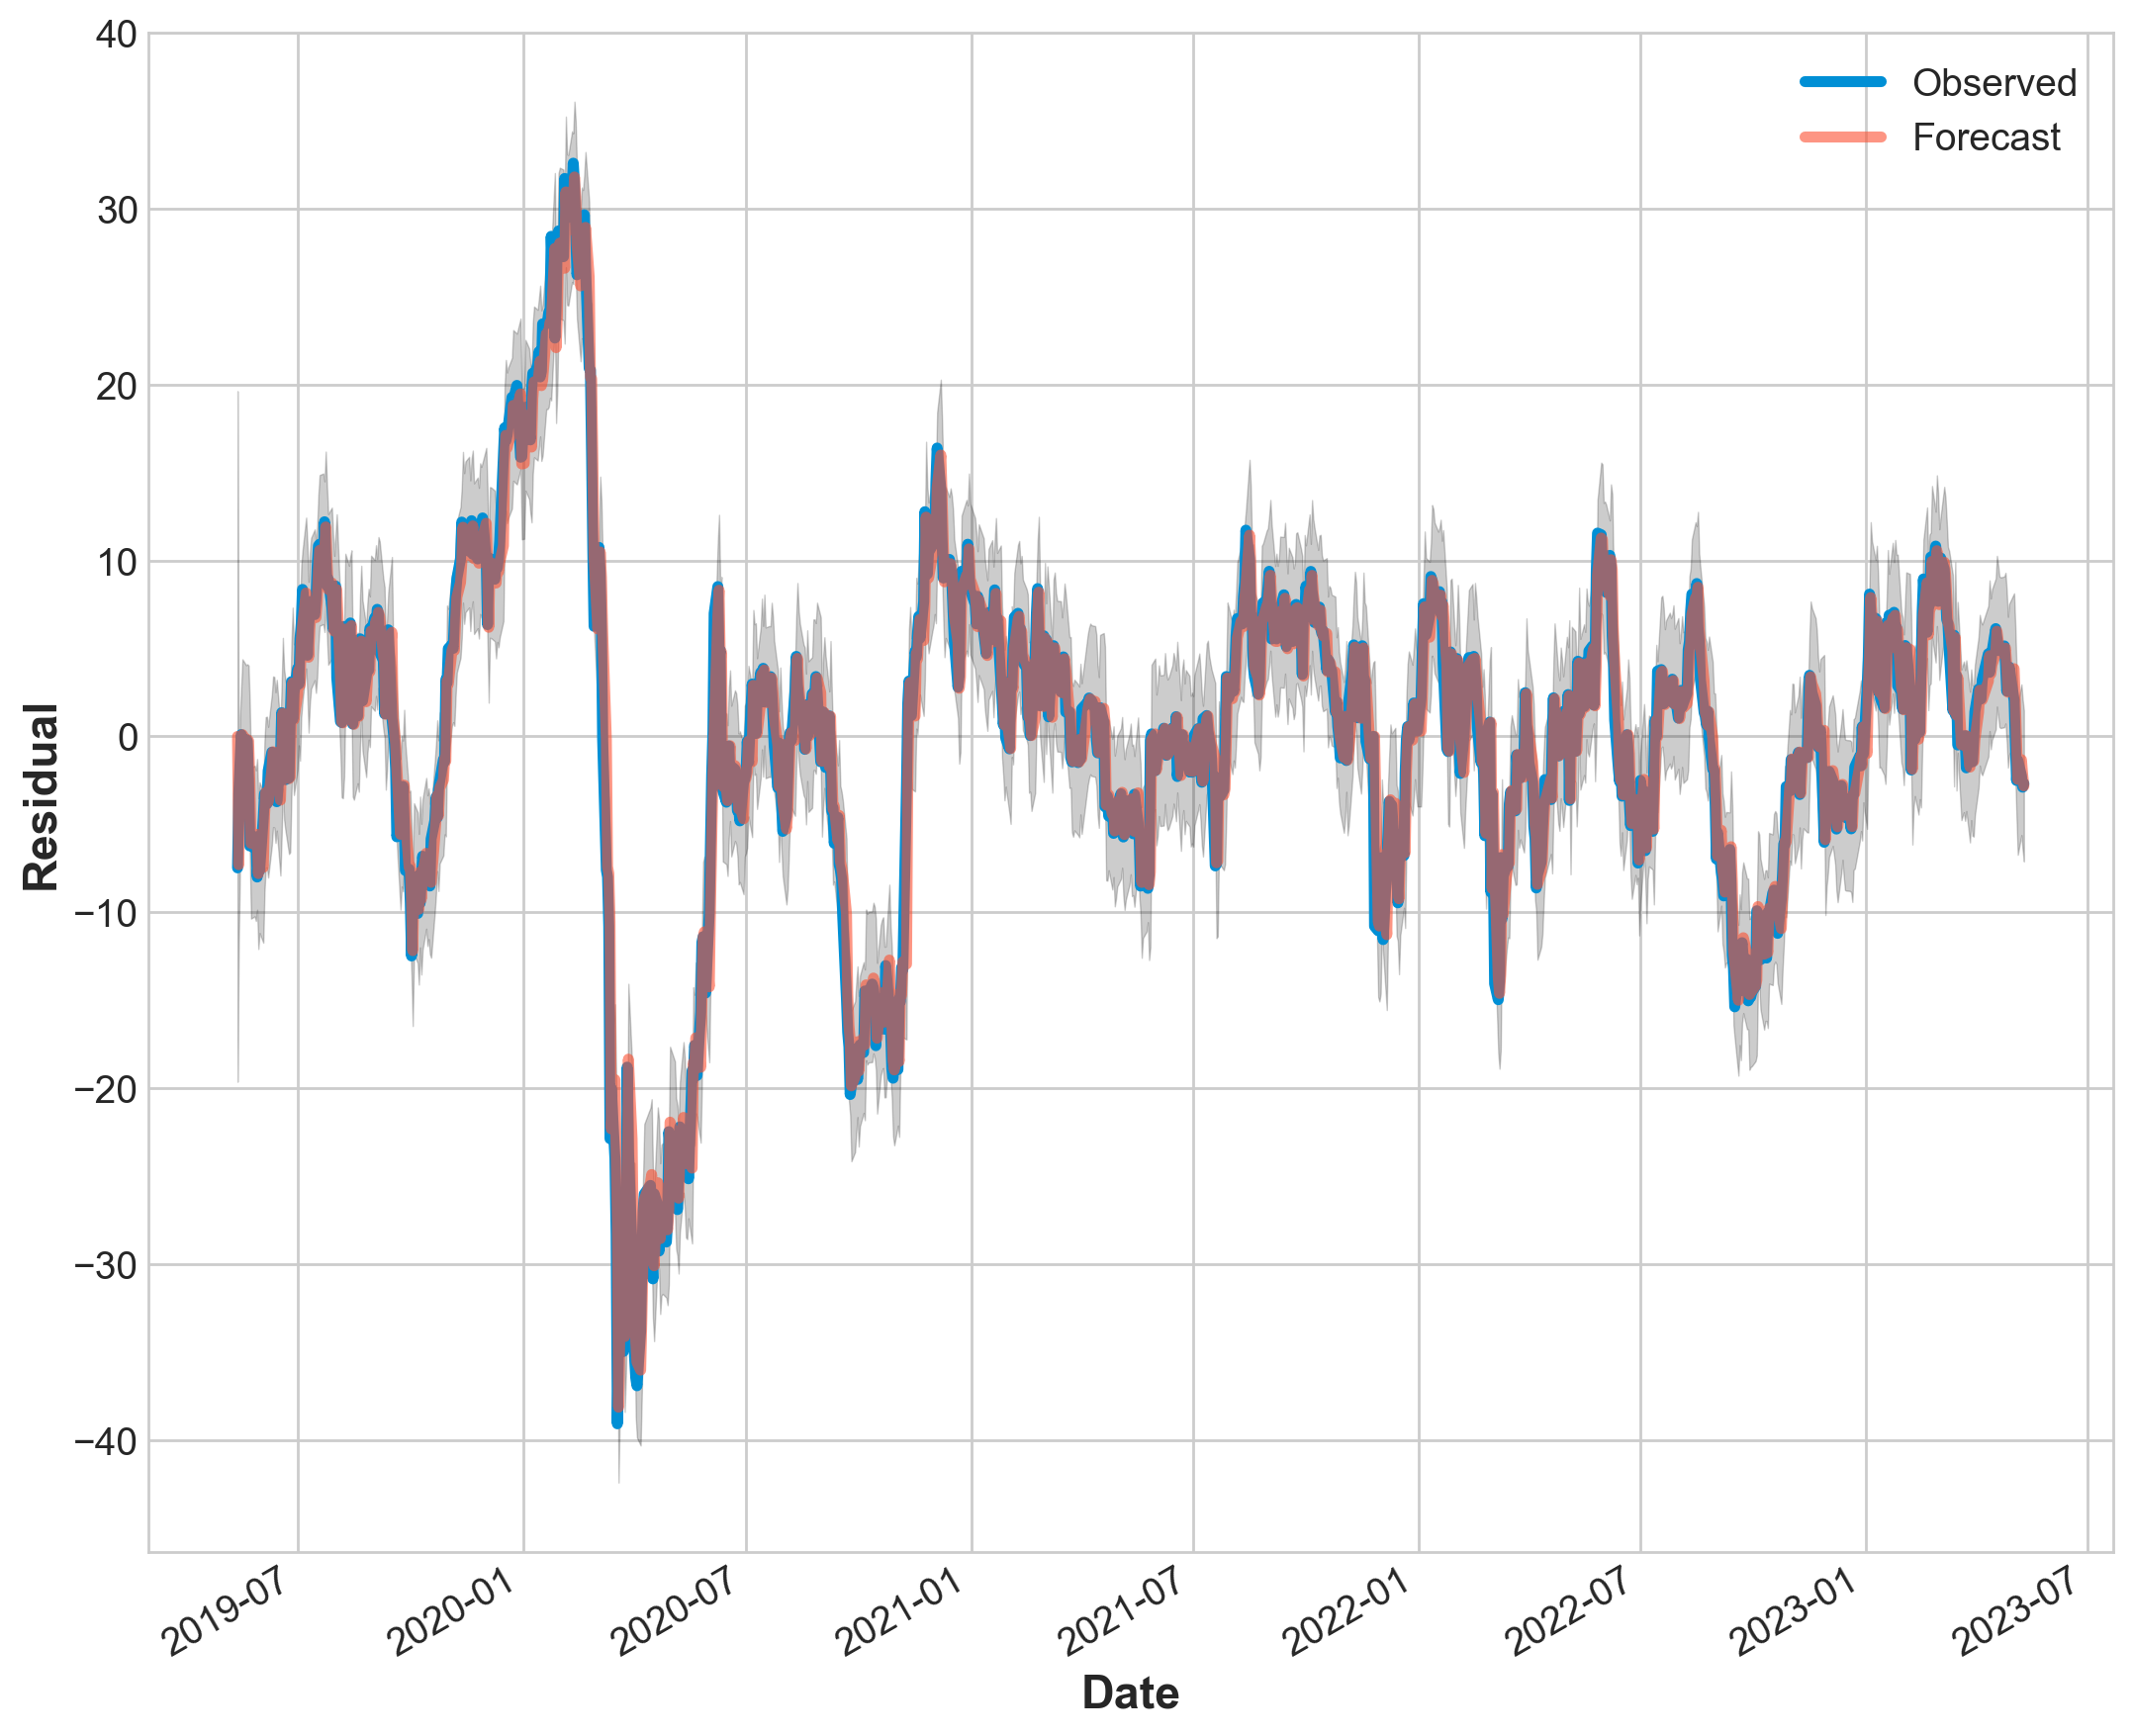

In [27]:
pred_ci = pred.conf_int()
#Returns the confidence interval of the fitted parameters.

ax = sim1[0:].plot(label='Observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.6)

ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Residual')
plt.legend()

plt.show()


<Axes: xlabel='Date'>

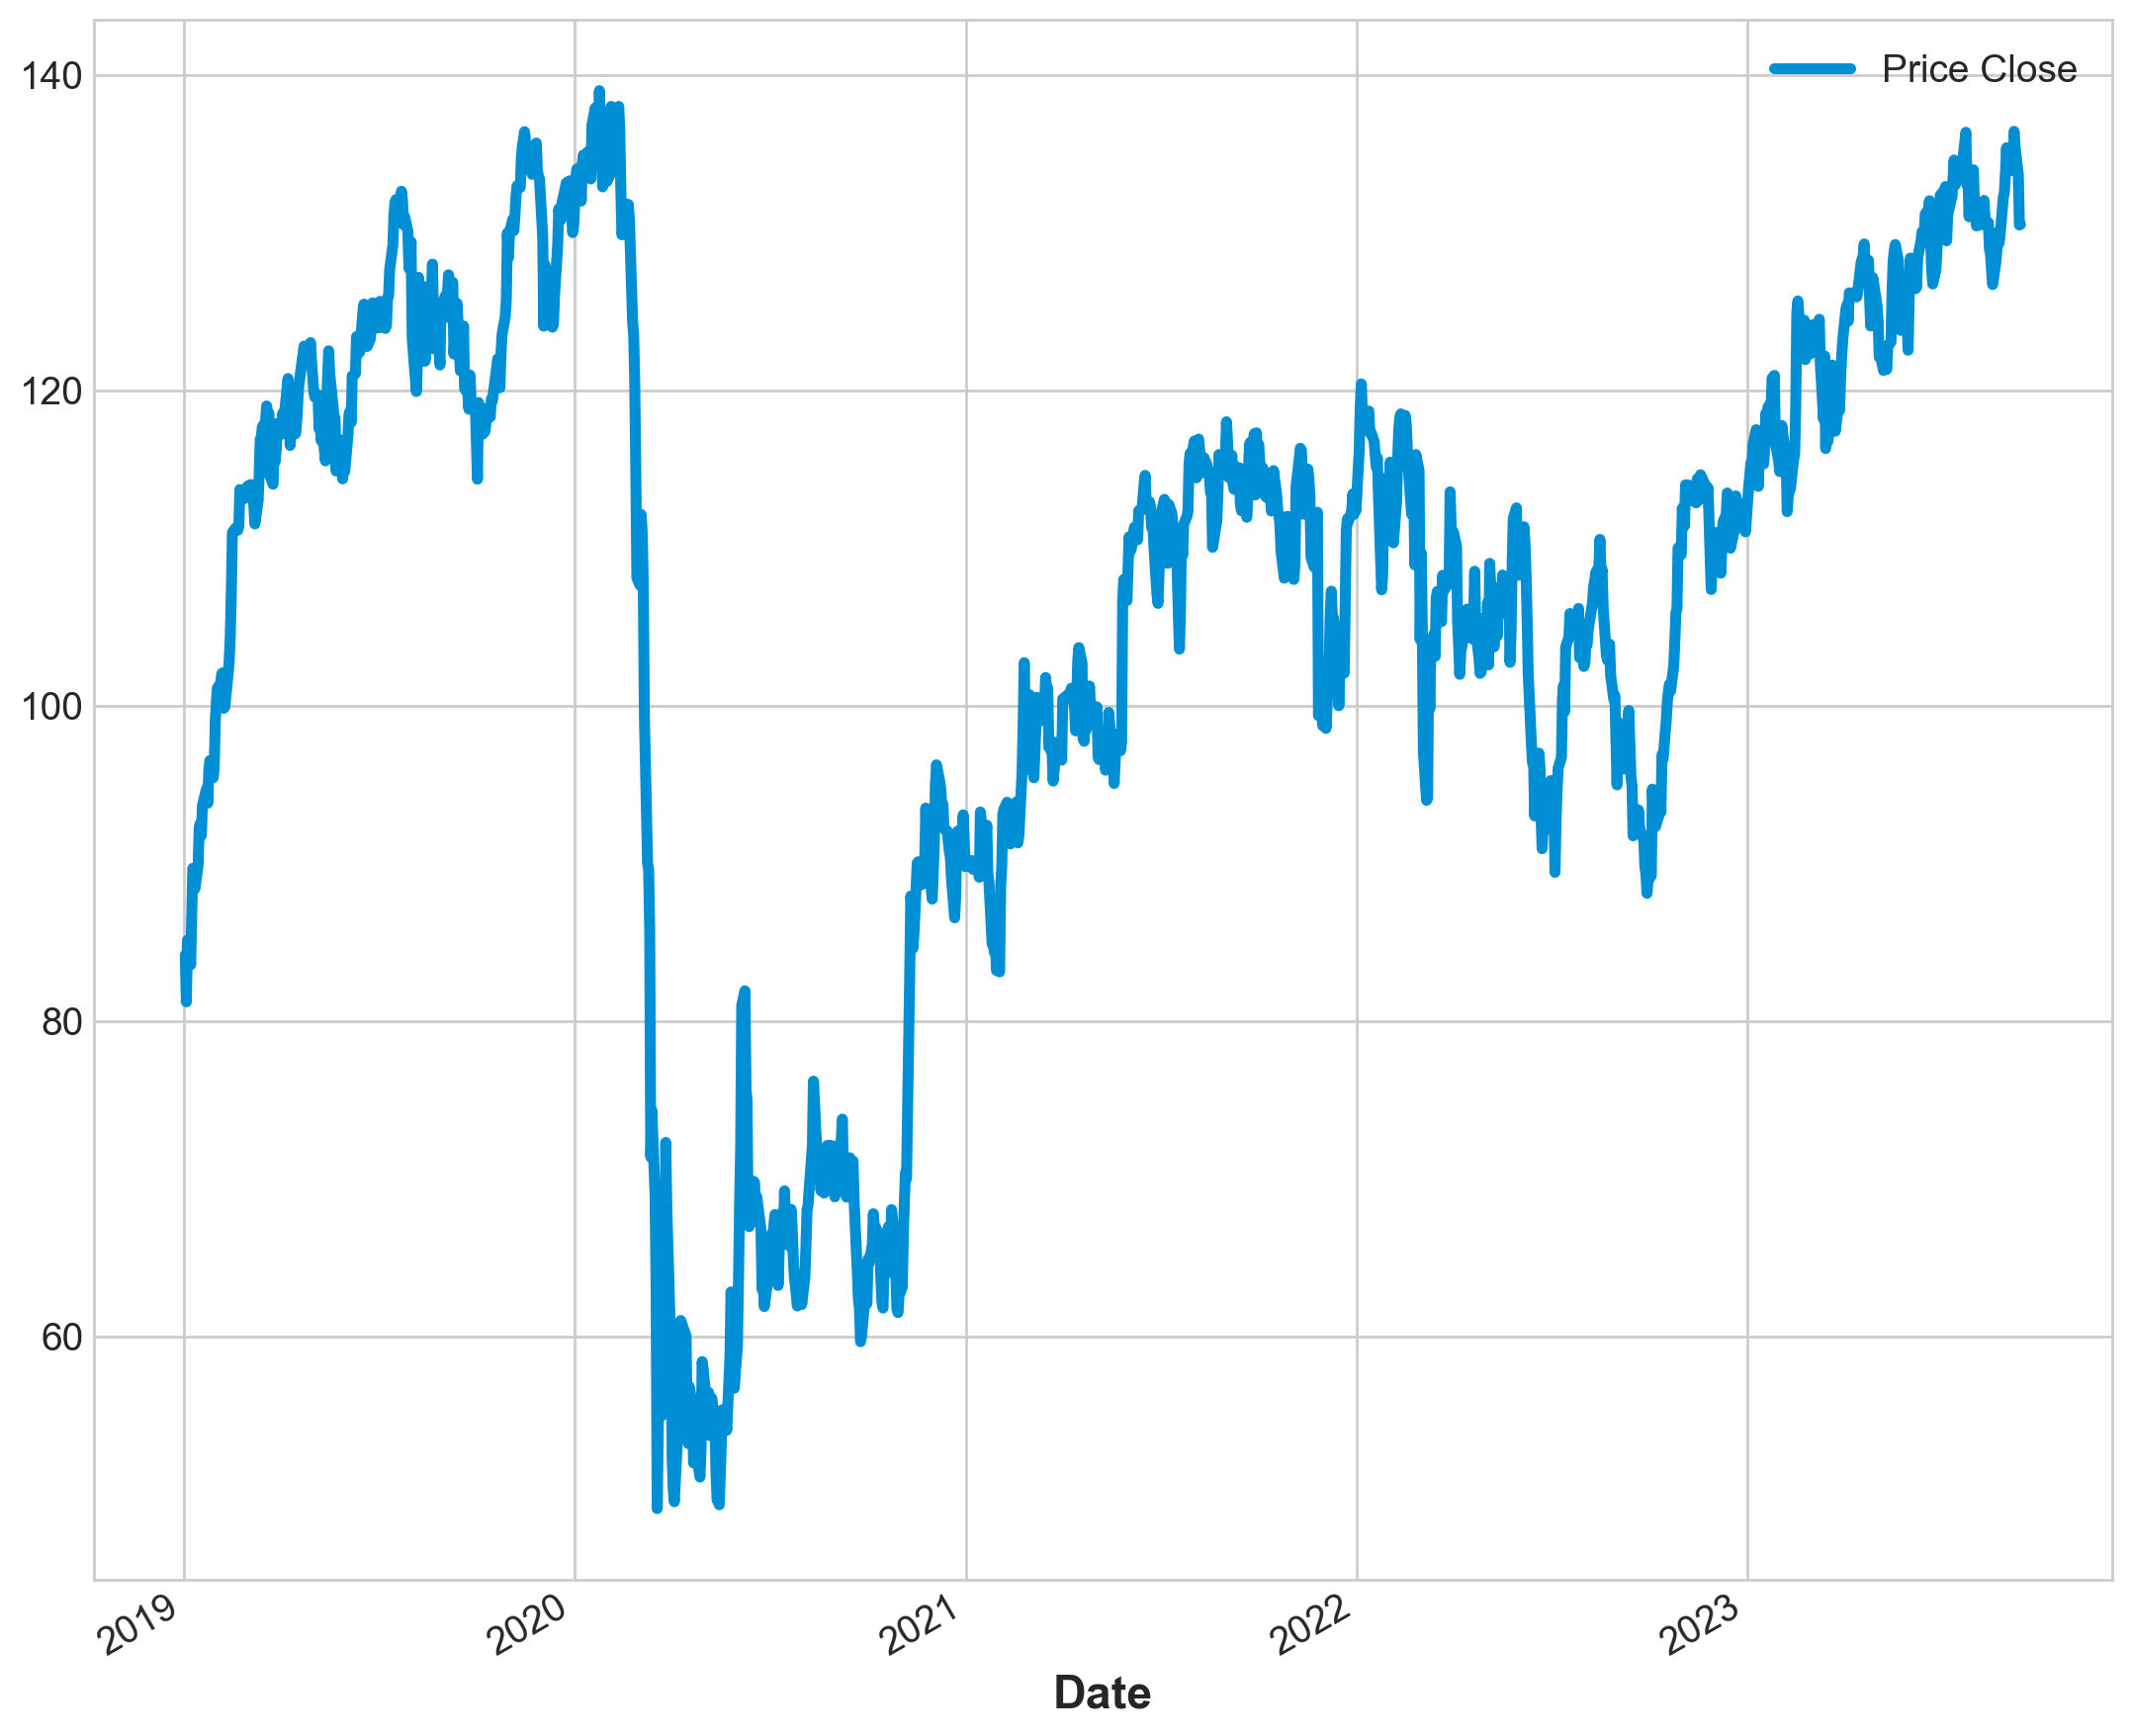

In [28]:
sim2.plot()

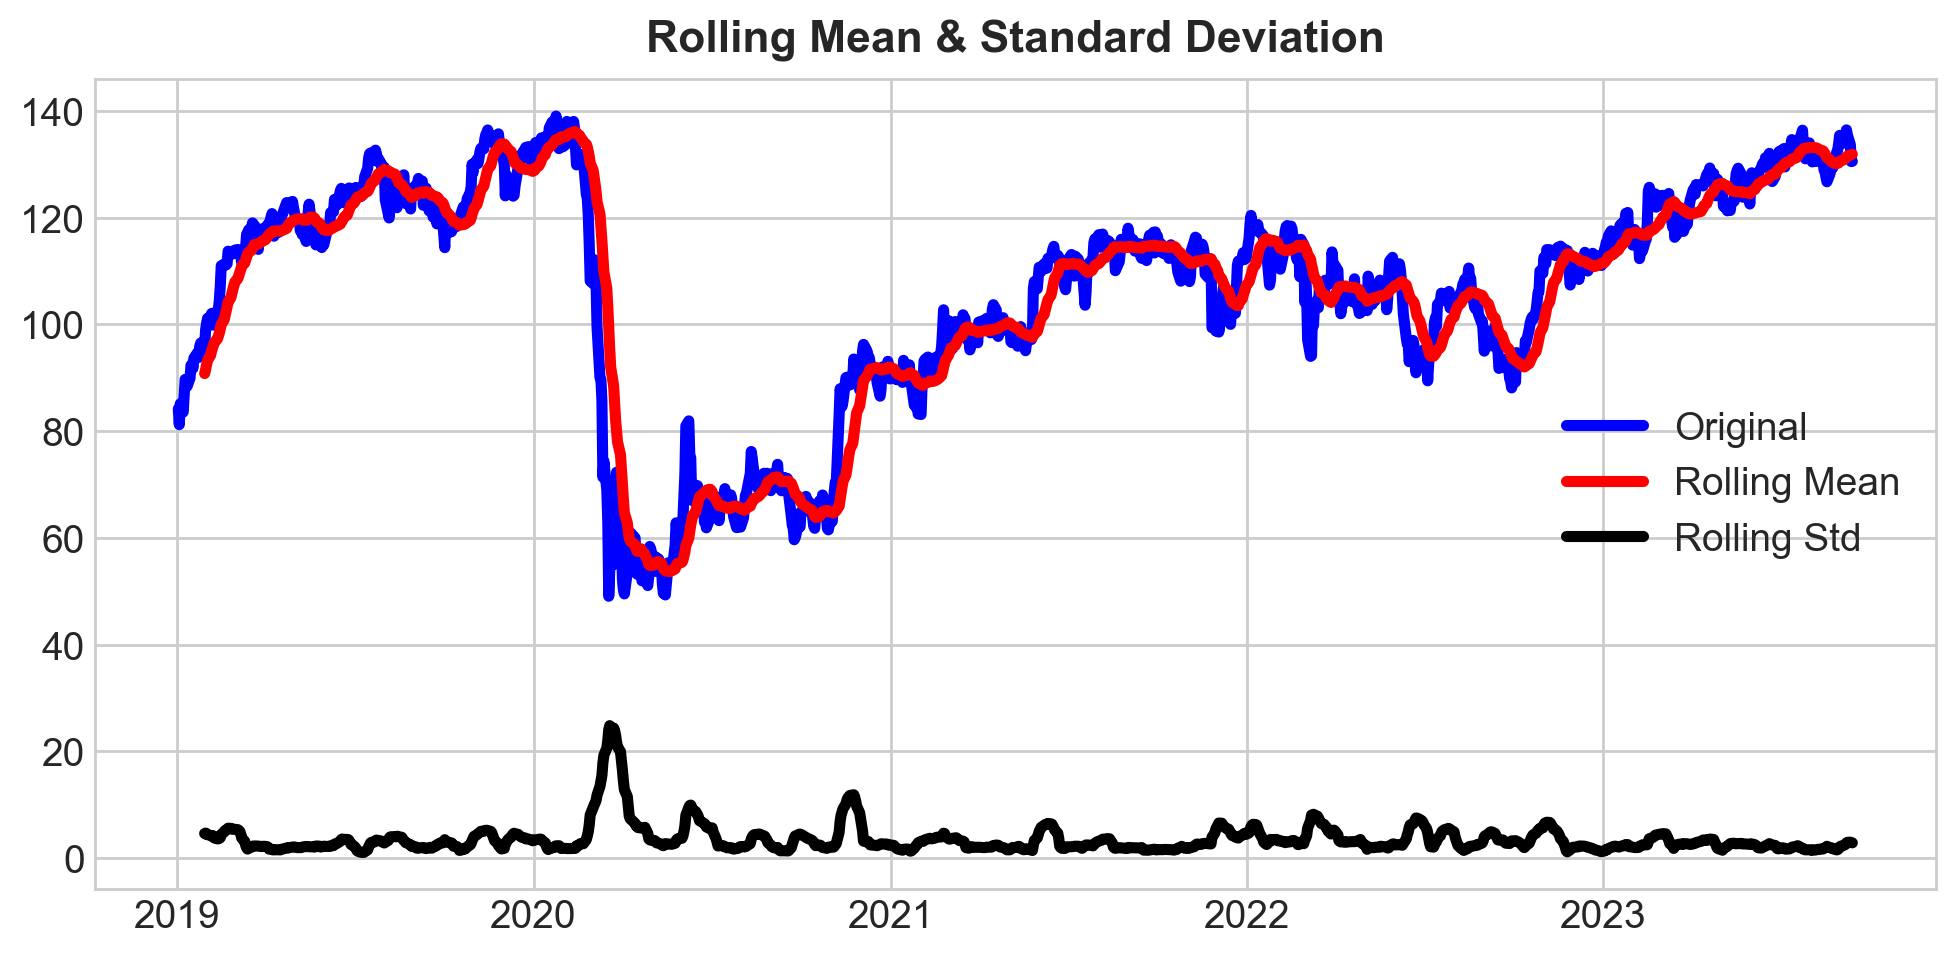

Results of Dickey-Fuller Test:
Test Statistic                   -2.237014
p-value                           0.193087
#Lags Used                       11.000000
Number of Observations Used    1195.000000
Critical Value (1%)              -3.435834
Critical Value (5%)              -2.863962
Critical Value (10%)             -2.568059
dtype: float64


In [29]:
def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(20).mean()
    rolstd = timeseries.rolling(20).std()
    # Plot rolling statistics:
    plt.figure(figsize=(10, 5))
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    return dftest
StationaryTest = test_stationarity(sim2)

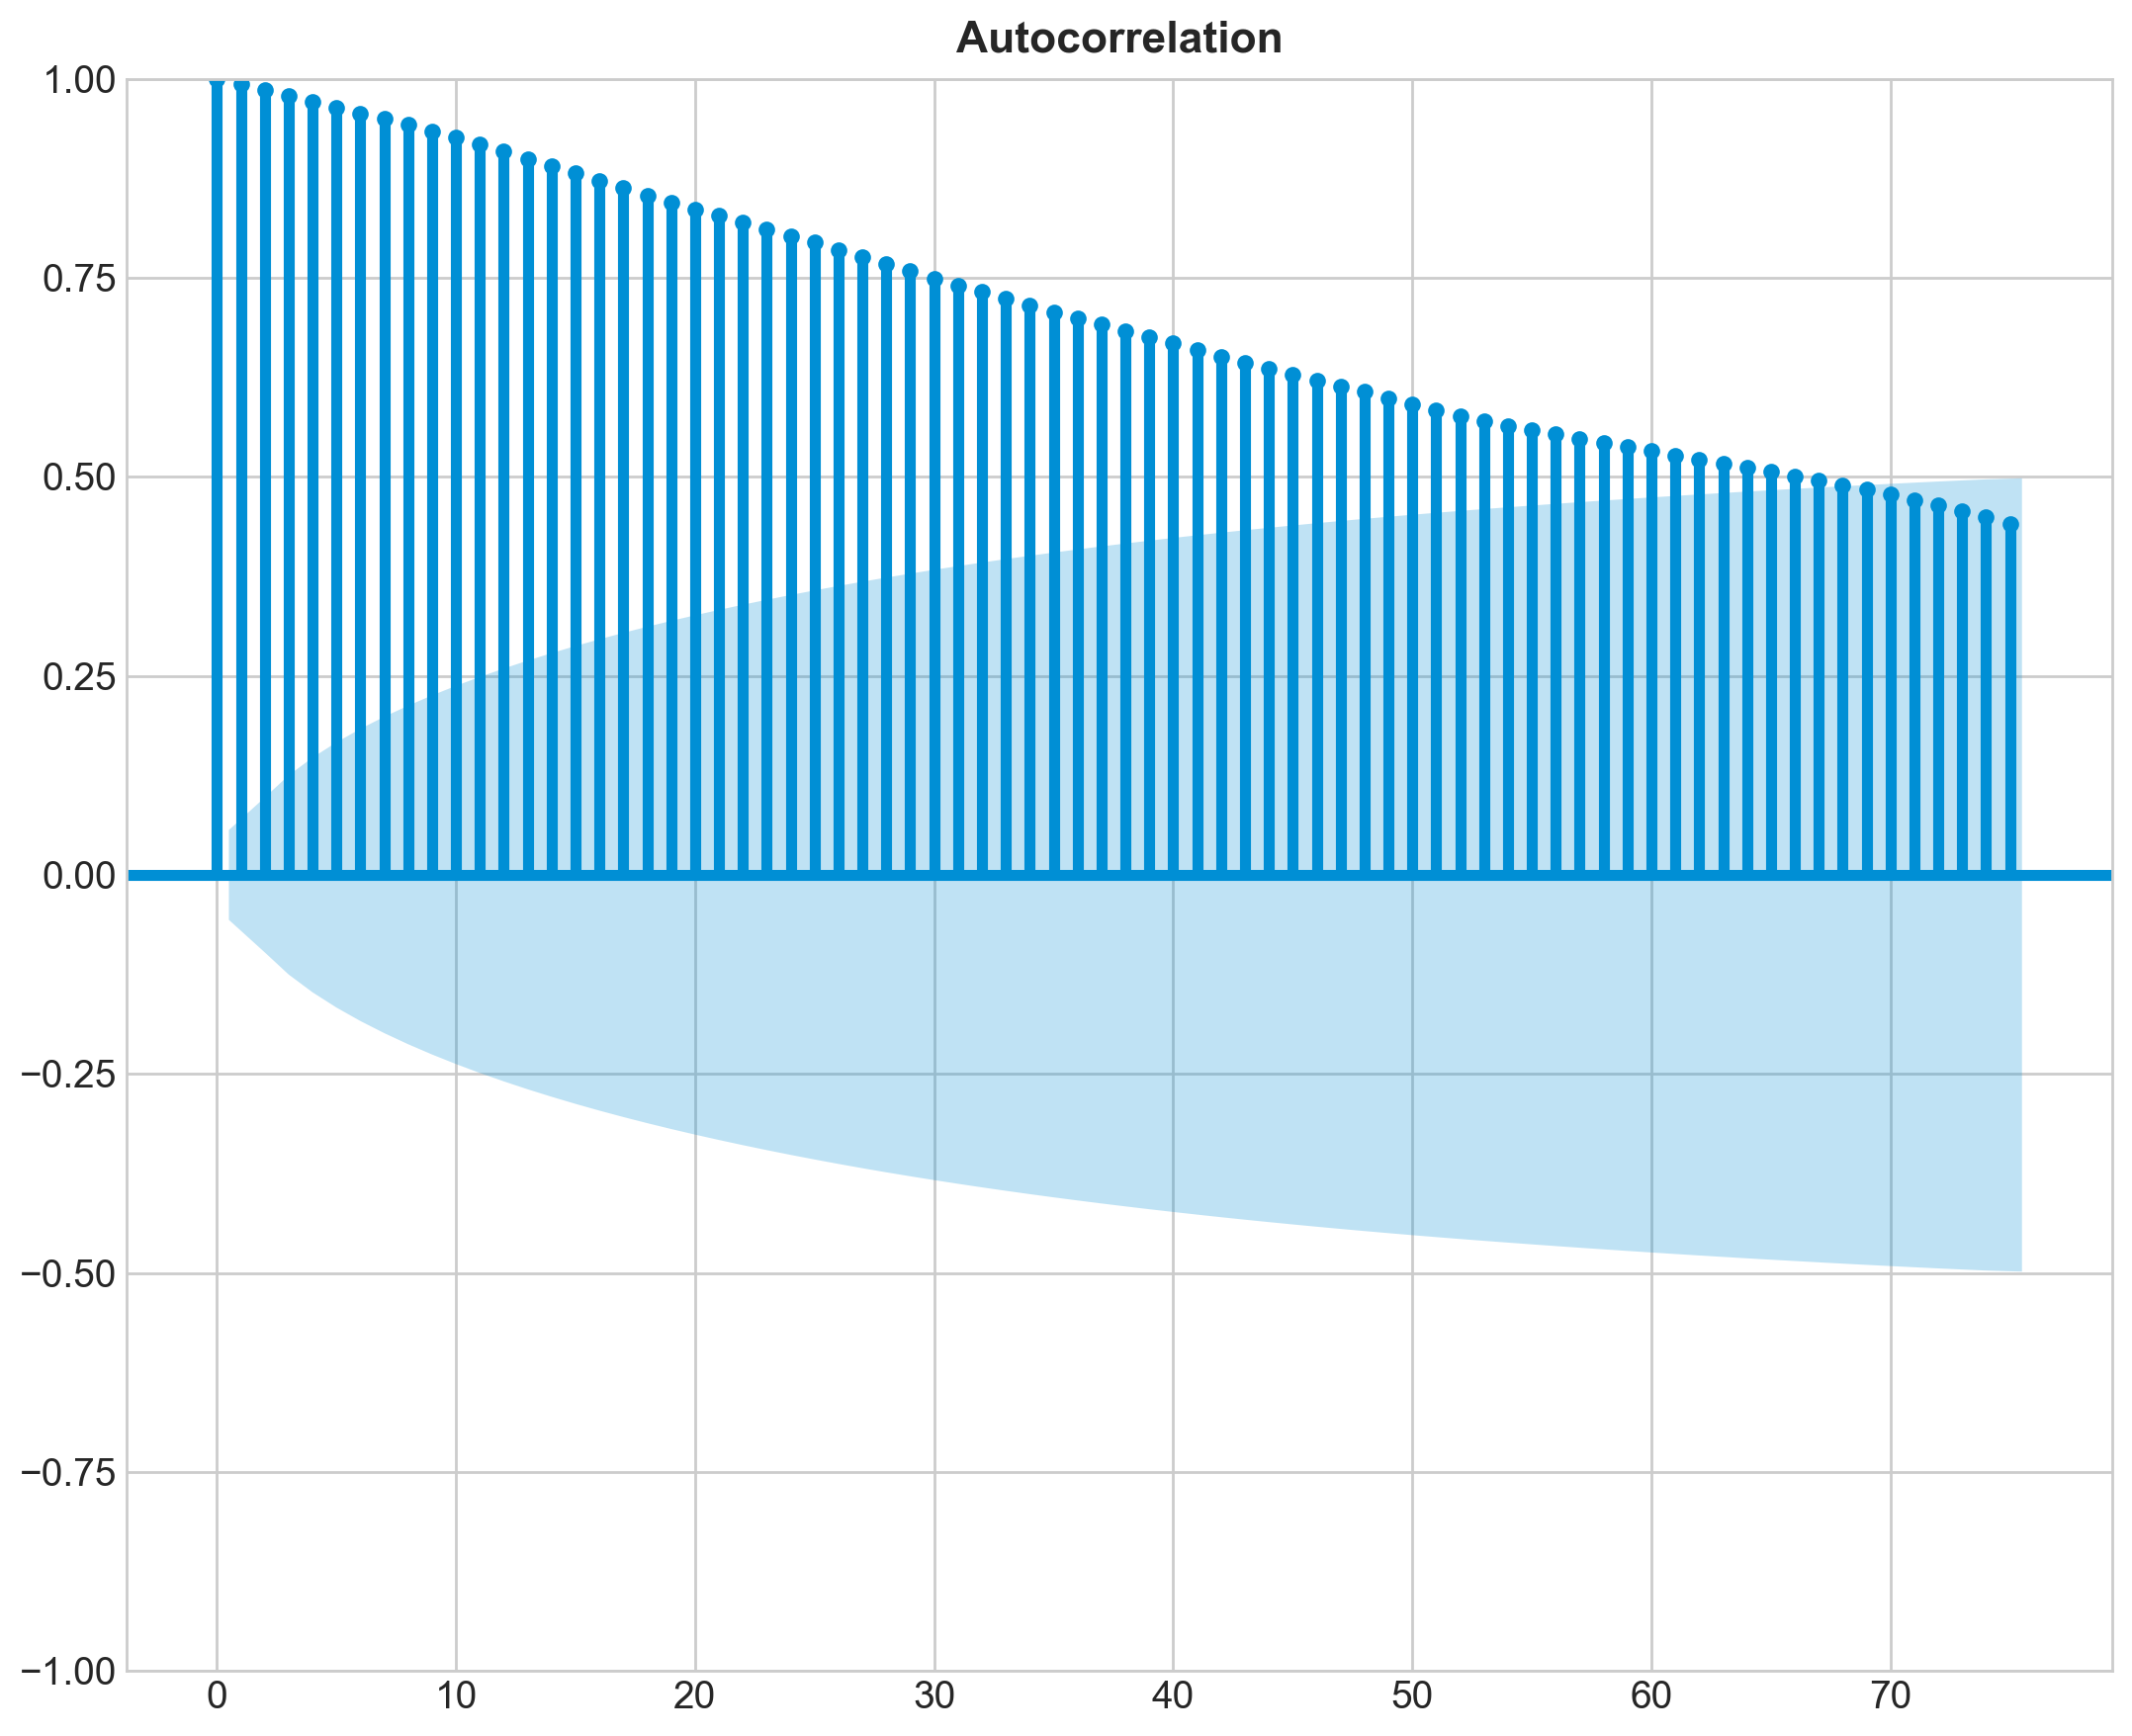

In [30]:
plot_acf(sim2, lags=75)
plt.show()

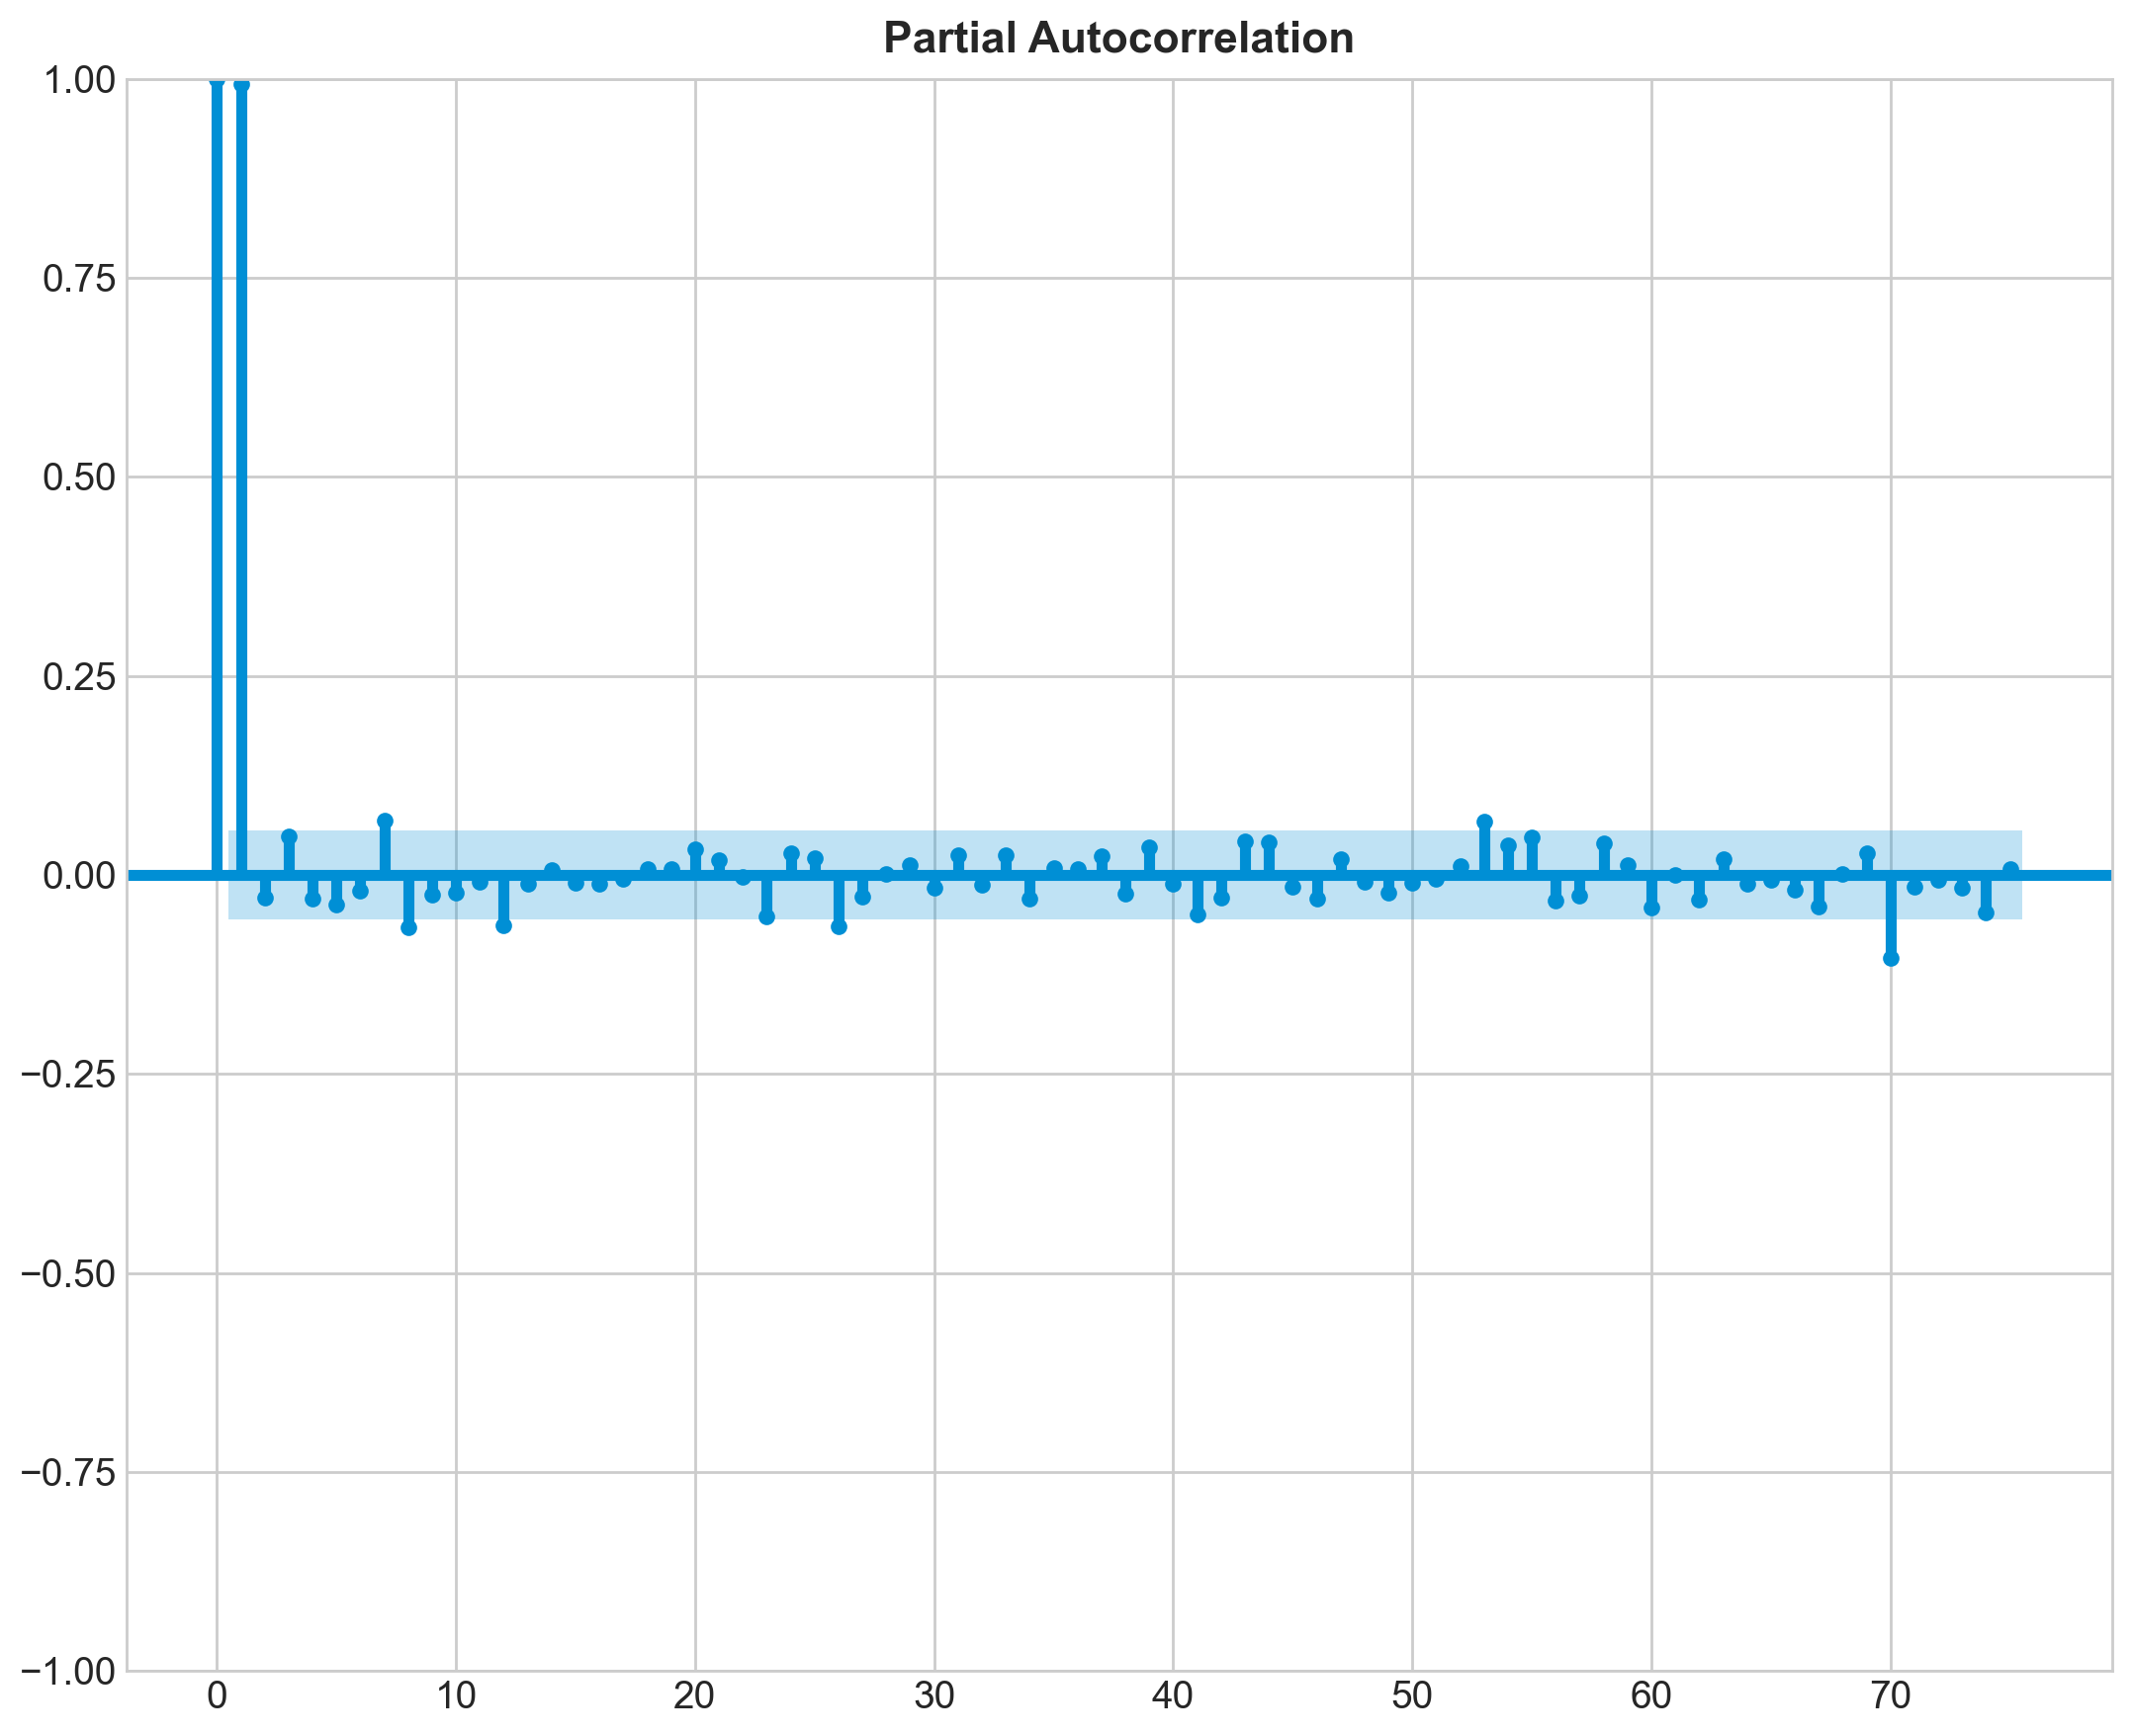

In [31]:
plot_pacf(sim2, lags=75)
plt.show()

In [32]:
d1=sim2-sim2.shift(1)
d1.dropna(inplace=True)

<Axes: xlabel='Date'>

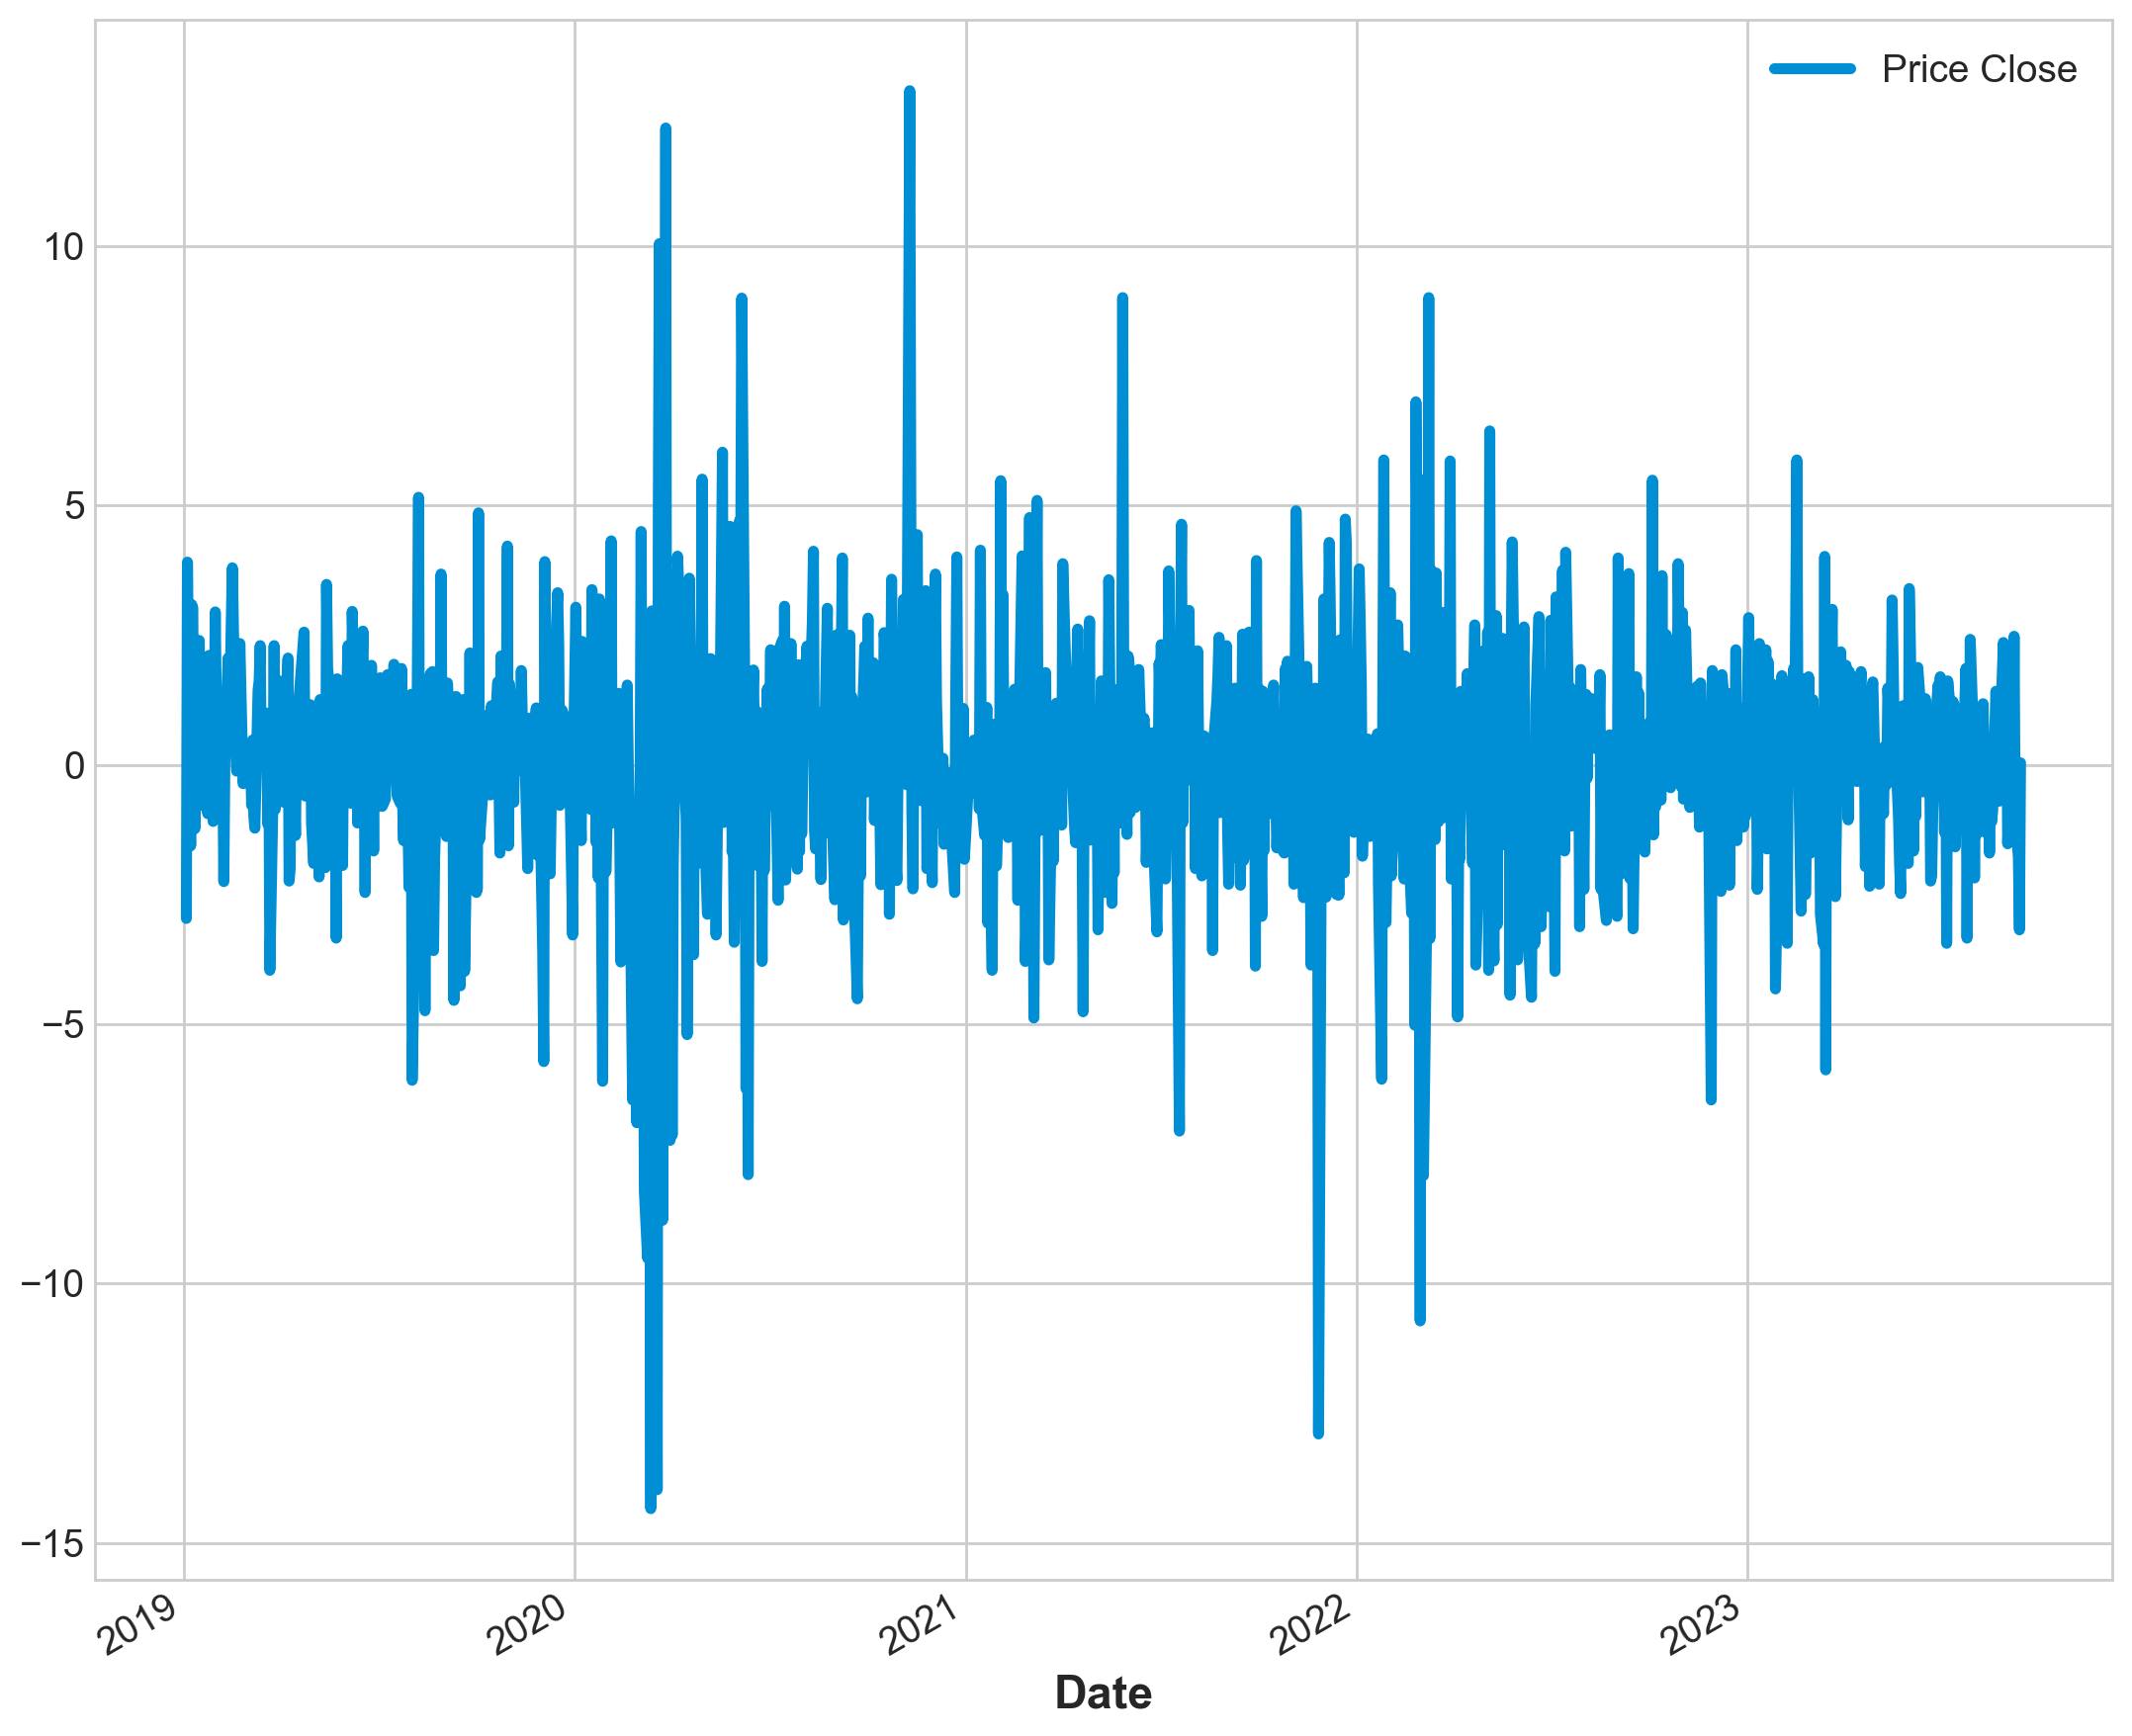

In [33]:
d1.plot()

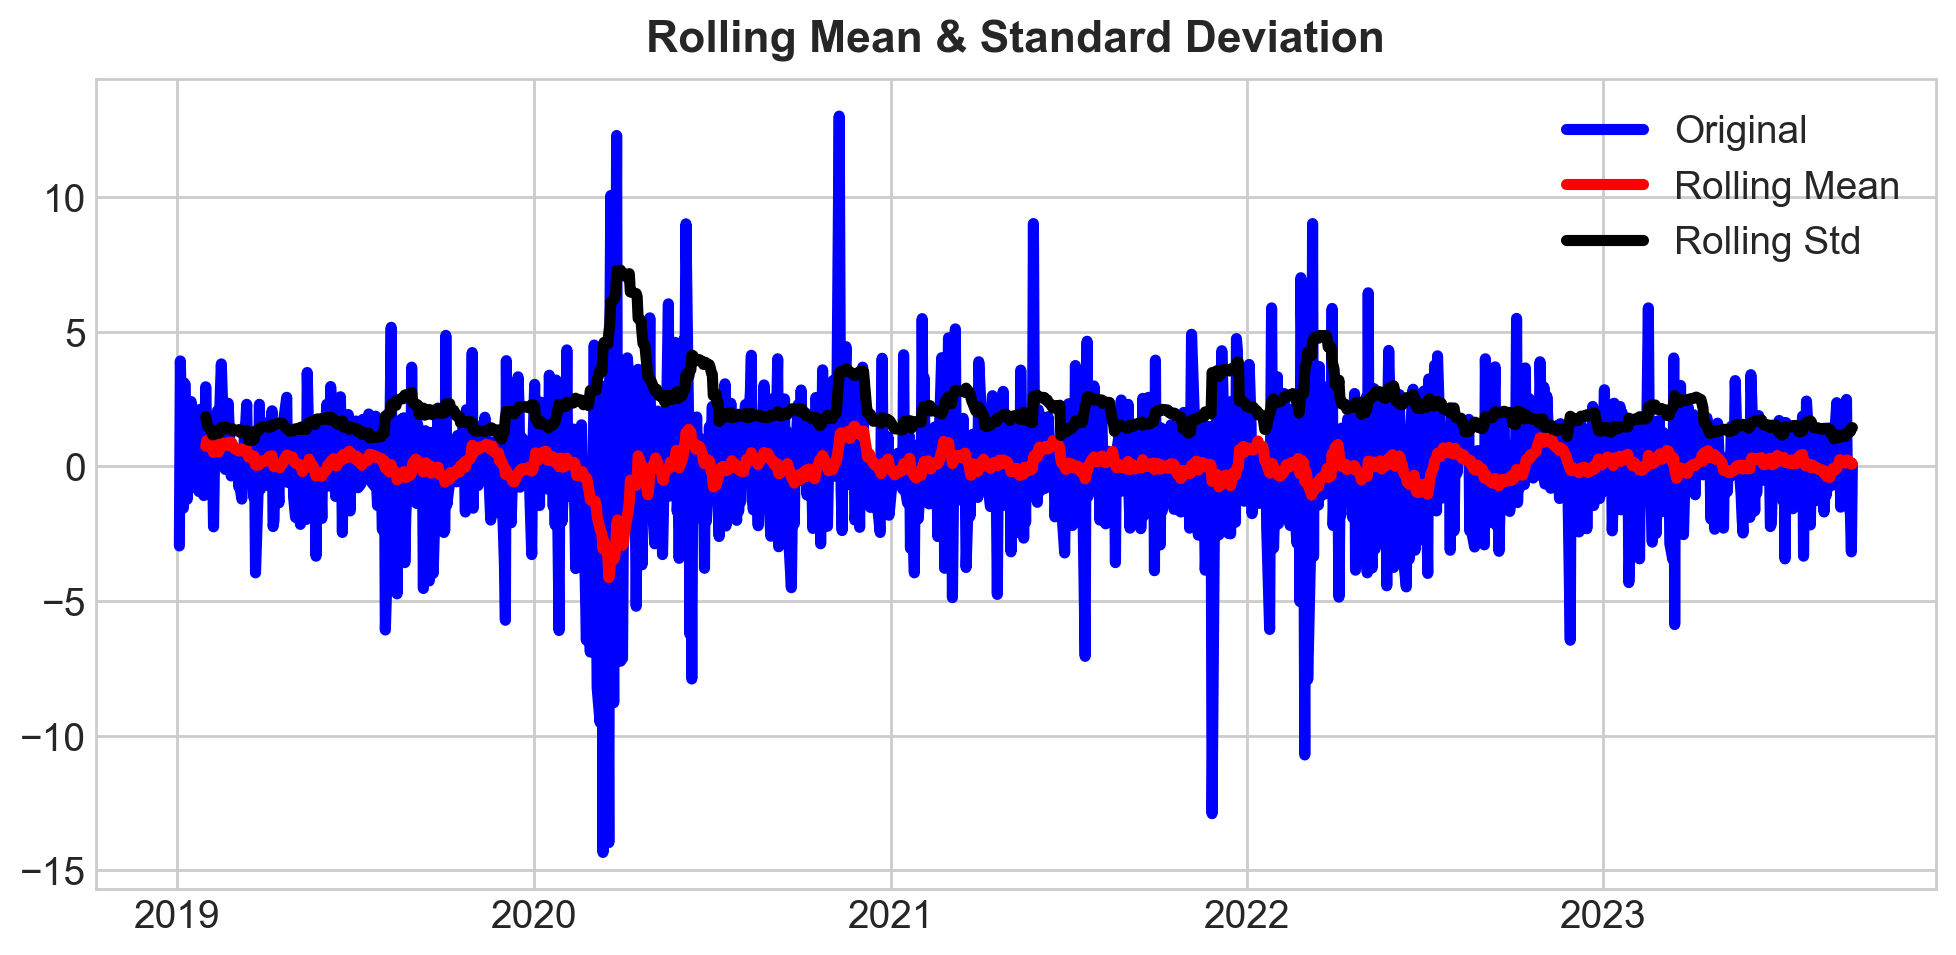

Results of Dickey-Fuller Test:
Test Statistic                -8.871666e+00
p-value                        1.392631e-14
#Lags Used                     1.000000e+01
Number of Observations Used    1.195000e+03
Critical Value (1%)           -3.435834e+00
Critical Value (5%)           -2.863962e+00
Critical Value (10%)          -2.568059e+00
dtype: float64


In [34]:
StationaryTest = test_stationarity(d1)

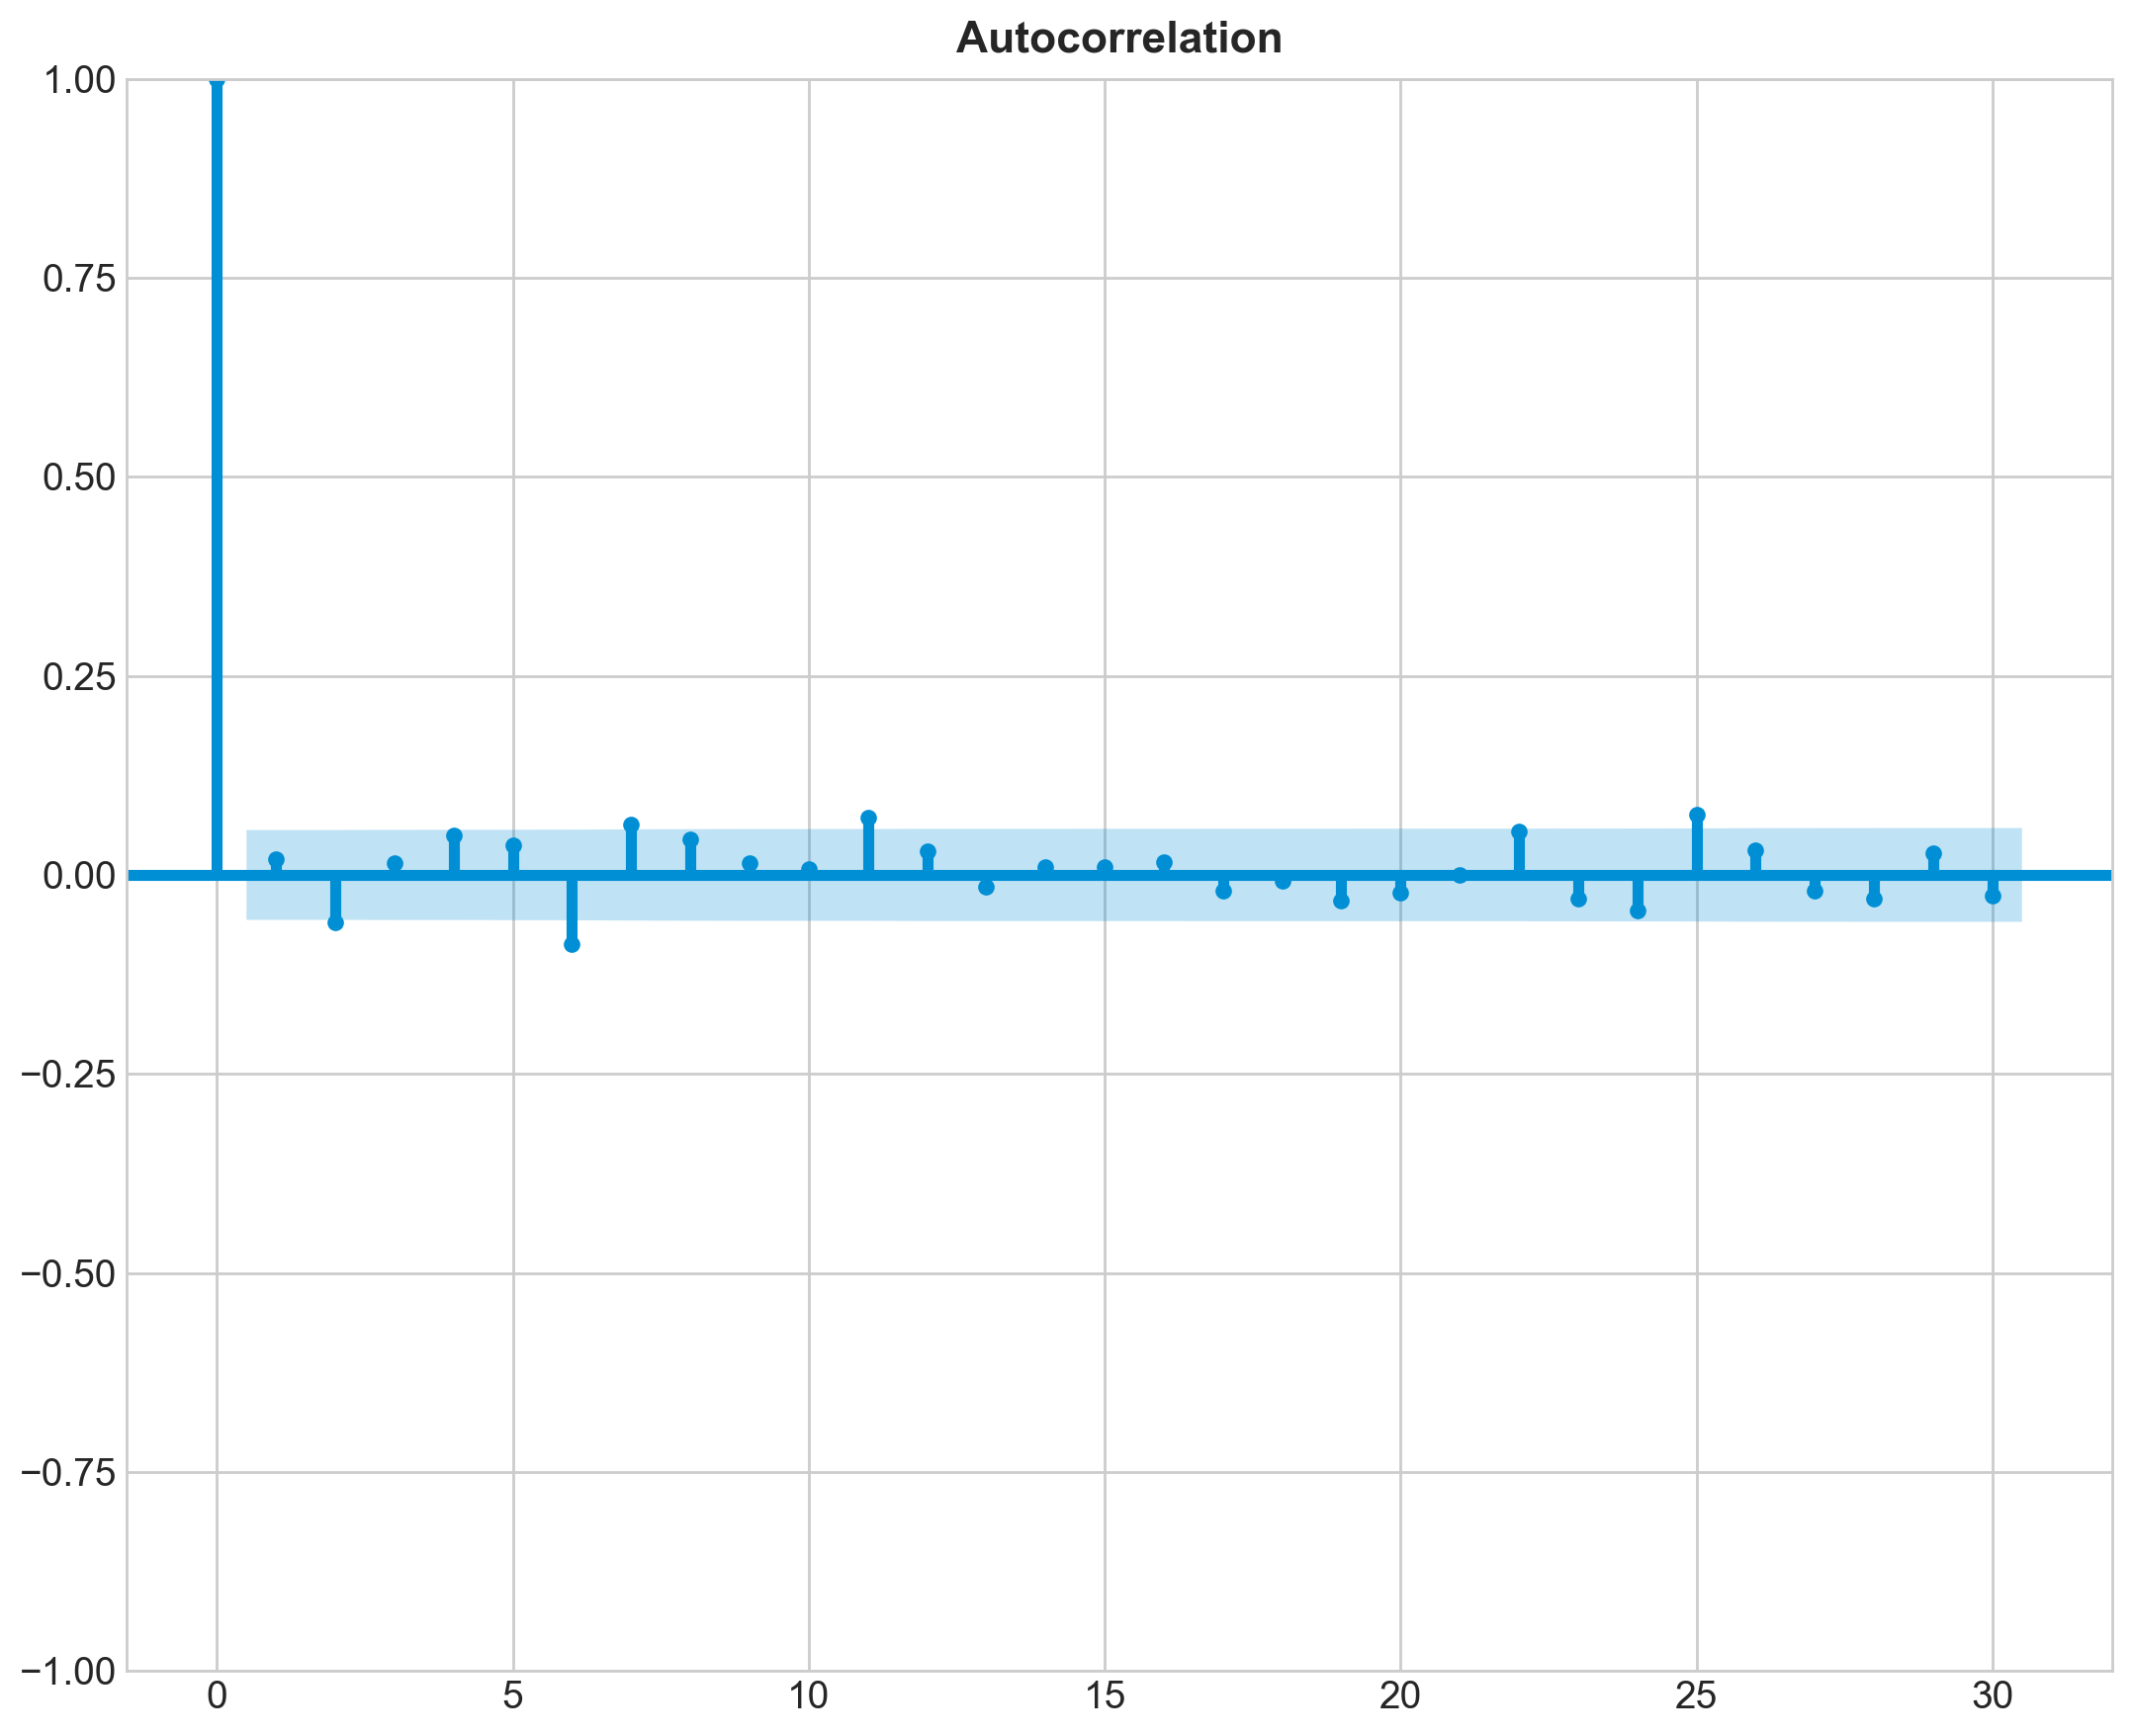

In [35]:
plot_acf(d1, lags=30)
plt.show()

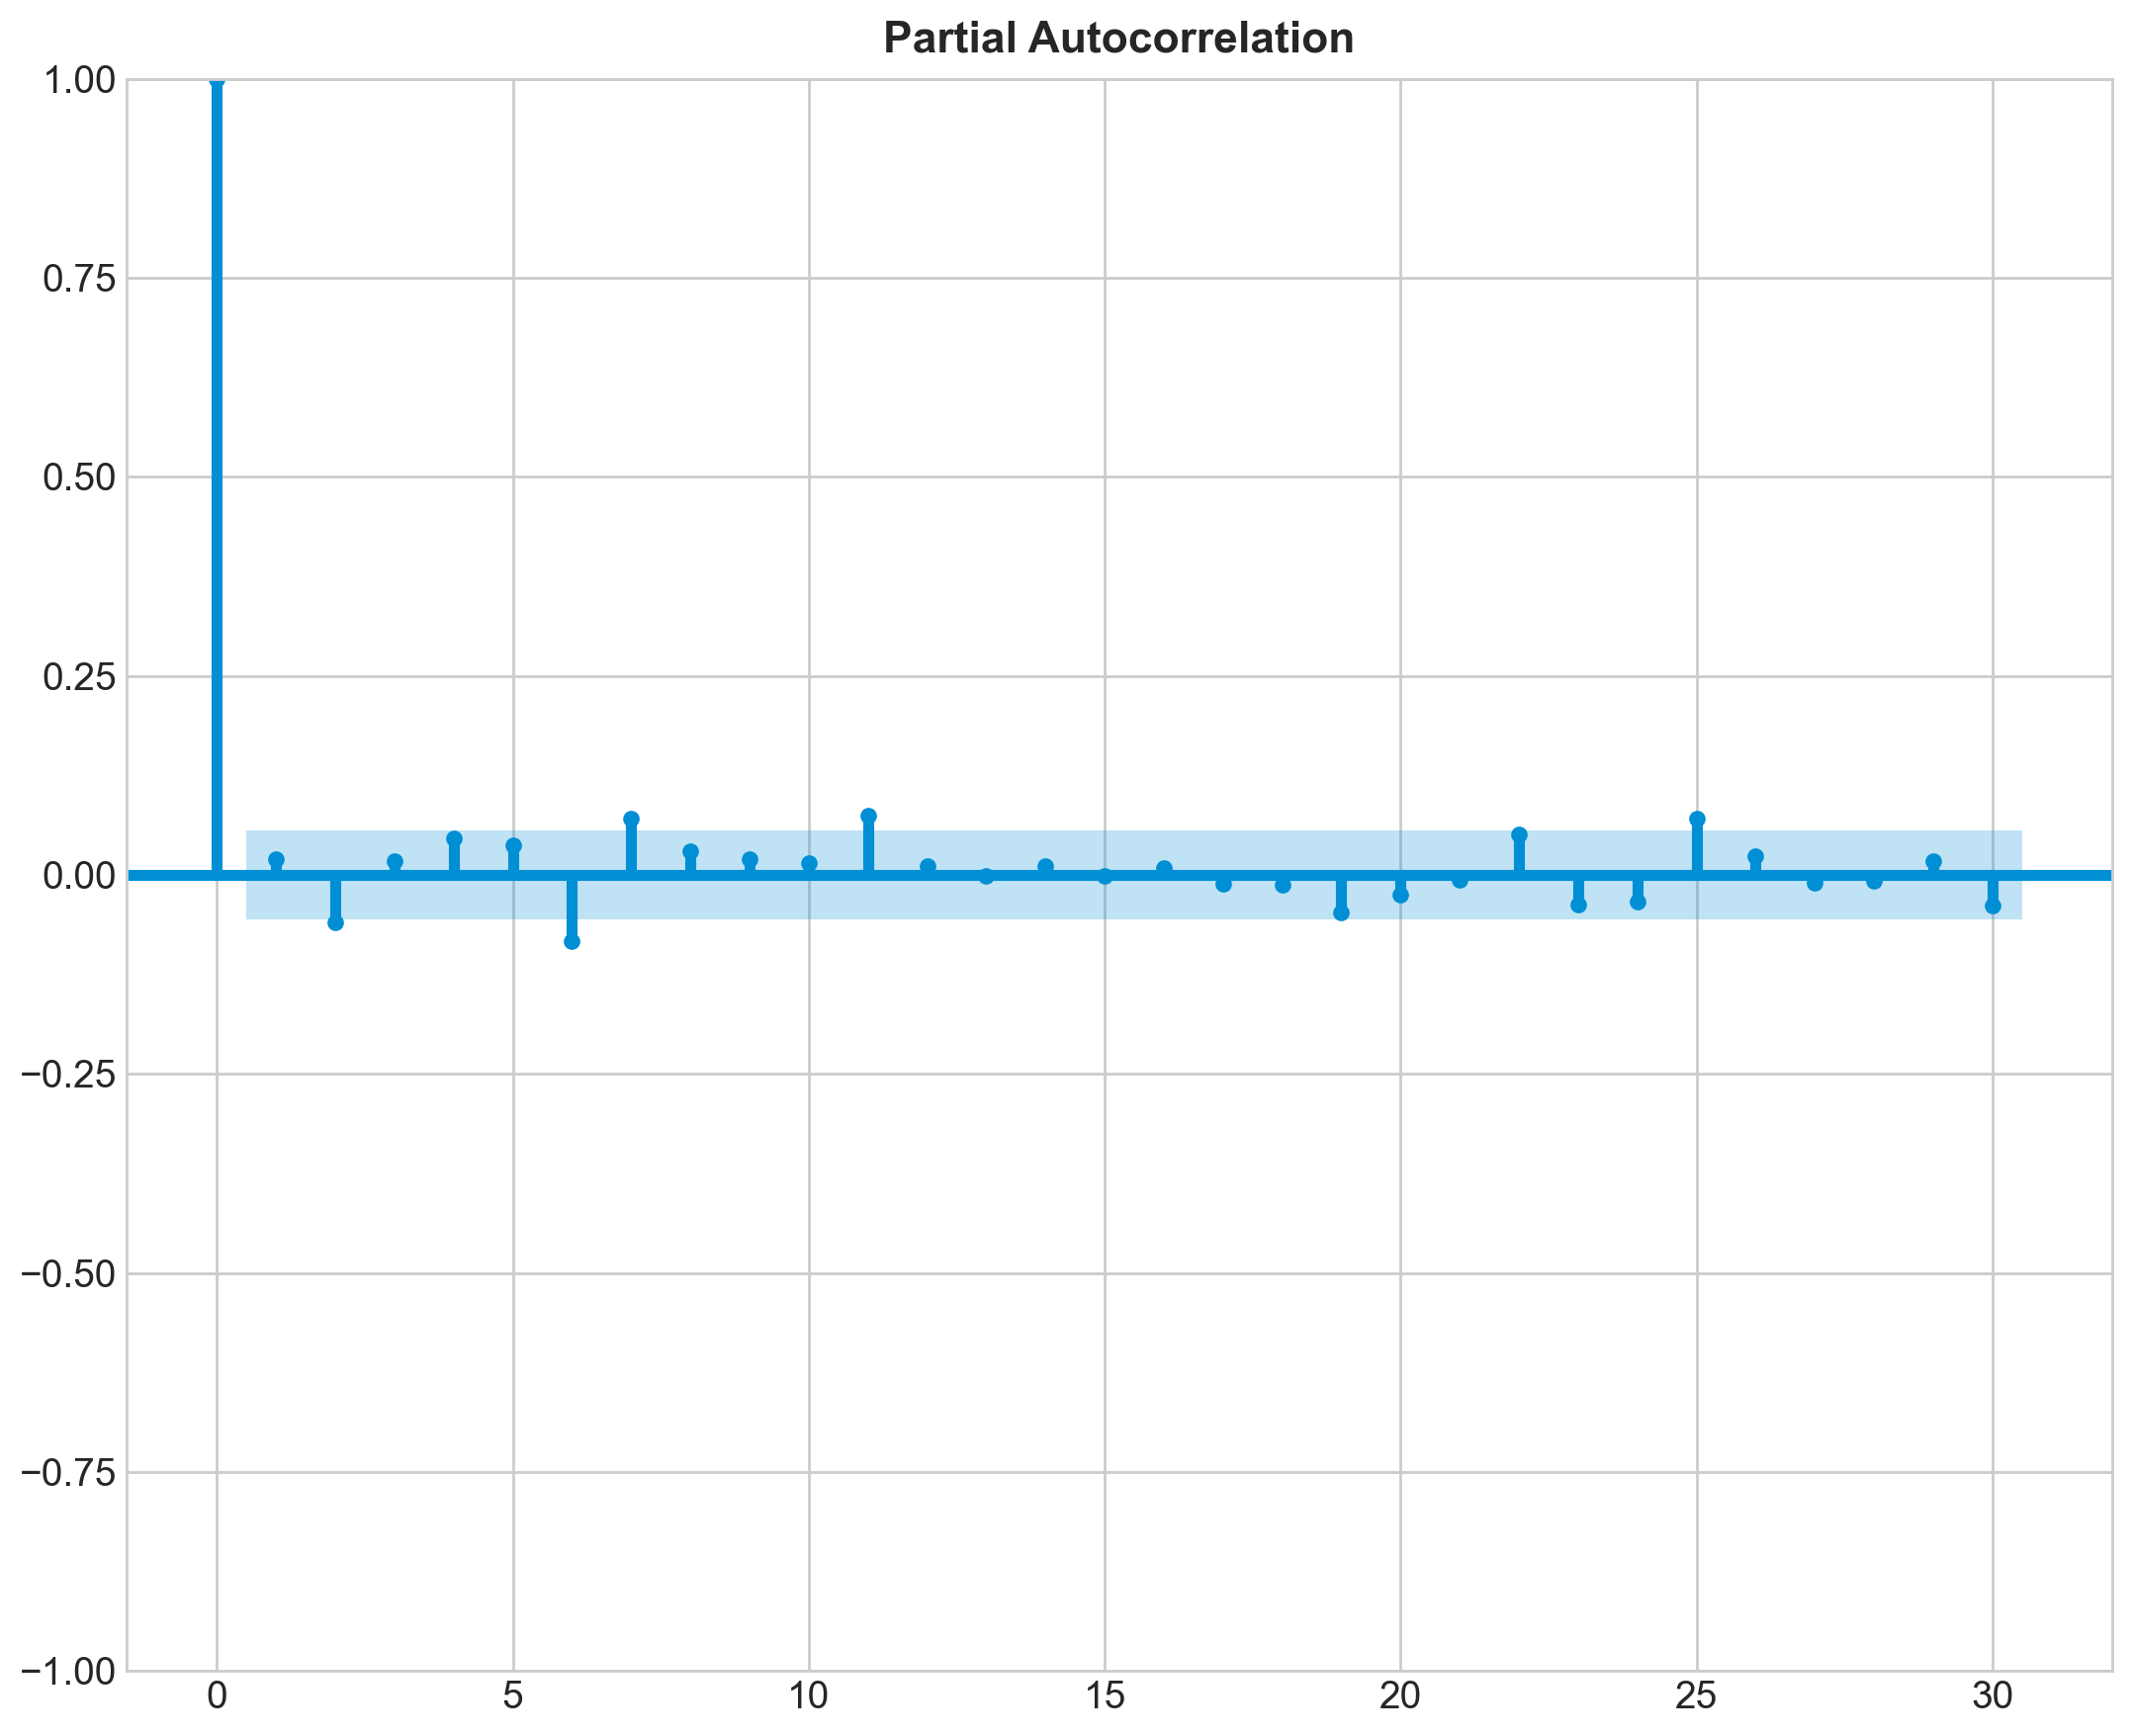

In [36]:
plot_pacf(d1, lags=30)
plt.show()

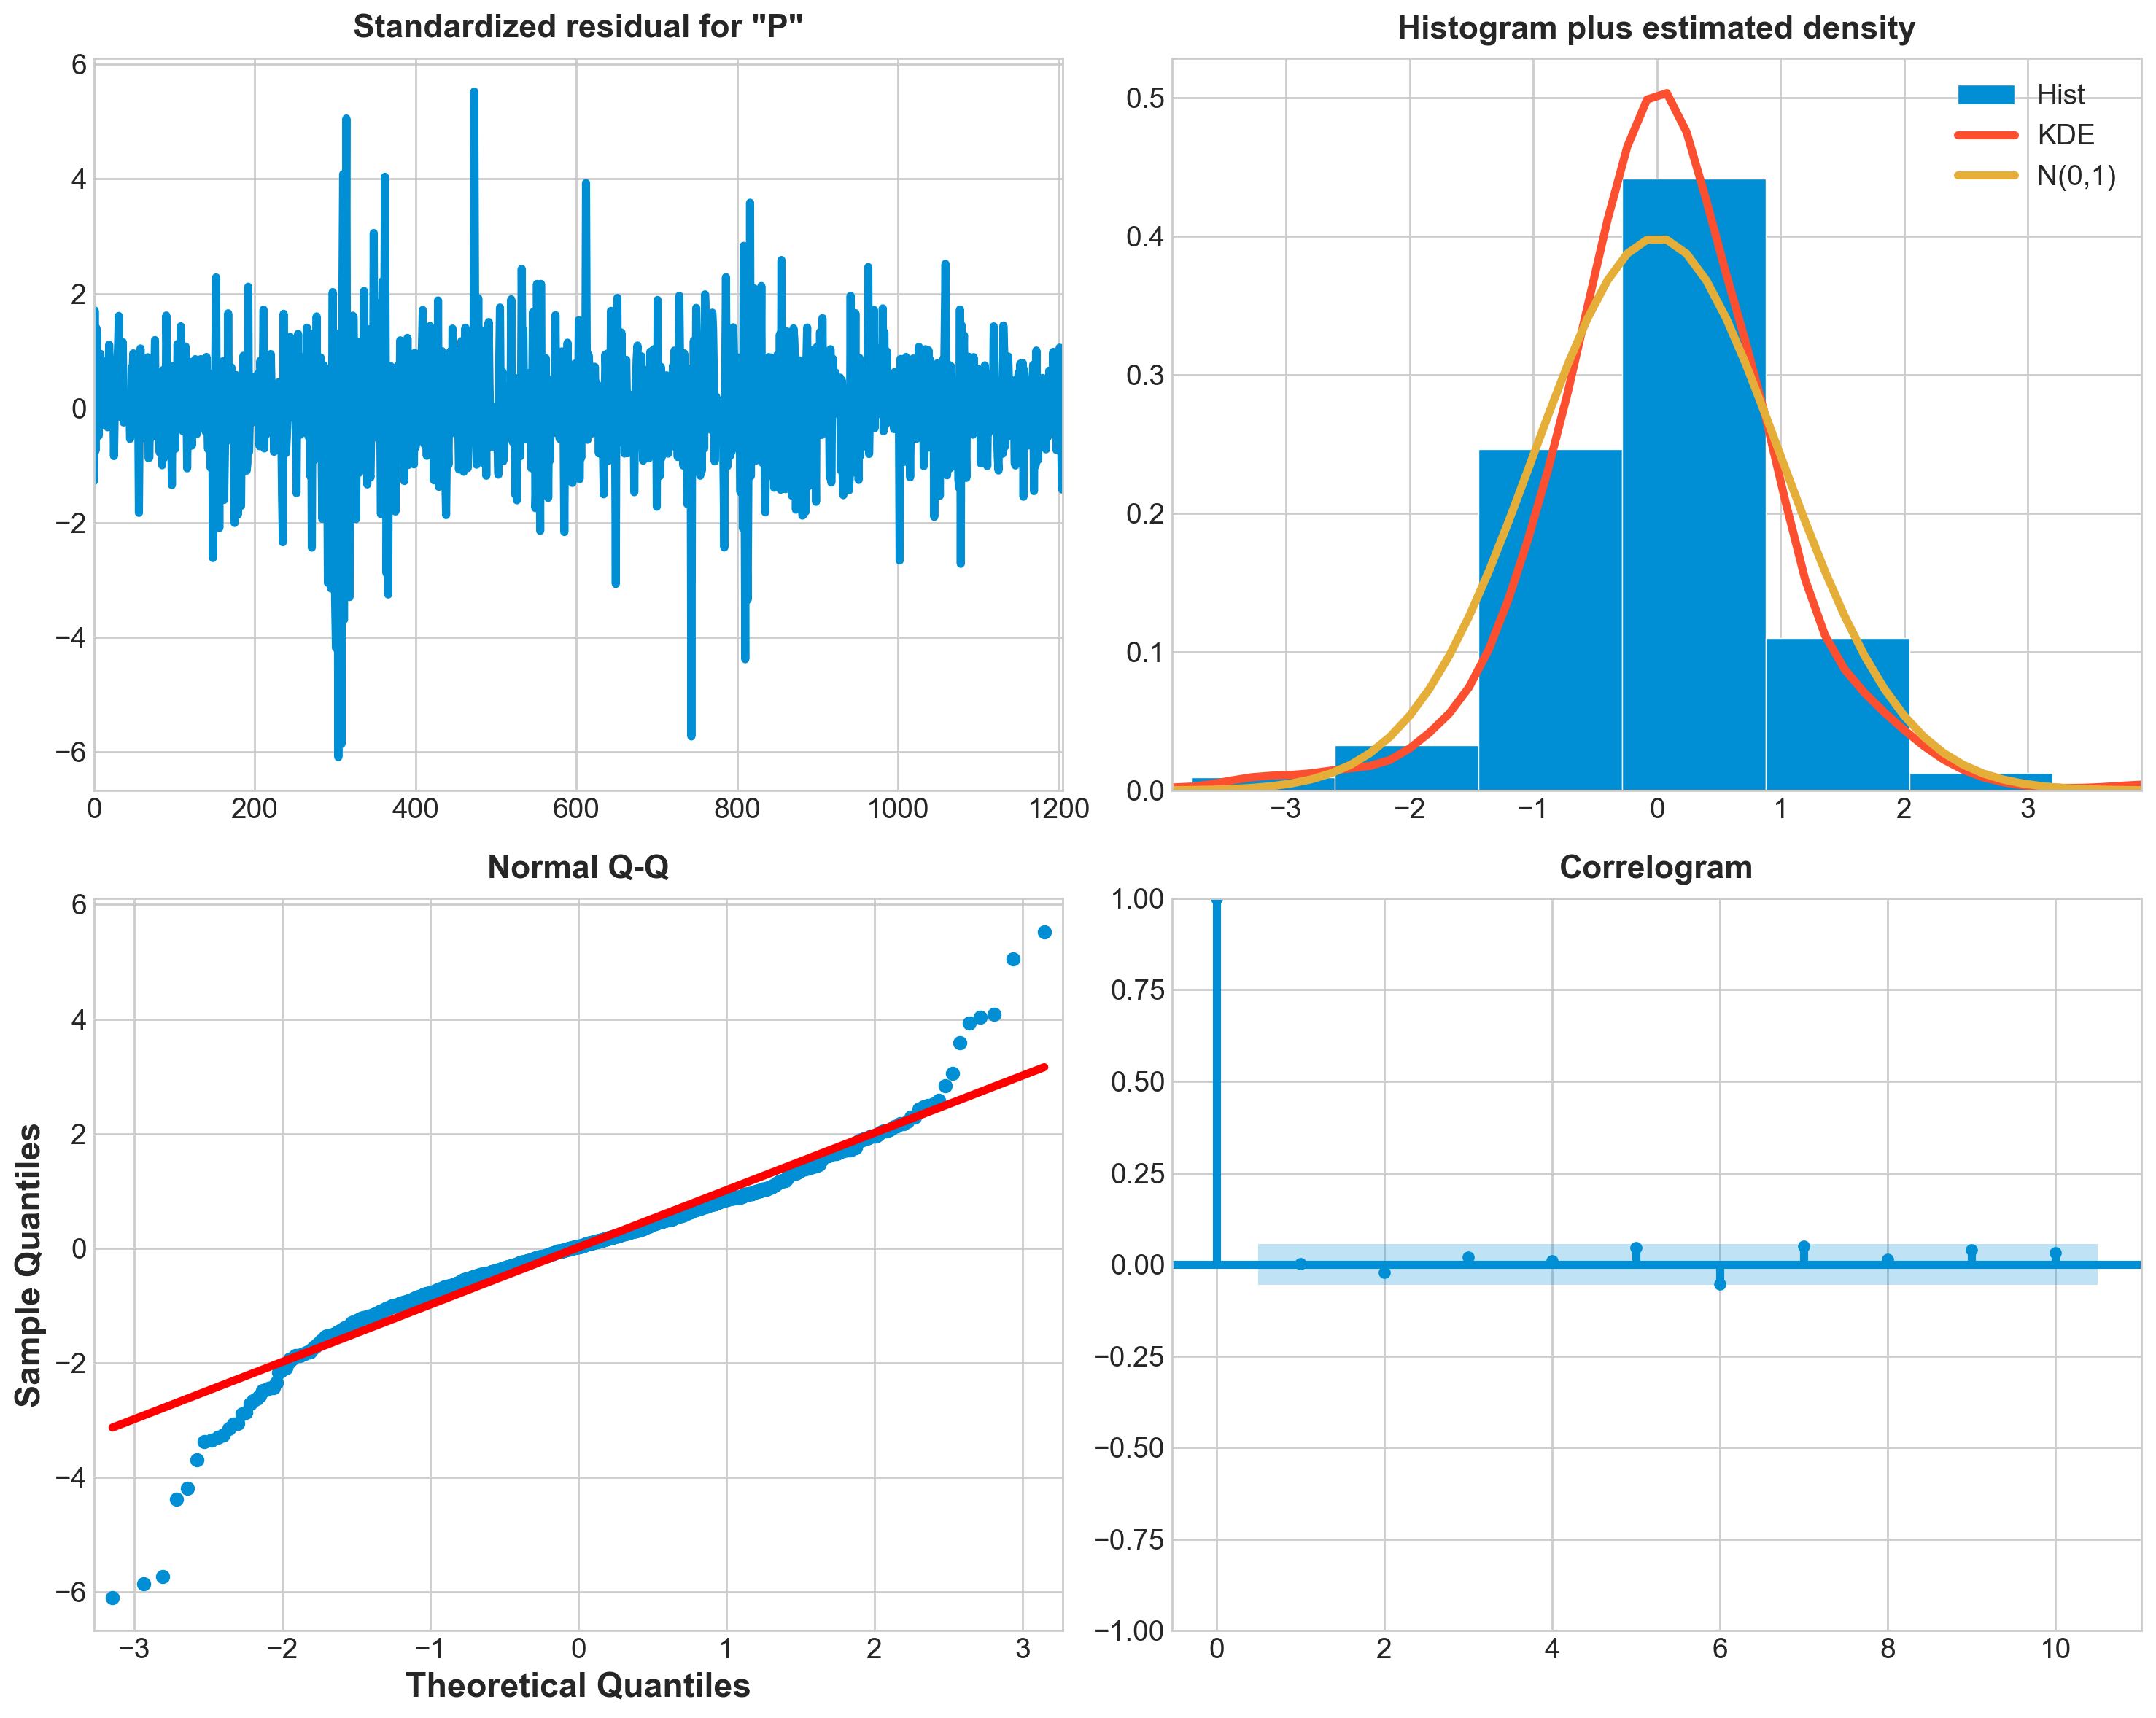

In [37]:
mod = sm.tsa.statespace.SARIMAX(sim2,
                                order=(2, 1, 2))

results2 = mod.fit()

results2.plot_diagnostics(figsize=(15, 12))
plt.show()

In [38]:
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Price Close   No. Observations:                 1207
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -2713.333
Date:                Mon, 16 Oct 2023   AIC                           5436.666
Time:                        02:52:42   BIC                           5462.142
Sample:                             0   HQIC                          5446.260
                               - 1207                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3088      0.009    -36.205      0.000      -0.326      -0.292
ar.L2         -0.9860      0.007   -135.054      0.000      -1.000      -0.972
ma.L1          0.3296      0.012     27.736      0.000       0.306       0.353
ma.L2          0.9757      0.011     88.261      0.000       0.954       0.997
sigma2         5.2672      0.119     44.317      0.000       5.034       5.500
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1512.26
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.64   Skew:                            -0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

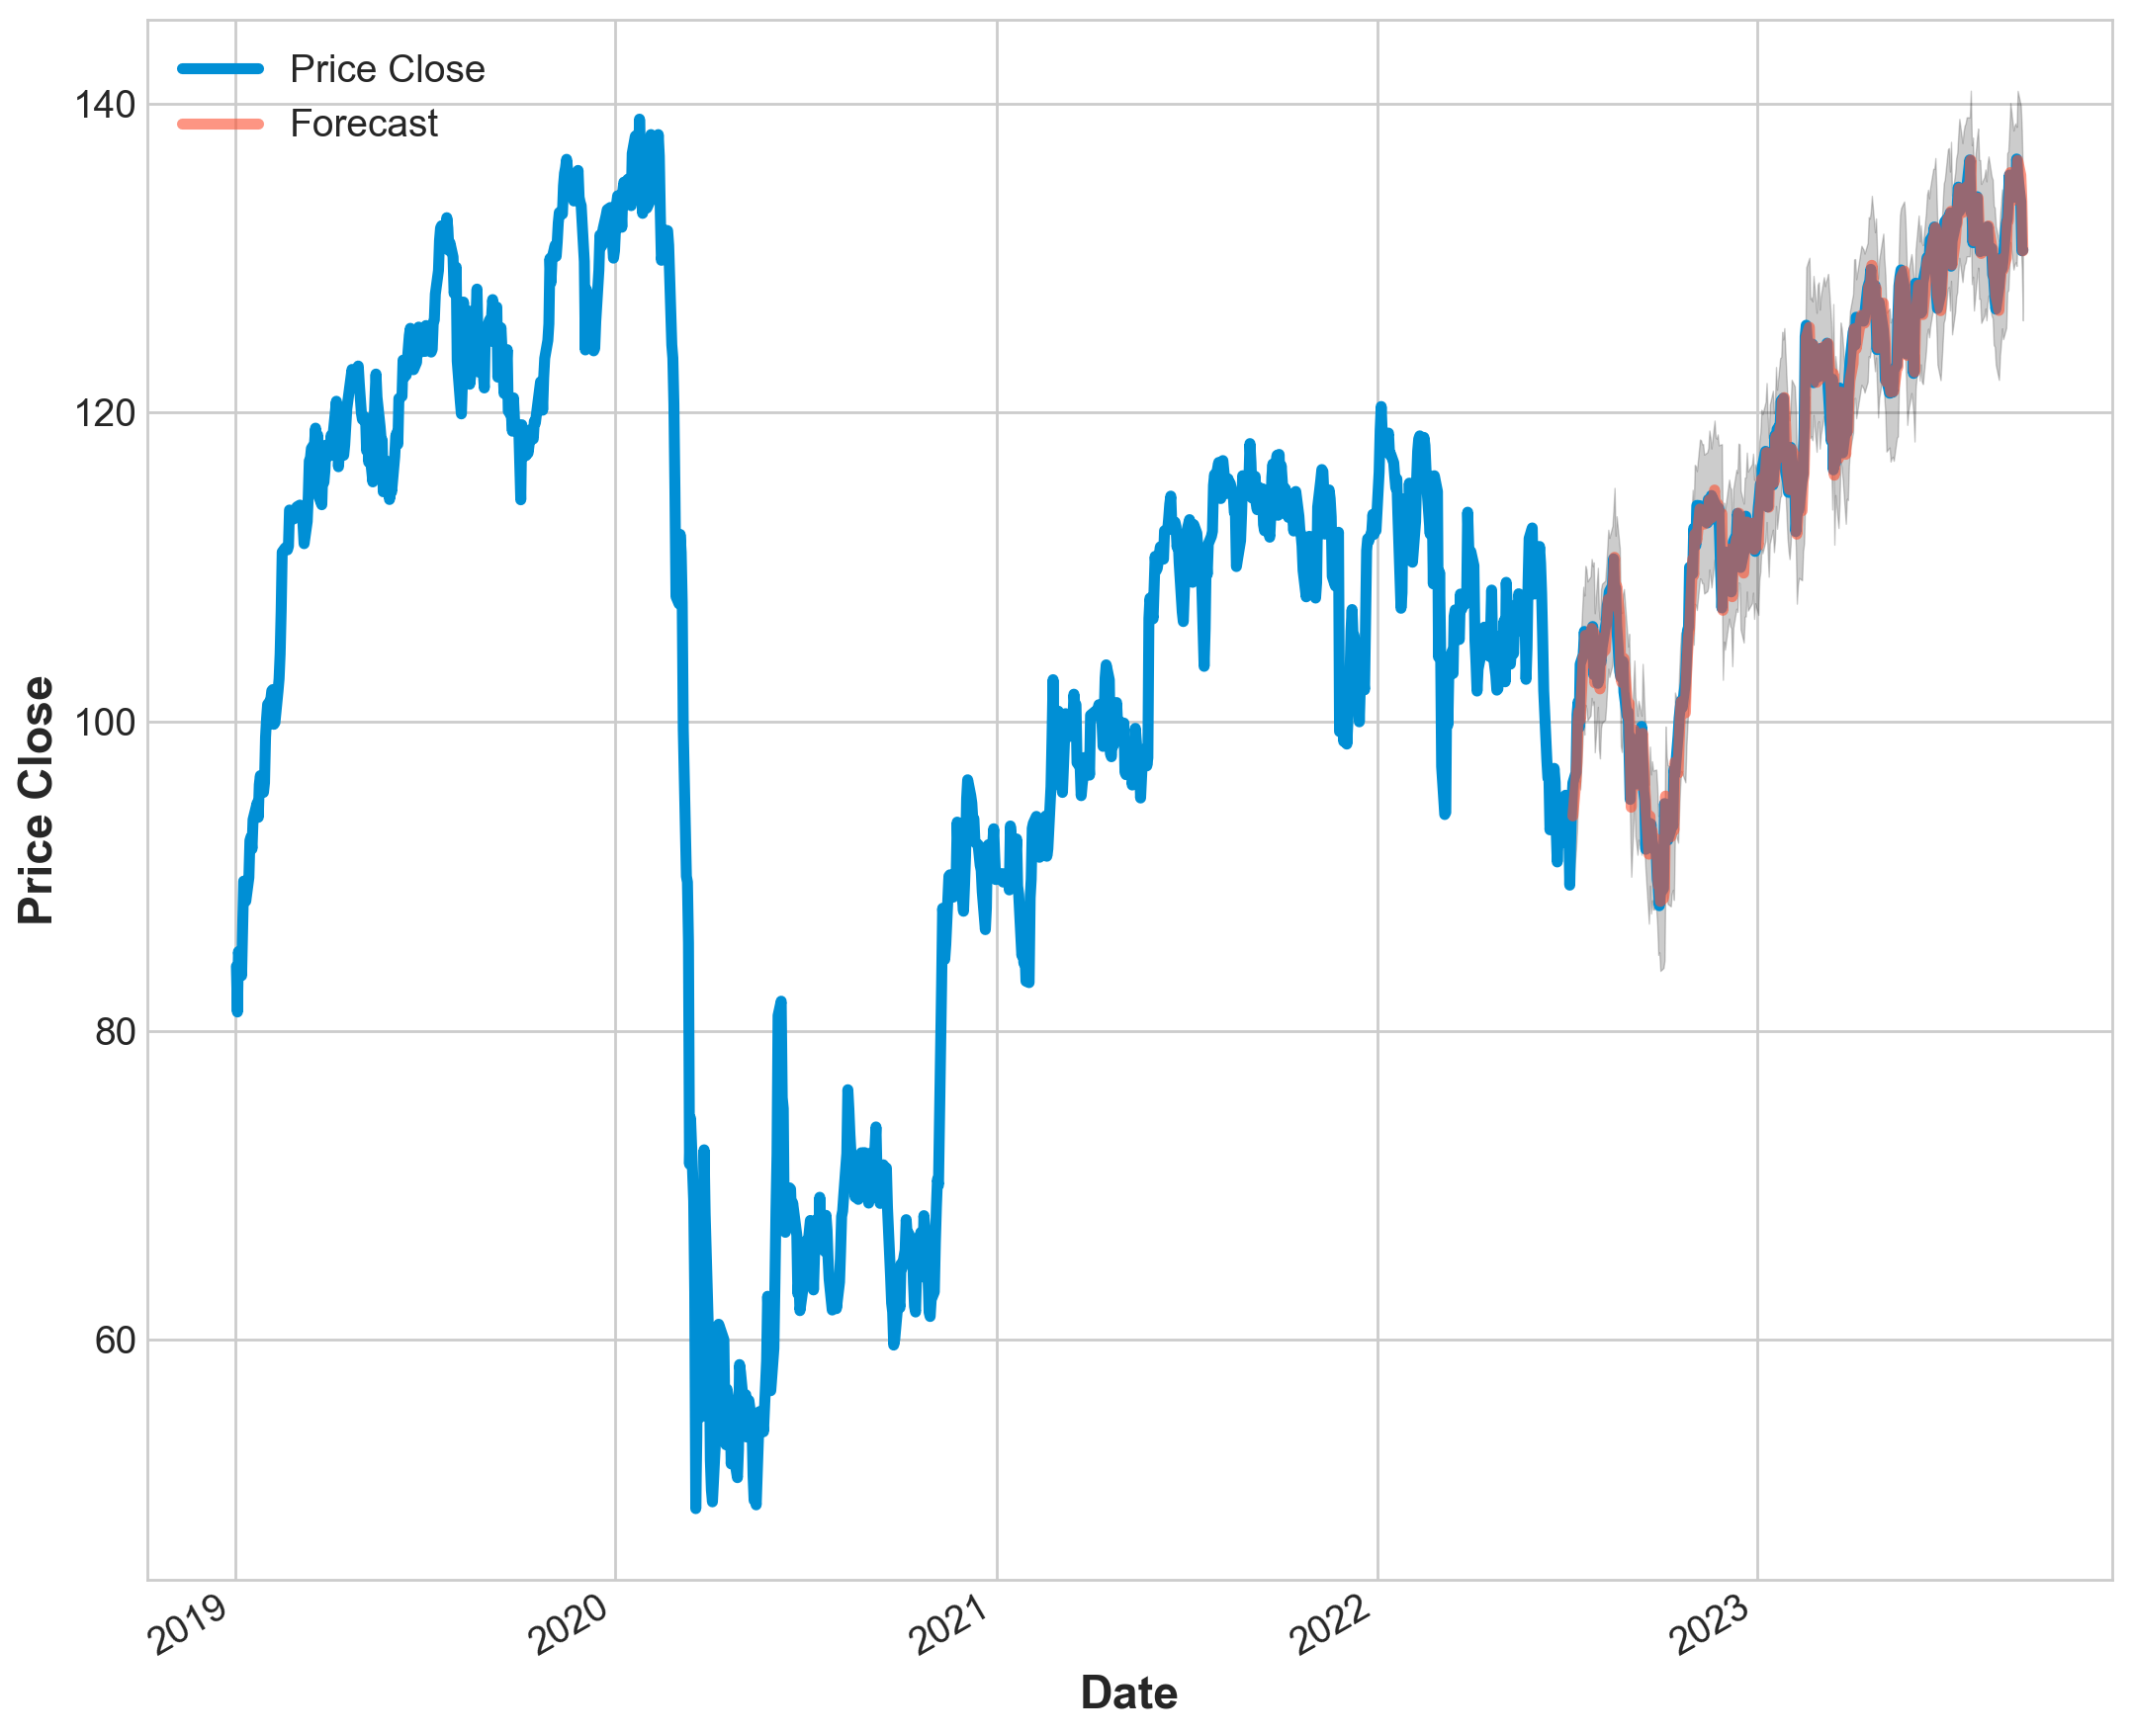

In [39]:
pred2 = results2.get_prediction(start=902, dynamic=False)
pred_ci2 = pred2.conf_int()
#Returns the confidence interval of the fitted parameters.

ax = sim2.plot(label='observed')
pred2.predicted_mean.plot(ax=ax, label='Forecast', alpha=.6)

ax.fill_between(pred_ci2.index, pred_ci2.iloc[:, 0], pred_ci2.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Price Close')
plt.legend()

plt.show()

In [40]:
predictions = results2.predict(902,1206)
rmse = mean_squared_error(sim2[902:], predictions)**0.5
print(f"RMSE: {rmse:.2f}\n")

RMSE: 1.71



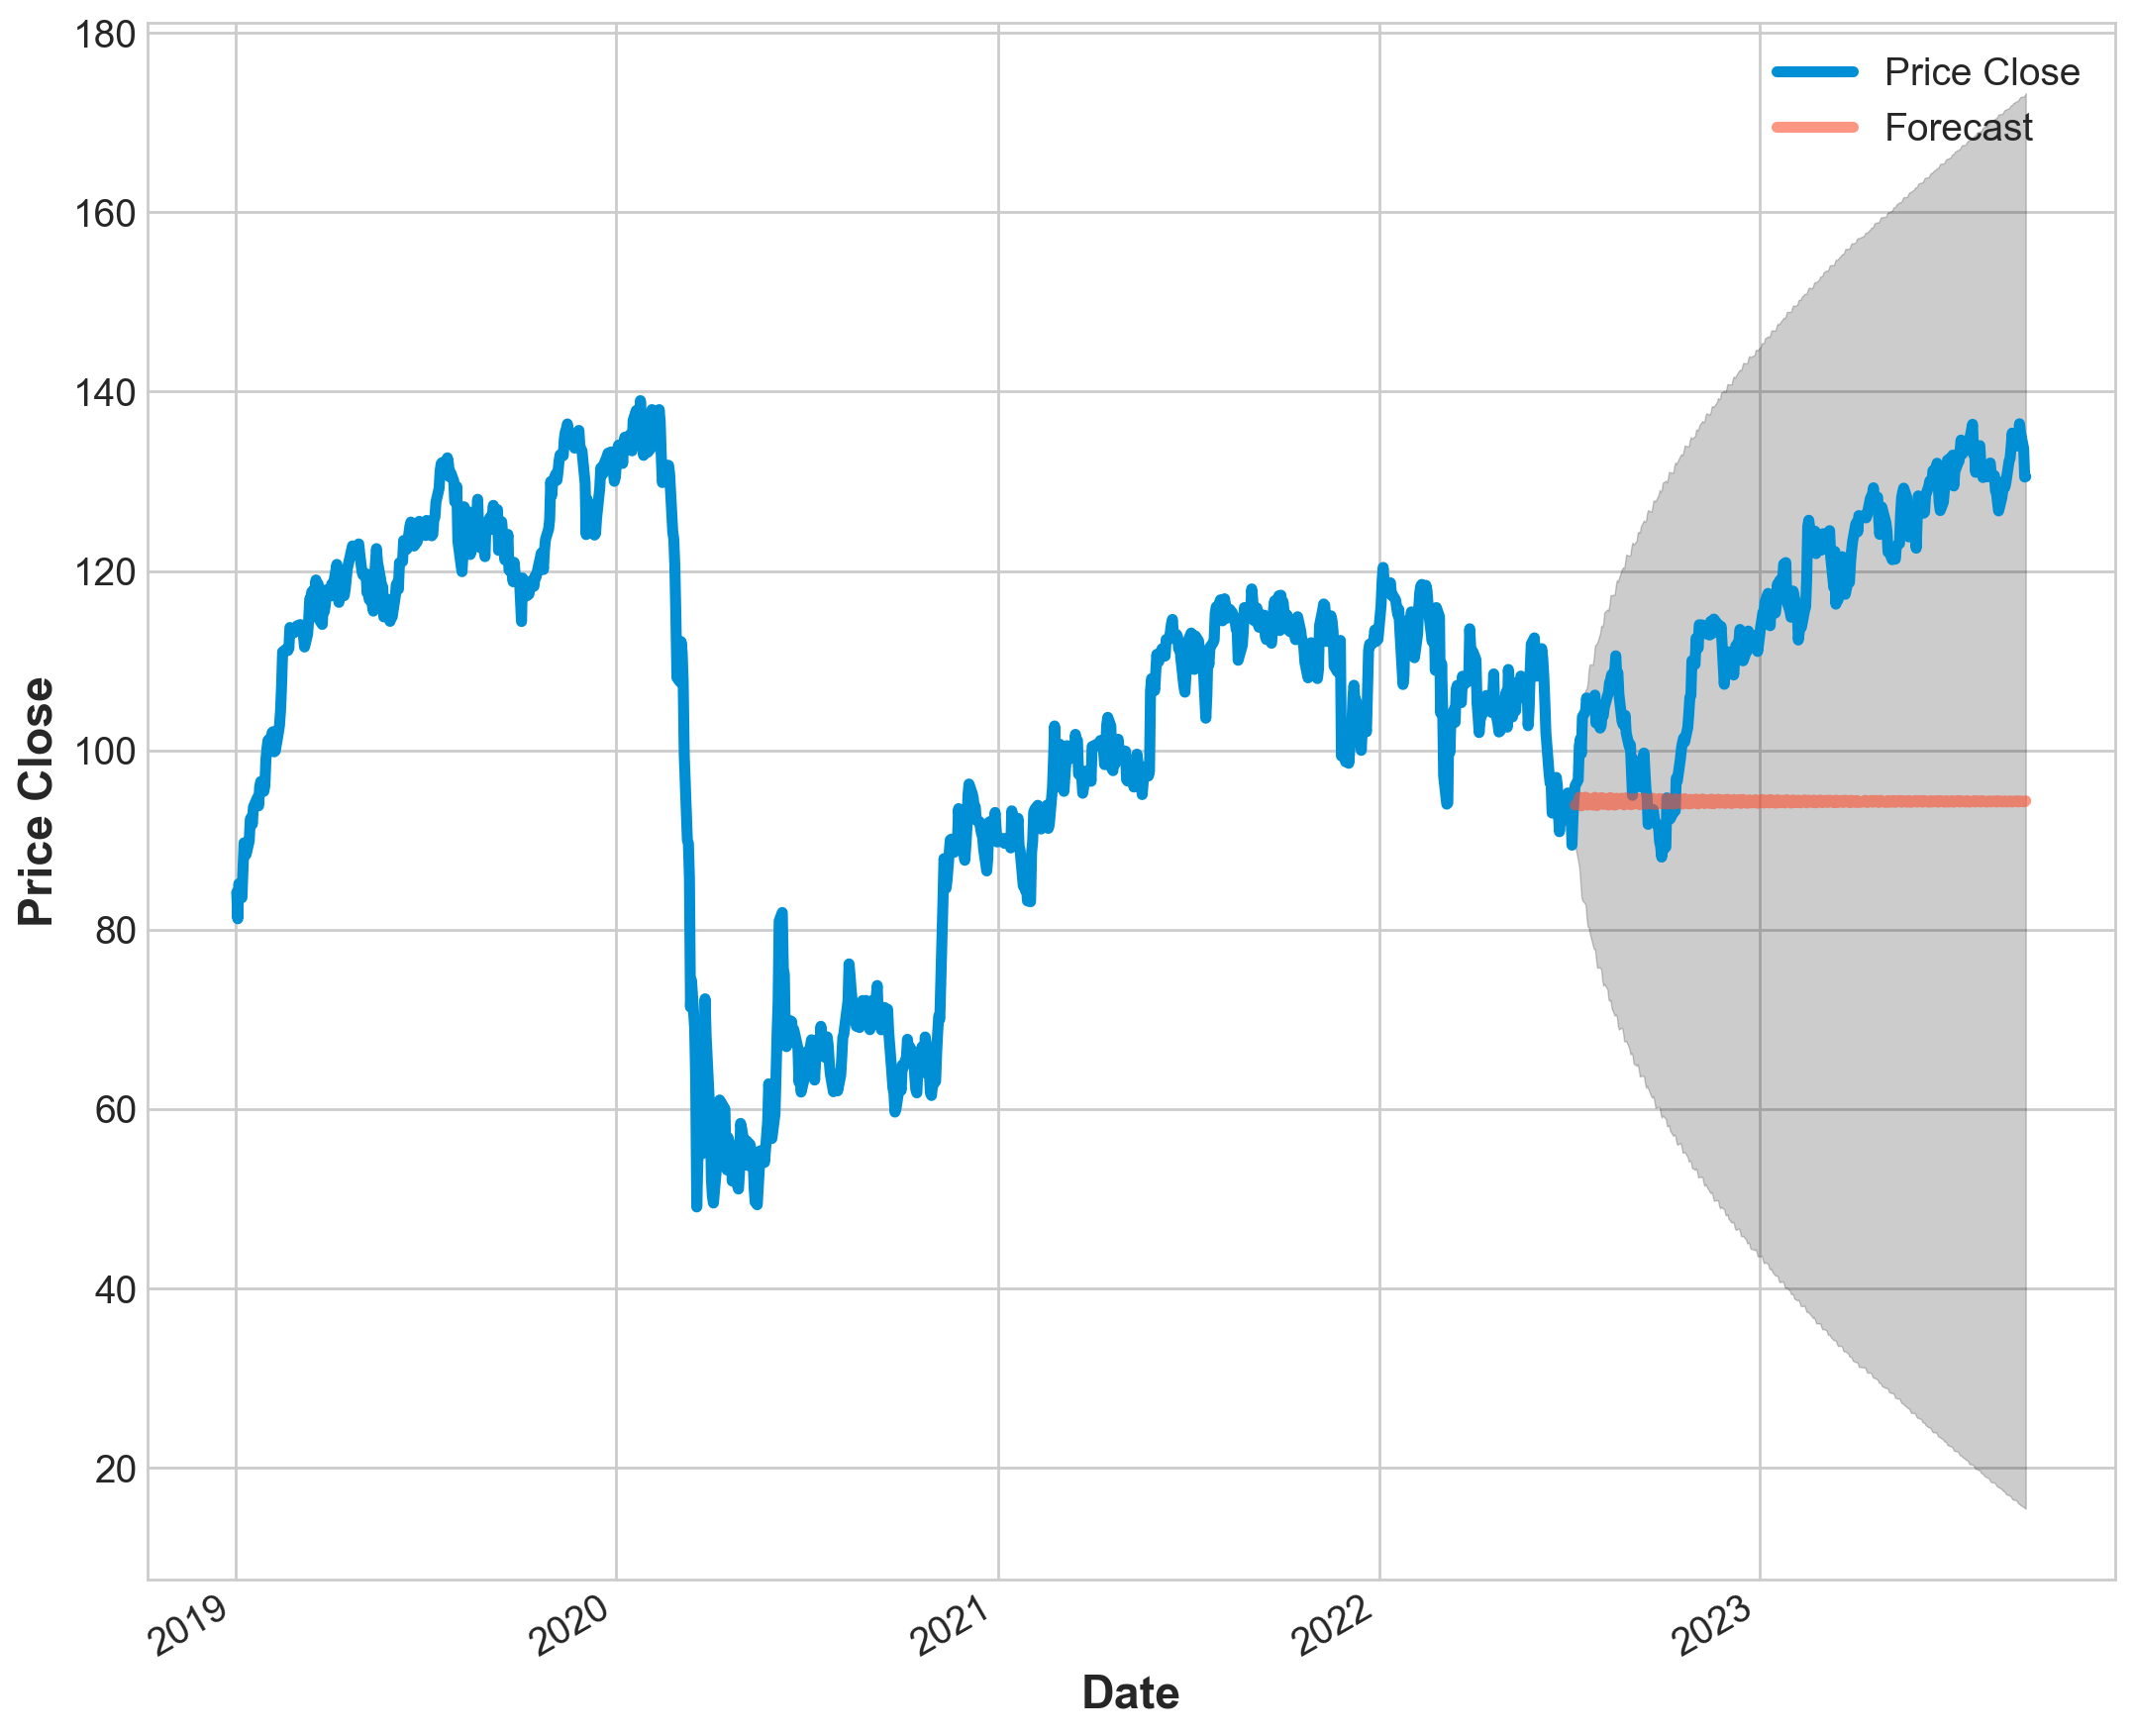

In [41]:
pred2 = results2.get_prediction(start=902, dynamic=True)
pred_ci2 = pred2.conf_int()

ax = sim2.plot(label='observed')
pred2.predicted_mean.plot(ax=ax, label='Forecast', alpha=.6)

ax.fill_between(pred_ci2.index, pred_ci2.iloc[:, 0], pred_ci2.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Price Close')
plt.legend()

plt.show()

RMSE: 2.69



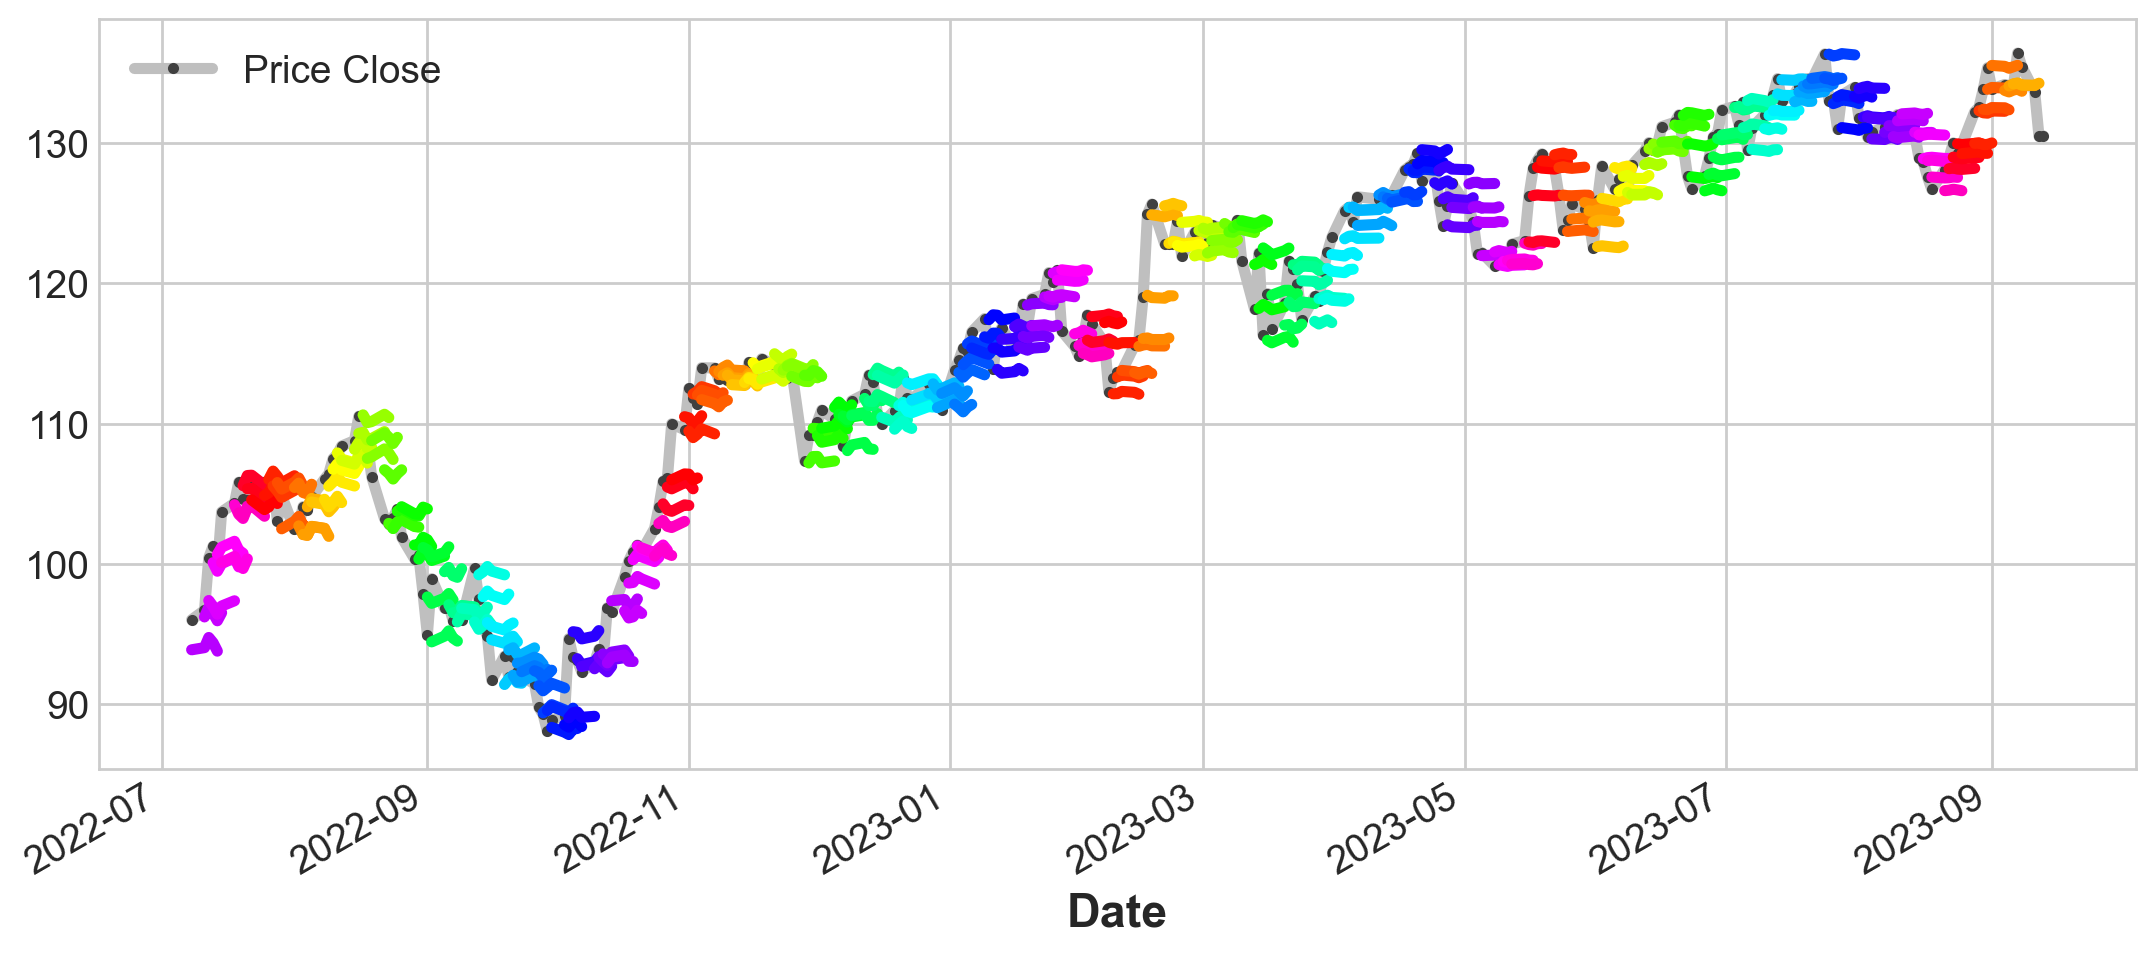

In [42]:
y_pred = []
y_true = []
colors = plt.cm.gist_rainbow(np.linspace(0, 1, 70))

ax1 = sim2[902:].plot(figsize=(11,5),**plot_params)
for i in range(902, 1202):
    pred2 = results2.predict(i,i+4,dynamic=True)
    y_pred.append(pred2.to_list())
    y_true.append(sim2['Price Close'][i:i+5].to_list())
    pred2.plot(ax=ax1, color=colors[i%70])  
rmse1 = mean_squared_error(y_true, y_pred,squared=False)
print(f"RMSE: {rmse1:.2f}\n")

## Linear Regression

In [86]:
def make_lags(ts, lags, lead_time=1):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)
y = sim2.copy()
X = make_lags(y, lags=7).dropna()
X['Covid19'] = (X.index >= '2020-03-13').astype(int)

In [87]:
def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)
y = make_multistep_target(y, steps=5).dropna()

In [88]:
y, X = y.align(X, join='inner', axis=0)

In [89]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

Train RMSE: 4.16
Test RMSE: 2.75


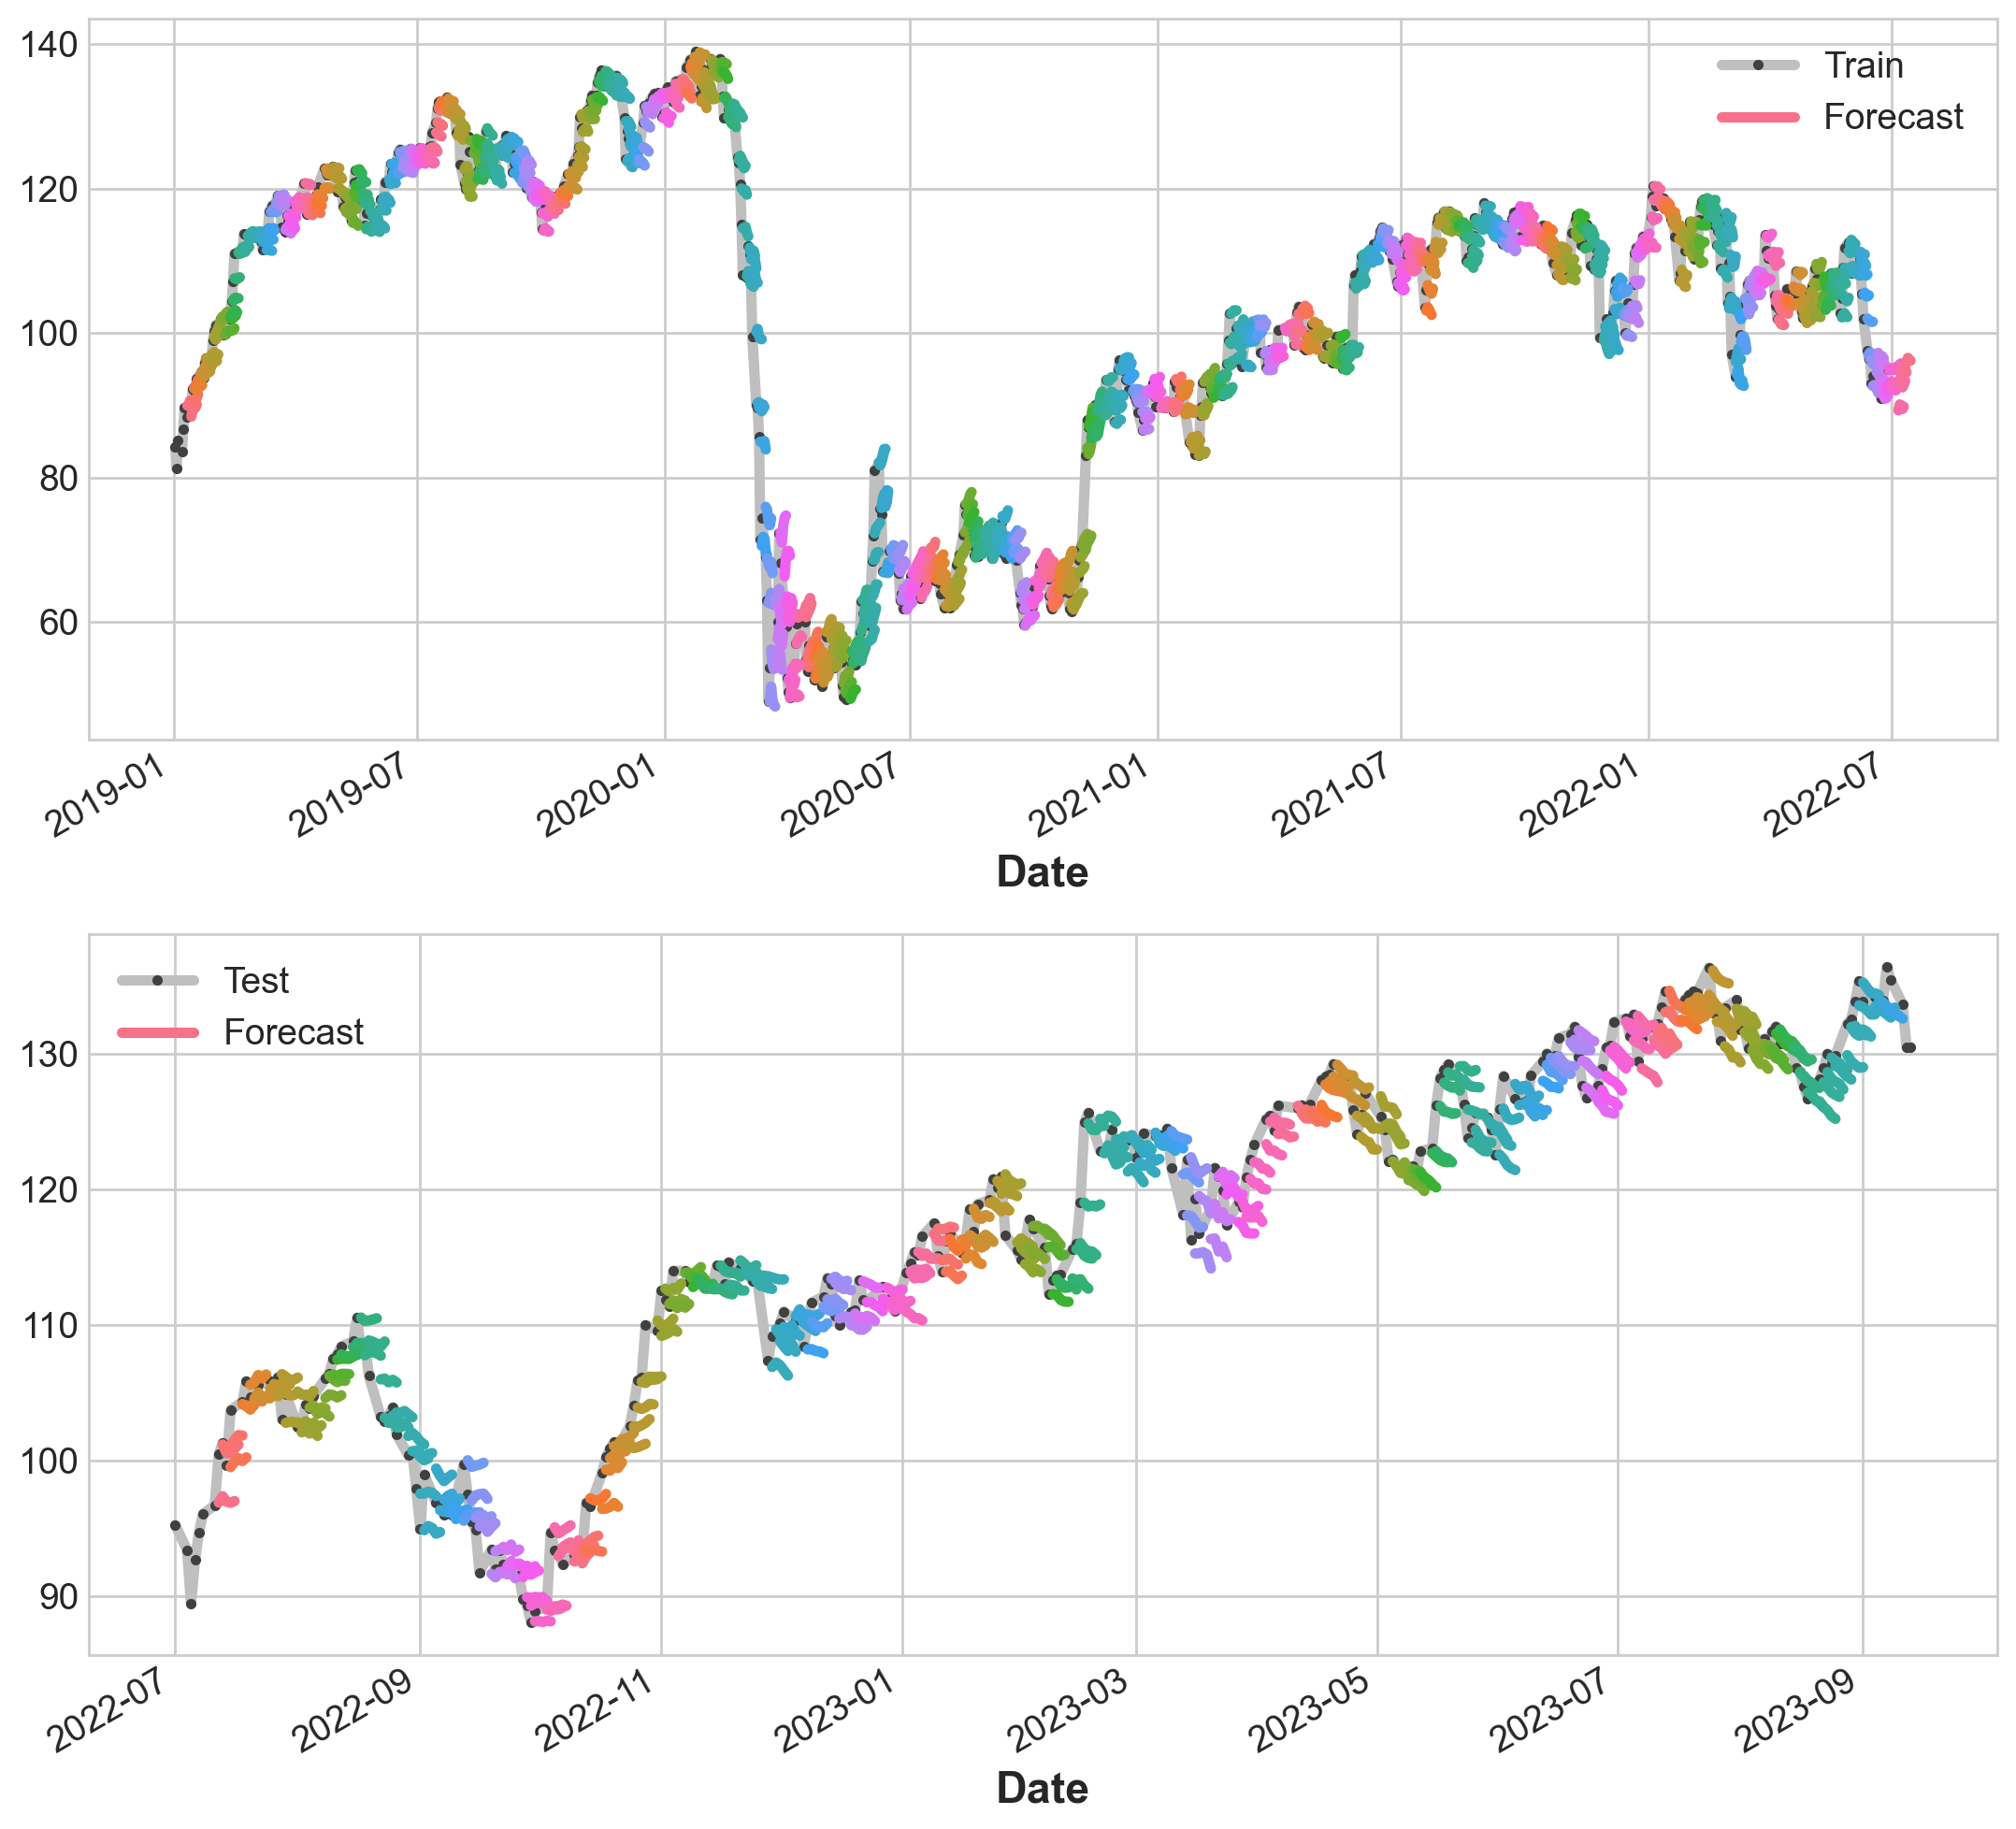

In [90]:
train_rmse1 = mean_squared_error(y_train, y_fit, squared=False)
test_rmse1 = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse1:.2f}\n" f"Test RMSE: {test_rmse1:.2f}"))

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 10))
ax1 = sim2[:len(y_fit)].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['Train', 'Forecast'])
ax2 = sim2[len(y_fit):].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['Test', 'Forecast'])

## XGBoost

In [99]:
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor

model = MultiOutputRegressor(XGBRegressor(
        learning_rate=0.01,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.01,
        reg_lambda=1.0,
        gamma=0,
        objective='reg:squarederror',
        eval_metric='rmse',
        verbose=1
))
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

In [100]:
train_rmse2 = mean_squared_error(y_train, y_fit, squared=False)
test_rmse2 = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse2:.2f}\n" f"Test RMSE: {test_rmse2:.2f}"))

Train RMSE: 1.77
Test RMSE: 3.32


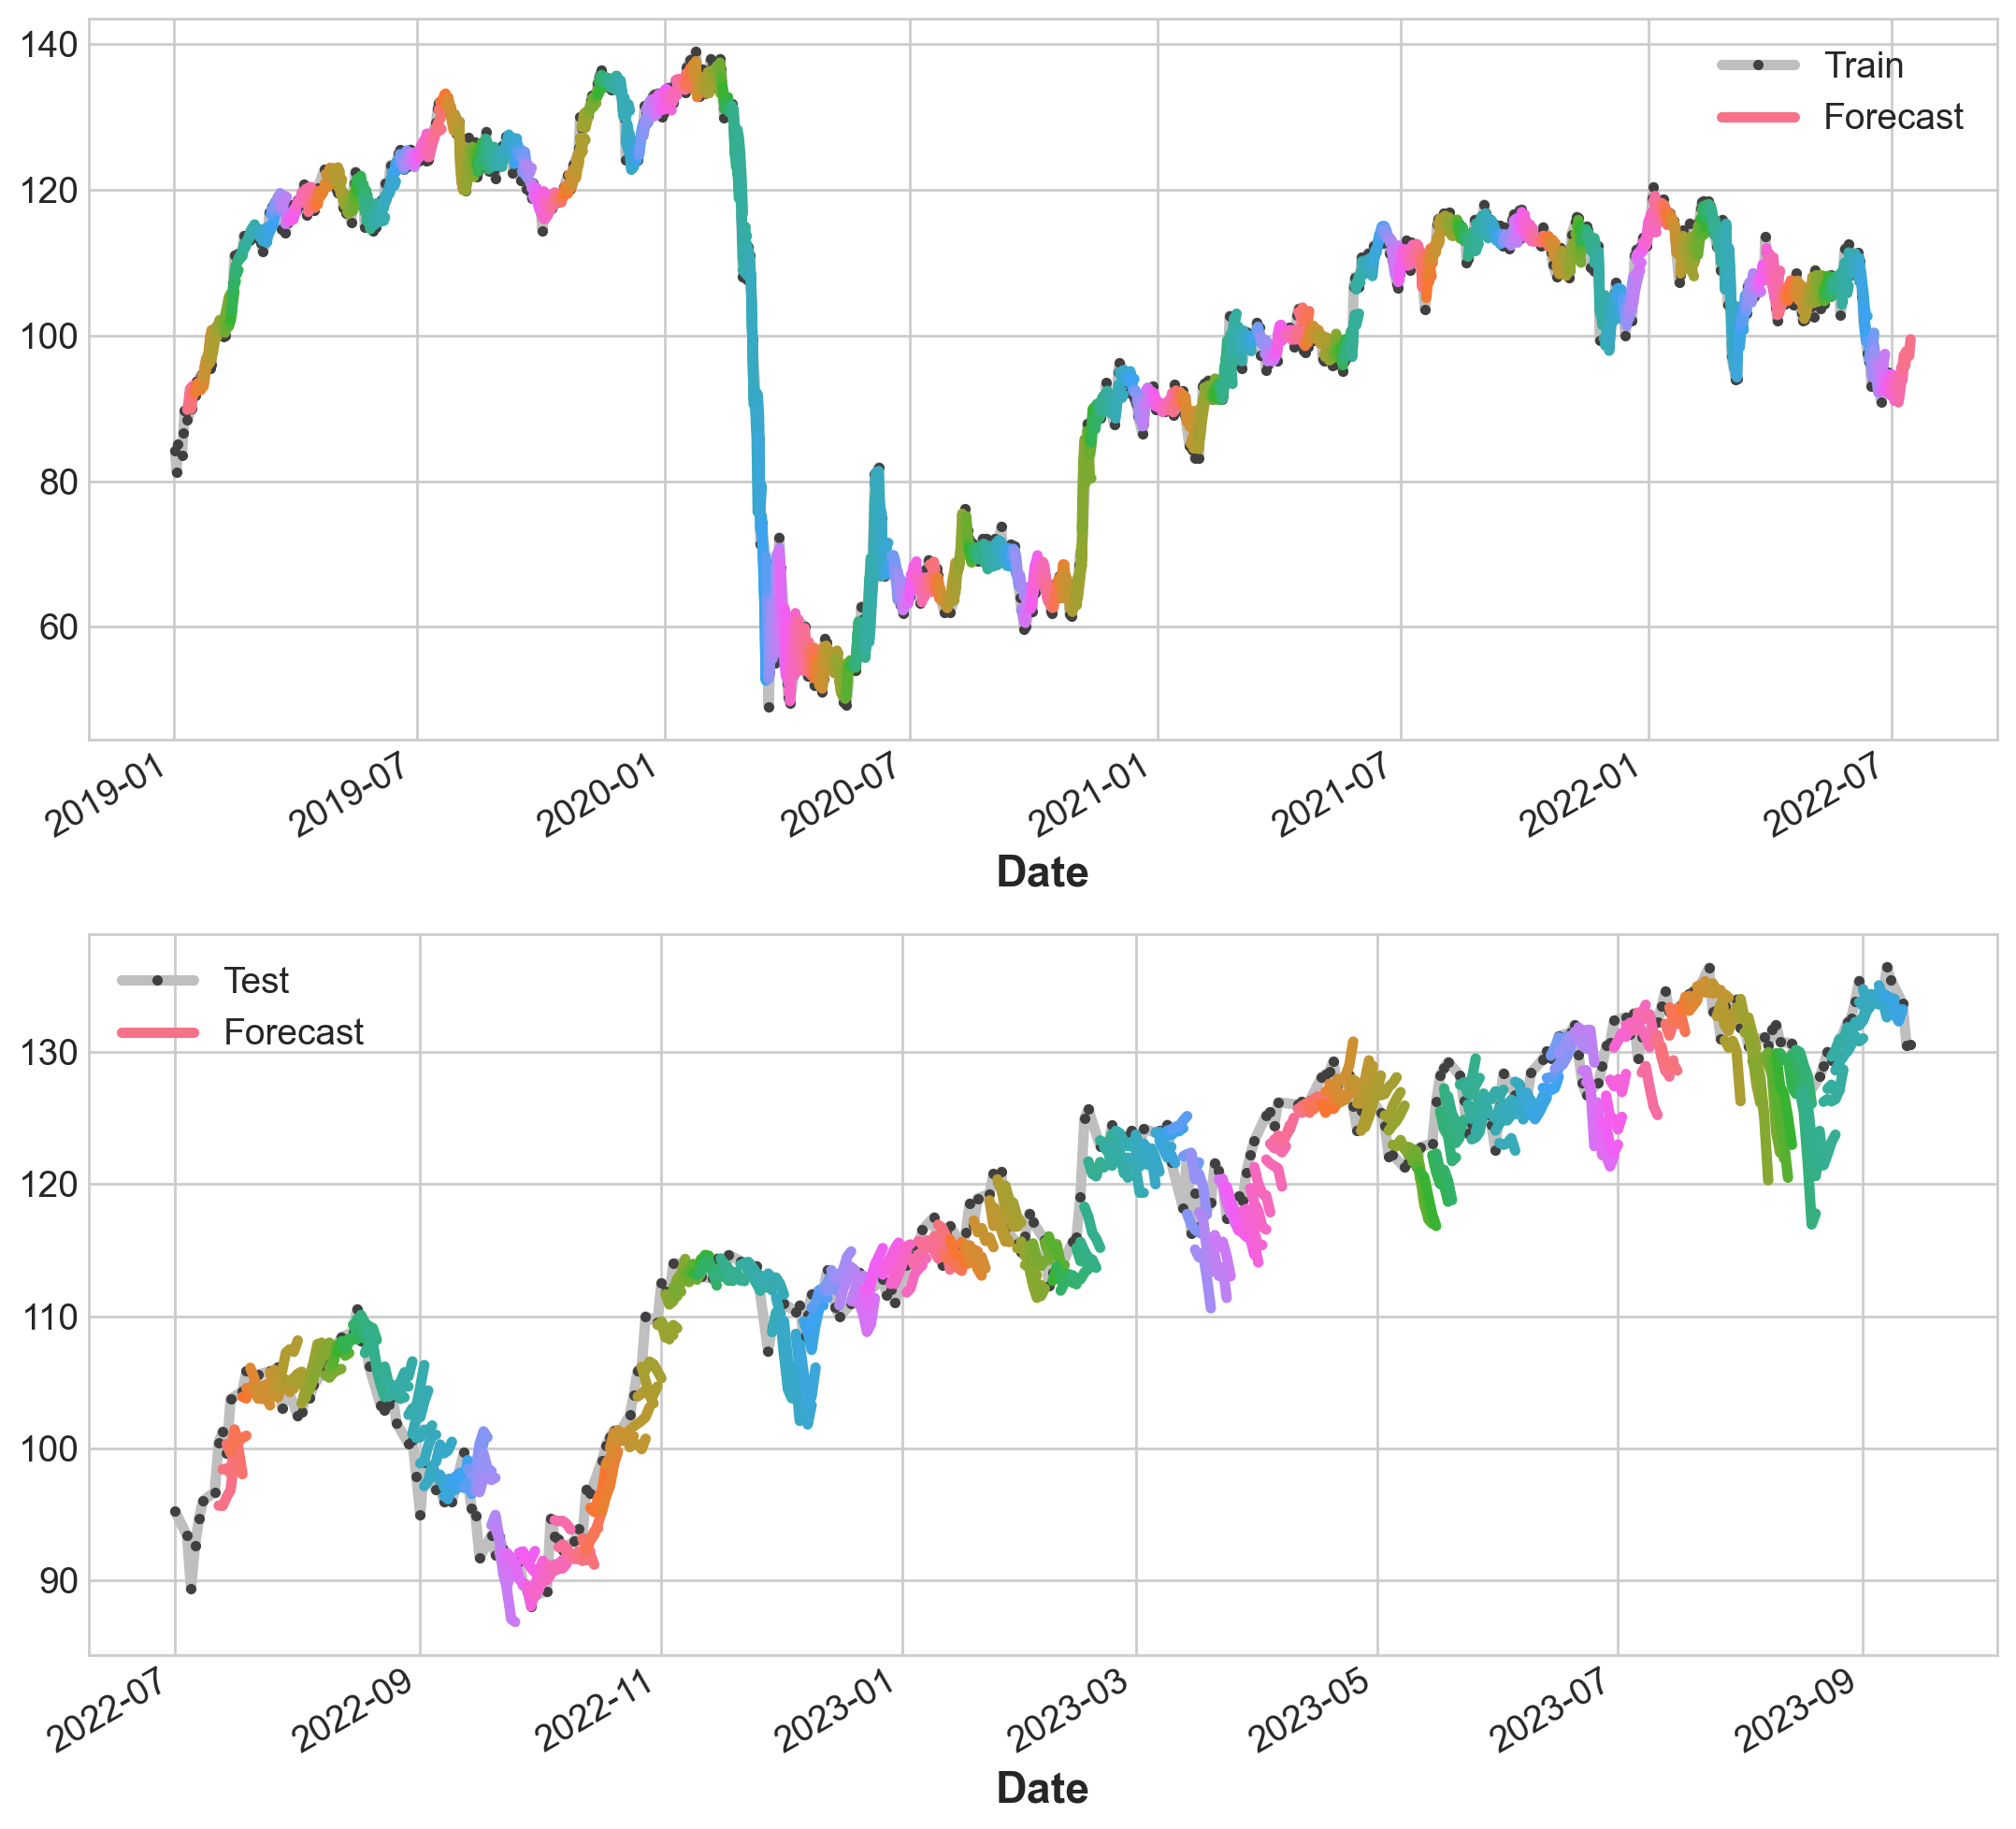

In [101]:
palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 10))
ax1 = sim2[:len(y_fit)].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['Train', 'Forecast'])
ax2 = sim2[len(y_fit):].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['Test', 'Forecast'])

# Model Evaluation

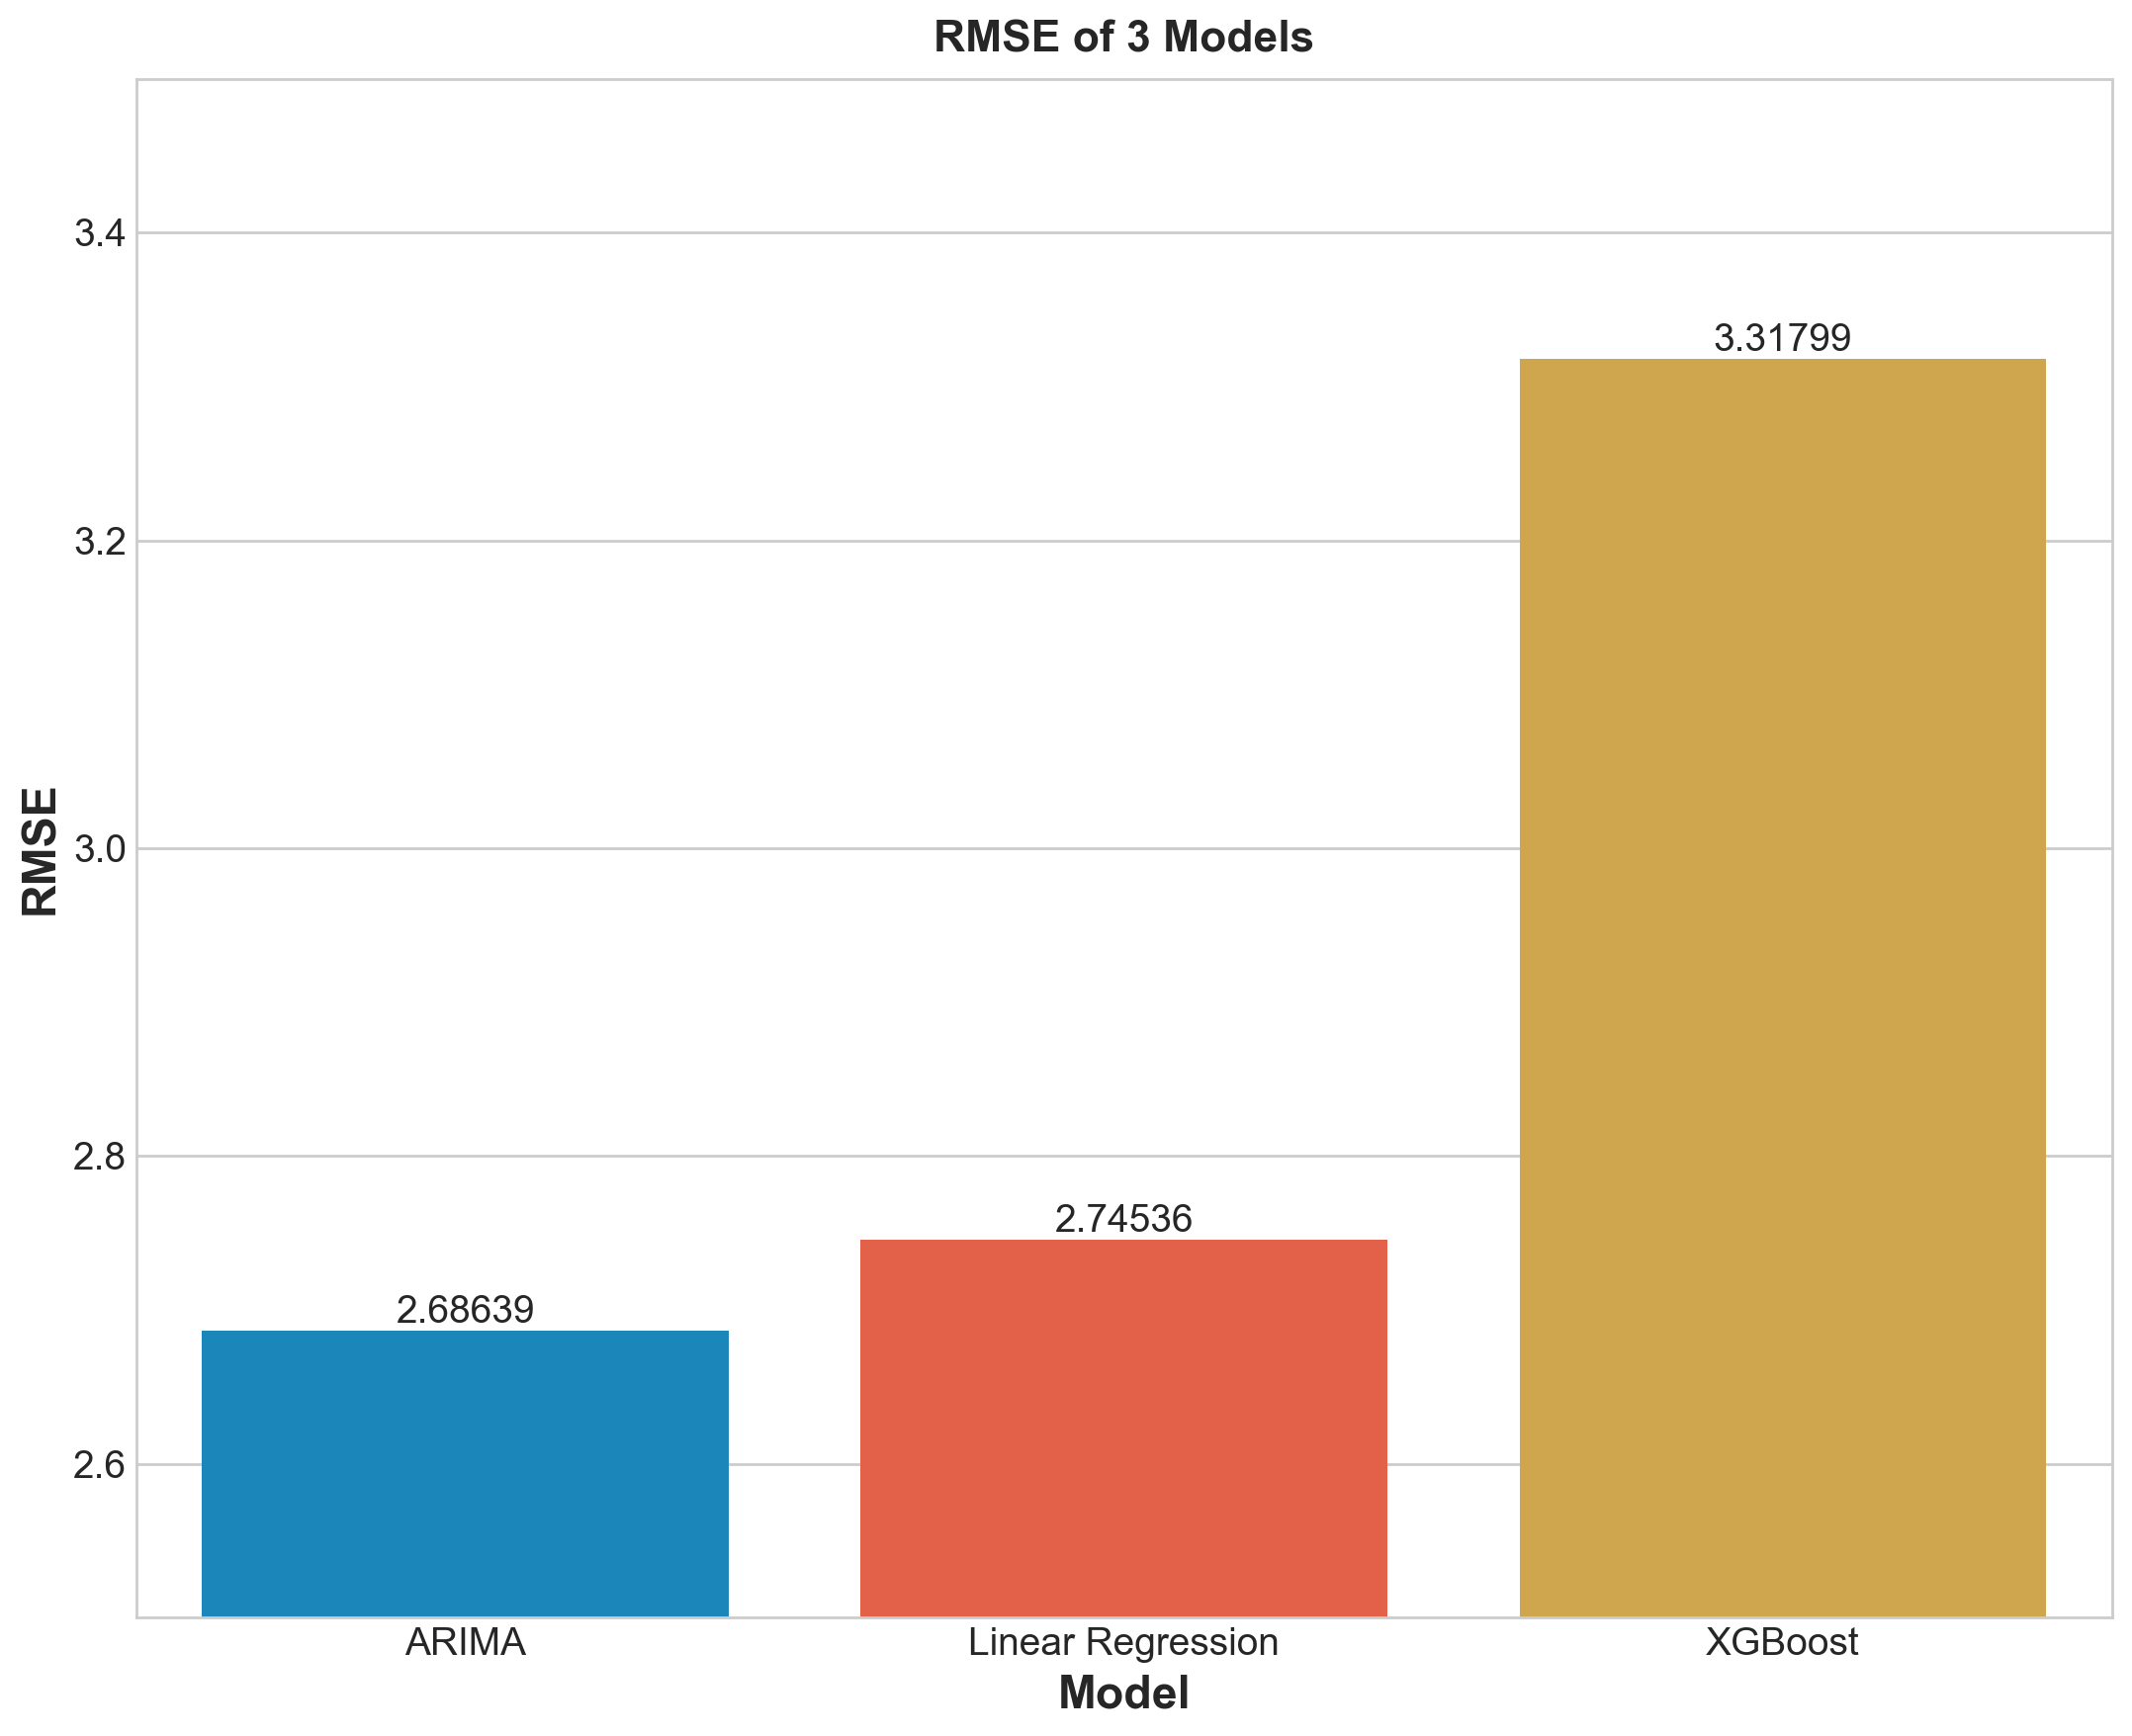

In [103]:
eva = pd.DataFrame()
eva['Model'] = ['ARIMA','Linear Regression','XGBoost']
eva['RMSE'] = [rmse1,test_rmse1,test_rmse2]
fig = sns.barplot(data=eva,y='RMSE',x='Model')
fig.set_ylim(2.5,3.5)
for i in fig.containers:
    fig.bar_label(i,)
plt.title('RMSE of 3 Models')
plt.show()